### Imports

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [5]:
#official libraries
import numpy as np
import matplotlib.pyplot as plt
import pylab
import cmath
import random
from scipy import integrate
from scipy.fftpack import fft
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from scipy import signal
import pandas as pd
import time
import torch.nn as nn
import torch.nn.functional as F
import visdom
from os.path import expanduser

In [6]:
#own files
from lib.utils_general import diff_same_length, get_data_paths
from lib.utils_generate_W import get_grid, gauss_dist, generate_W
from lib.utils_generate_n import n_compl, plot_n
from lib.utils_calc_psi import plot_psi
from lib.utils_generate_data import generate_init_data, \
                                    generate_init_data_diverse, \
                                    plot_sample, generate_corr_data
from lib.utils_initial_dataset import InitialDataset, ToTensor, OneChannel, \
                                      Normalize, calc_mean_std
from lib.utils_train import get_dataloaders, train_net, calc_psi_Int
from lib.nets import FNN, UNet, ResSNN
from lib.utils_evaluation import DeNorm, plot_prediction, plot_correction
from lib.utils_corrector_dataset import CorrectorDataset, NormalizeCorr, \
                                        calc_mean_std_corr, ToDevice
from lib.utils_train_corrector import train_corrector
from lib.UNet_featurek import UNet_featurek
from lib.LSTM import LSTM
from lib.plot_intensity_bars import plot_intensity_bars
from lib.LSTMFFout import LSTMFFout
from lib.utils_stack_model_psisolver import train_lstm, \
            train_psisolver, get_psi, stack_init_visdom, \
            stack_visdom_point, PsiSolver
from lib.utils_stack_model_corrector import corrector_init_visdom, \
        corrector_train, corrector_visdom_point

In [7]:
torch.cuda.is_available()

False

### Parameter, paths, etc

In [15]:
# ---------------------------------
# choose which mode the prg is in:
# ---------------------------------
do_load_model = False
#do_load_model_corr = False
do_train_model = True  # not do_load_model
do_train_lstm = do_train_model
do_train_psisolver = do_train_model
#do_train_model_corr = not do_load_model_corr
do_create_initial_data = False
do_create_test_data = False
#do_create_corrector_data = True
toy_data = True  #if run on GPU machine, set to false
which_model = 'stack_model_psisolver'  #FNN / UNet / UNet_old / UNet_featurek /
#LSTM / LSTMFFout / CIWLSTM / stack_model_psisolv / ResSNN / stack_model_corrector
#which_model_corr = 'UNet'
if which_model == 'CIWLSTM':
    is_CIWLSTM = True
else:
    is_CIWLSTM = False
# ---------------------------------

# ---------------------------------
# paths:
# ---------------------------------
home = expanduser("~")

#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# models
path_model = 'models/' + which_model + '.pt'
path_psisolver = 'models/' + which_model + '_psisolver.pt'
path_corrector = 'models/' + which_model + '_corrector.pt'

# data
path_initial_data, _ = get_data_paths(toy_data, 
                                        device, 
                                        home)
if not toy_data:
    path_initial_data_diverse = home + '/ml_data/data_initial_diverse/'
else:
    path_initial_data_diverse = home + \
        '/MEGA/MEGAsync/Projektarbeit/Code/toy_data/initial_data/'
path_test_data = home + '/ml_data/data_test/'

# plots
path_plots = 'plots/'
# ---------------------------------

# ---------------------------------
# hyperparameters:
# ---------------------------------
learning_rate = 0.0001  # for UNet: 0.000001
learning_rate_corrector = 0.0001
nmbr_epochs = 5
early_stopping = 100
validation_split = 0.2
# ---------------------------------

# ---------------------------------
# data parameters:
# ---------------------------------
half_width = 5
nmbr_points = 10000
if toy_data:
    size_dataset = 150  #if run on GPU machine, set to 5000 (toydata 8)
else:
    size_dataset = 150000

grid, stepsize = get_grid(half_width, nmbr_points)
# ---------------------------------

### Generate Initial Data

In [9]:
if do_create_initial_data:
    generate_init_data_diverse(size_dataset,
                               path=path_initial_data_diverse,
                               x=grid,
                               dx=stepsize)

81


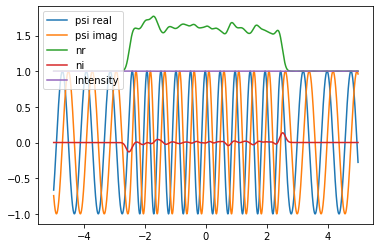

In [16]:
#show that it worked
plot_sample(size_dataset, 
            path=path_initial_data_diverse, 
            x=grid, 
            dx=stepsize)

### Create Initial Dataset

In [17]:
nr_mean, nr_std, ni_mean, ni_std = calc_mean_std(size_dataset,
                                                 path_initial_data_diverse)

In [22]:
transform = transforms.Compose(
    [#Normalize((nr_mean, ni_mean), (nr_std, ni_std)),
     ToTensor()]) #device

In [23]:
initial_dataset = InitialDataset(csv_file=path_initial_data_diverse +
                                 'k_values.csv',
                                 root_dir=path_initial_data_diverse,
                                 transform=transform)

In [24]:
len(initial_dataset)

150

tensor([7., 1., 1.,  ..., 1., 1., 1.])
torch.Size([10001])
k:  3.5377989059538164


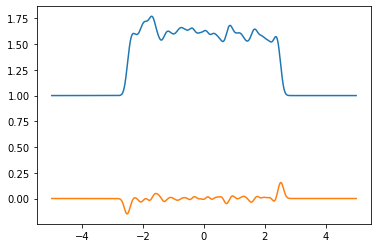

In [25]:
#show that it worked
idx = np.random.randint(len(initial_dataset))

print(initial_dataset[idx]['k_n_r'])
print(initial_dataset[idx]['k_n_r'].size())
#print(initial_dataset[idx]['k_n_r'].is_cuda)

print('k: ',
      DeNorm(initial_dataset[idx]['k_n_r'].cpu().numpy()[0], nr_mean, nr_std))

plt.plot(grid, initial_dataset[idx]['k_n_r'].cpu().numpy()[1:])
plt.plot(grid, initial_dataset[idx]['n_i'].cpu().numpy())

### Phase Space looks fancy

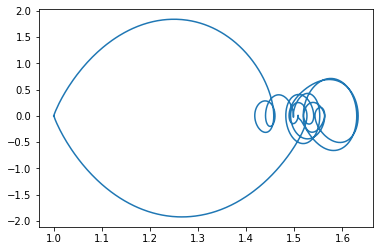

In [34]:
idx = np.random.randint(len(initial_dataset))
frame = [0, 10000]

plt.plot(initial_dataset[idx]['k_n_r']\
         .cpu().numpy()[1+ frame[0]:1+frame[1]],
        diff_same_length(initial_dataset[idx]['k_n_r']\
                         .cpu().numpy()[1+ frame[0]:1+frame[1]], stepsize))

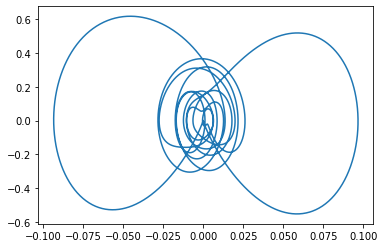

In [35]:
plt.plot(initial_dataset[idx]['n_i'].cpu().numpy(),
        diff_same_length(initial_dataset[idx]['n_i'].cpu().numpy(), stepsize))

### Create Dataloaders and Model

In [12]:
train_loader, validation_loader = get_dataloaders(
    initial_dataset,
    batch_size=8,
    validation_split=validation_split,
    shuffle_dataset=True,
    random_seed=42)

In [17]:
#evtl soll nicht ein neues Model erstellt, sondern ein altes geladen werden!

if do_load_model:
    print('Loading model...')
    model = torch.load(path_model,
                       map_location=device)  # , map_location=device
    if which_model == 'stack_model_corrector':
        corrector = torch.load(path_corrector,
                       map_location=device)
else:
    print('Creating model...')
    #sonst wird jetzt neues Model erstellt
    if which_model == 'FNN':
        model = FNN(n_feature=10001, n_hidden=1000, n_output=10000)
    elif which_model == 'UNet_featurek':
        model = UNet_featurek(device,
                              n_channels=1,
                              n_classes=1,
                              label_len=nmbr_points)
    elif which_model == 'LSTM':
        #model = LSTM(10, 100, 3, 1000, device)
        model = LSTM(10, 500, 3, 1000, device)
    elif which_model == 'LSTMFFout':
        #model = LSTM(10, 100, 3, 1000, device)
        model = LSTMFFout(10, 100, 3, 1000, device)
    elif which_model == 'CIWLSTM':
        model = CIWLSTM(input_size=10,
                        hidden_size_n=100,
                        num_layers_n=3,
                        seq_steps=1000,
                        device=device,
                        hidden_size_psi=200,
                        num_layers_psi=3,
                        nr_mean=nr_mean,
                        nr_std=nr_std,
                        ni_mean=ni_mean,
                        ni_std=ni_std)
    elif which_model == 'stack_model_psisolver':
        model = LSTMFFout(10, 100, 3, 1000, device)
        psisolver = PsiSolver(input_size=10,
                              hidden_size=200,
                              num_layers=3,
                              seq_steps=1000,
                              device=device)
    elif which_model == 'ResSNN':
        model= ResSNN(n_feature=10001, n_hidden=10000, n_output=10000) # 5 layers
    elif which_model == 'stack_model_corrector':
        model = LSTMFFout(10, 100, 3, 1000, device)
        corrector = LSTMFFout(10, 100, 3, 1000, device)
    else:
        model = UNet(n_channels=1, n_classes=1, label_len=nmbr_points)

print(model)
if which_model == 'stack_model_psisolver':
    print(psisolver)
elif which_model == 'stack_model_corrector':
    print(corrector)

Creating model...
LSTMFFout(
  (lstm): LSTM(11, 100, num_layers=3, batch_first=True)
  (fc1): Linear(in_features=100, out_features=10, bias=True)
  (fc2): Linear(in_features=10001, out_features=10000, bias=True)
)
PsiSolver(
  (lstm): LSTM(21, 200, num_layers=3, batch_first=True)
  (fc1): Linear(in_features=200, out_features=20, bias=True)
  (fc2): Linear(in_features=20001, out_features=20000, bias=True)
)


In [18]:
model.to(device)
print(next(model.parameters()).is_cuda)
if which_model == 'stack_model_psisolver':
    psisolver.to(device)
    print(next(psisolver.parameters()).is_cuda)
elif which_model == 'stack_model_corrector':
    corrector.to(device)
    print(next(corrector.parameters()).is_cuda)

True
True


### Training

In [16]:
if do_train_model and not which_model == 'stack_model_psisolver' and not which_model == 'stack_model_corrector':
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model, info = train_net(device,
                            nmbr_epochs,
                            model,
                            criterion,
                            optimizer,
                            train_loader,
                            validation_loader,
                            grid,
                            stepsize,
                            nr_mean,
                            nr_std,
                            ni_mean,
                            ni_std,
                            early_stopping=early_stopping,
                            path=path_model,
                            CIWLSTM=is_CIWLSTM)

In [20]:
# training loop for model & psi solver

if do_train_model and which_model == 'stack_model_psisolver':

    criterion = torch.nn.MSELoss()
    model_optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    psisolver_optimizer = torch.optim.Adam(psisolver.parameters(),
                                           lr=learning_rate)

    info = {
        "lowest ni loss": 100,
        "last ni epoch": 0,
        "lowest psi loss": 100,
        "last psi epoch": 0
    }

    # init two visdom
    vis, visdom_model, visdom_psisolver = stack_init_visdom()

    # init runtime measurement
    time_start_training = time.time()
    train_ni_loss = 0.0
    train_psi_loss = 0.0
    train_Int_loss = 0.0    
    running_ni_loss = 0.0
    running_psi_loss = 0.0
    running_Int_loss = 0.0

    # now training loop
    for current_epoch in range(nmbr_epochs):

        # ------------------------------------
        # TRAINING
        # ------------------------------------

        model = model.train()
        psisolver = psisolver.train()

        for i, batch in enumerate(train_loader):

            k_n_r = batch['k_n_r'].to(device)
            n_i = batch['n_i'].to(device)

            ni_pred = model(k_n_r)

            psir_pred, psii_pred = psisolver(DeNorm(k_n_r, nr_mean, nr_std),
                                             DeNorm(ni_pred, ni_mean, ni_std))

            psir, psii, _ = get_psi(grid,
                                 stepsize,
                                 DeNorm(k_n_r, nr_mean, nr_std),
                                 DeNorm(ni_pred, ni_mean, ni_std),
                                 Amp=1)

            psir, psii = psir.to(device), psii.to(device)

            Int = torch.ones(psir.shape).to(device)
            
            if do_train_lstm:
                ni_loss, int_loss = train_lstm(criterion,
                                               model_optimizer,
                                               n_i, 
                                               Int,
                                               ni_pred, 
                                               psir_pred, 
                                               psii_pred)

            if do_train_psisolver:
                psi_loss = train_psisolver(criterion,
                                         psisolver_optimizer,
                                         psir,
                                         psii,
                                         psir_pred,
                                         psii_pred)

            # print statistics
            running_ni_loss += ni_loss
            running_psi_loss += psi_loss
            running_Int_loss += int_loss            
            if i % 10 == 0:  # print every 10 batches
                print('[%d, %5d] l_ni: %.6f l_psi: %.6f l_int: %.6f time: %.1f' %
                      (current_epoch + 1, i + 1, running_ni_loss / 10,
                       running_psi_loss / 10, running_Int_loss / 10,
                       time.time() - time_start_training))
                train_ni_loss += running_ni_loss / 10
                train_psi_loss += running_psi_loss / 10
                train_Int_loss += running_Int_loss / 10
                running_ni_loss = 0
                running_psi_loss = 0
                running_Int_loss = 0

        # ------------------------------------
        # EVALUATION
        # ------------------------------------

        model = model.eval()
        psisolver = psisolver.eval()

        validation_ni_loss, \
        validation_psi_loss, \
        validation_Int_loss = stack_visdom_point(vis, 
                                                 current_epoch,
                                   visdom_model, 
                                   visdom_psisolver, 
                                   validation_loader,
                                   criterion, 
                                   train_ni_loss, 
                                   train_psi_loss,
                                   train_Int_loss, 
                                   grid, 
                                   stepsize,
                                   device,
                                   model,
                                   psisolver,
                                    nr_mean,
                                    nr_std,
                                    ni_mean,
                                    ni_std)
        
        print('Epoch {} has validation ni loss {}'.format(current_epoch + 1,
                                                validation_ni_loss))
        print('Epoch {} has validation psi loss {}'.format(current_epoch + 1,
                                                validation_psi_loss))
        print('Epoch {} has validation Int loss {}'.format(current_epoch + 1,
                                                validation_Int_loss))
        
        if validation_ni_loss < info["lowest ni loss"]:
            info["lowest ni loss"] = validation_ni_loss
            info["last ni epoch"] = current_epoch + 1
            torch.save(model, path_model)
            print("MODEL SAVED.")

        if validation_psi_loss < info["lowest psi loss"]:
            info["lowest psi loss"] = validation_psi_loss
            info["last psi epoch"] = current_epoch + 1
            torch.save(psisolver, path_corrector)
            print("PSISOLVER SAVED.")        
        
    print('training done')

[1,     1] l_ni: 0.052946 l_psi: 0.082972 l_int: 0.099455 time: 1.6
[1,    11] l_ni: 3.094072 l_psi: 0.906802 l_int: 0.988764 time: 17.5
[1,    21] l_ni: 1.996252 l_psi: 0.925194 l_int: 0.971824 time: 33.4
[1,    31] l_ni: 1.510793 l_psi: 1.021684 l_int: 0.962600 time: 49.3
[1,    41] l_ni: 1.201117 l_psi: 1.072141 l_int: 0.975029 time: 65.2
[1,    51] l_ni: 2.511700 l_psi: 1.105514 l_int: 0.947868 time: 81.0
[1,    61] l_ni: 1.269769 l_psi: 1.078838 l_int: 0.952228 time: 97.1
[1,    71] l_ni: 1.459493 l_psi: 1.040193 l_int: 0.929363 time: 113.1
[1,    81] l_ni: 1.307606 l_psi: 0.960392 l_int: 0.918632 time: 129.2
[1,    91] l_ni: 0.735985 l_psi: 0.992732 l_int: 0.900559 time: 145.1
[1,   101] l_ni: 0.664586 l_psi: 0.938127 l_int: 0.921750 time: 161.7
[1,   111] l_ni: 1.213547 l_psi: 0.991712 l_int: 0.907040 time: 177.9
[1,   121] l_ni: 1.216541 l_psi: 0.976213 l_int: 0.891774 time: 193.8
[1,   131] l_ni: 0.771505 l_psi: 0.977879 l_int: 0.923722 time: 209.8
[1,   141] l_ni: 0.799556 l_

[1,  1171] l_ni: 1.000773 l_psi: 0.644956 l_int: 0.648569 time: 1859.5
[1,  1181] l_ni: 0.382504 l_psi: 0.753888 l_int: 0.681865 time: 1875.2
[1,  1191] l_ni: 0.639510 l_psi: 0.690400 l_int: 0.653604 time: 1891.0
[1,  1201] l_ni: 0.683147 l_psi: 0.727653 l_int: 0.672590 time: 1906.7
[1,  1211] l_ni: 0.246086 l_psi: 0.820568 l_int: 0.786232 time: 1922.5
[1,  1221] l_ni: 0.884147 l_psi: 0.690209 l_int: 0.631696 time: 1938.3
[1,  1231] l_ni: 1.286569 l_psi: 0.688459 l_int: 0.672677 time: 1954.0
[1,  1241] l_ni: 0.441482 l_psi: 0.757831 l_int: 0.730334 time: 1969.6
[1,  1251] l_ni: 0.900964 l_psi: 0.747643 l_int: 0.667067 time: 1985.5
[1,  1261] l_ni: 1.119977 l_psi: 0.771367 l_int: 0.684160 time: 2001.2
[1,  1271] l_ni: 0.429777 l_psi: 0.747109 l_int: 0.746155 time: 2016.9
[1,  1281] l_ni: 1.504885 l_psi: 0.725093 l_int: 0.672784 time: 2032.6
[1,  1291] l_ni: 0.564473 l_psi: 0.693774 l_int: 0.694197 time: 2048.3
[1,  1301] l_ni: 0.783127 l_psi: 0.706895 l_int: 0.668609 time: 2064.6
[1,  1

[1,  2331] l_ni: 0.458191 l_psi: 0.691538 l_int: 0.660416 time: 3690.6
[1,  2341] l_ni: 0.536069 l_psi: 0.719908 l_int: 0.680792 time: 3706.5
[1,  2351] l_ni: 0.276282 l_psi: 0.705022 l_int: 0.670030 time: 3722.4
[1,  2361] l_ni: 0.817393 l_psi: 0.658242 l_int: 0.616410 time: 3738.1
[1,  2371] l_ni: 0.763509 l_psi: 0.611819 l_int: 0.599068 time: 3753.9
[1,  2381] l_ni: 0.694183 l_psi: 0.605932 l_int: 0.561641 time: 3769.5
[1,  2391] l_ni: 0.869413 l_psi: 0.621742 l_int: 0.600257 time: 3785.4
[1,  2401] l_ni: 0.765639 l_psi: 0.609686 l_int: 0.559675 time: 3801.3
[1,  2411] l_ni: 0.825423 l_psi: 0.641580 l_int: 0.587242 time: 3817.2
[1,  2421] l_ni: 0.713938 l_psi: 0.680858 l_int: 0.637332 time: 3832.8
[1,  2431] l_ni: 0.336496 l_psi: 0.733291 l_int: 0.656938 time: 3848.6
[1,  2441] l_ni: 1.032798 l_psi: 0.633068 l_int: 0.576925 time: 3864.3
[1,  2451] l_ni: 0.827115 l_psi: 0.591343 l_int: 0.564617 time: 3879.9
[1,  2461] l_ni: 0.607629 l_psi: 0.589408 l_int: 0.599583 time: 3895.7
[1,  2

[1,  3491] l_ni: 0.169554 l_psi: 0.737544 l_int: 0.713750 time: 5518.9
[1,  3501] l_ni: 0.054995 l_psi: 0.805154 l_int: 0.797494 time: 5534.6
[1,  3511] l_ni: 0.102442 l_psi: 0.733257 l_int: 0.722254 time: 5551.1
[1,  3521] l_ni: 0.146483 l_psi: 0.767206 l_int: 0.757477 time: 5567.0
[1,  3531] l_ni: 0.358588 l_psi: 0.686474 l_int: 0.680475 time: 5584.2
[1,  3541] l_ni: 0.249210 l_psi: 0.616128 l_int: 0.612743 time: 5600.5
[1,  3551] l_ni: 0.158797 l_psi: 0.657552 l_int: 0.650762 time: 5616.4
[1,  3561] l_ni: 0.163041 l_psi: 0.742613 l_int: 0.736327 time: 5632.0
[1,  3571] l_ni: 0.214555 l_psi: 0.744471 l_int: 0.728373 time: 5647.9
[1,  3581] l_ni: 0.254087 l_psi: 0.830590 l_int: 0.822834 time: 5663.5
[1,  3591] l_ni: 0.177641 l_psi: 0.680149 l_int: 0.667911 time: 5679.2
[1,  3601] l_ni: 0.160157 l_psi: 0.705441 l_int: 0.698109 time: 5695.3
[1,  3611] l_ni: 0.119129 l_psi: 0.754115 l_int: 0.750130 time: 5711.1
[1,  3621] l_ni: 0.241244 l_psi: 0.727382 l_int: 0.703196 time: 5727.3
[1,  3

[1,  4651] l_ni: 0.137229 l_psi: 0.631200 l_int: 0.616996 time: 7354.9
[1,  4661] l_ni: 0.134947 l_psi: 0.624624 l_int: 0.626608 time: 7371.0
[1,  4671] l_ni: 0.048165 l_psi: 0.670766 l_int: 0.658712 time: 7386.7
[1,  4681] l_ni: 0.066552 l_psi: 0.757435 l_int: 0.716928 time: 7402.4
[1,  4691] l_ni: 0.120377 l_psi: 0.680557 l_int: 0.663301 time: 7418.9
[1,  4701] l_ni: 0.103123 l_psi: 0.670262 l_int: 0.697096 time: 7435.2
[1,  4711] l_ni: 0.048736 l_psi: 0.615527 l_int: 0.594648 time: 7451.9
[1,  4721] l_ni: 0.043180 l_psi: 0.714965 l_int: 0.707839 time: 7468.3
[1,  4731] l_ni: 0.094478 l_psi: 0.686736 l_int: 0.658510 time: 7484.3
[1,  4741] l_ni: 0.095205 l_psi: 0.753504 l_int: 0.764999 time: 7499.9
[1,  4751] l_ni: 0.131341 l_psi: 0.663863 l_int: 0.683099 time: 7515.6
[1,  4761] l_ni: 0.058343 l_psi: 0.722121 l_int: 0.707138 time: 7531.4
[1,  4771] l_ni: 0.115555 l_psi: 0.637652 l_int: 0.613741 time: 7547.3
[1,  4781] l_ni: 0.025865 l_psi: 0.748334 l_int: 0.750358 time: 7563.3
[1,  4

[1,  5811] l_ni: 0.023578 l_psi: 0.656918 l_int: 0.640052 time: 9185.8
[1,  5821] l_ni: 0.056036 l_psi: 0.603712 l_int: 0.589276 time: 9201.5
[1,  5831] l_ni: 0.029599 l_psi: 0.630531 l_int: 0.593446 time: 9217.2
[1,  5841] l_ni: 0.035669 l_psi: 0.686062 l_int: 0.660963 time: 9233.1
[1,  5851] l_ni: 0.040395 l_psi: 0.646357 l_int: 0.640330 time: 9248.9
[1,  5861] l_ni: 0.110030 l_psi: 0.691195 l_int: 0.663711 time: 9264.5
[1,  5871] l_ni: 0.068195 l_psi: 0.585599 l_int: 0.571637 time: 9280.3
[1,  5881] l_ni: 0.049665 l_psi: 0.597437 l_int: 0.580085 time: 9296.0
[1,  5891] l_ni: 0.028222 l_psi: 0.568623 l_int: 0.555109 time: 9311.7
[1,  5901] l_ni: 0.081391 l_psi: 0.604528 l_int: 0.562160 time: 9327.4
[1,  5911] l_ni: 0.049177 l_psi: 0.623212 l_int: 0.624602 time: 9343.0
[1,  5921] l_ni: 0.028332 l_psi: 0.592965 l_int: 0.615331 time: 9358.7
[1,  5931] l_ni: 0.066496 l_psi: 0.585963 l_int: 0.556070 time: 9374.3
[1,  5941] l_ni: 0.061327 l_psi: 0.547335 l_int: 0.522656 time: 9390.0
[1,  5

[1,  6961] l_ni: 0.045304 l_psi: 0.493334 l_int: 0.450323 time: 10998.7
[1,  6971] l_ni: 0.147404 l_psi: 0.543293 l_int: 0.529207 time: 11014.8
[1,  6981] l_ni: 0.028722 l_psi: 0.638338 l_int: 0.583251 time: 11031.0
[1,  6991] l_ni: 0.079871 l_psi: 0.583025 l_int: 0.559266 time: 11046.7
[1,  7001] l_ni: 0.064958 l_psi: 0.633598 l_int: 0.616572 time: 11062.4
[1,  7011] l_ni: 0.034176 l_psi: 0.578290 l_int: 0.554763 time: 11078.0
[1,  7021] l_ni: 0.031226 l_psi: 0.586611 l_int: 0.554295 time: 11093.6
[1,  7031] l_ni: 0.030340 l_psi: 0.569308 l_int: 0.532775 time: 11109.3
[1,  7041] l_ni: 0.025941 l_psi: 0.543832 l_int: 0.521246 time: 11125.6
[1,  7051] l_ni: 0.030981 l_psi: 0.518132 l_int: 0.516769 time: 11141.3
[1,  7061] l_ni: 0.026516 l_psi: 0.476751 l_int: 0.445363 time: 11157.0
[1,  7071] l_ni: 0.019336 l_psi: 0.569006 l_int: 0.538210 time: 11173.2
[1,  7081] l_ni: 0.036589 l_psi: 0.575087 l_int: 0.534340 time: 11188.9
[1,  7091] l_ni: 0.021339 l_psi: 0.597068 l_int: 0.594342 time: 

[1,  8101] l_ni: 0.027111 l_psi: 0.583841 l_int: 0.551909 time: 12793.7
[1,  8111] l_ni: 0.041404 l_psi: 0.489554 l_int: 0.463676 time: 12809.4
[1,  8121] l_ni: 0.029952 l_psi: 0.572801 l_int: 0.516972 time: 12825.0
[1,  8131] l_ni: 0.068849 l_psi: 0.522576 l_int: 0.509682 time: 12840.8
[1,  8141] l_ni: 0.078906 l_psi: 0.553044 l_int: 0.501408 time: 12856.4
[1,  8151] l_ni: 0.043918 l_psi: 0.527498 l_int: 0.519126 time: 12872.1
[1,  8161] l_ni: 0.033341 l_psi: 0.562236 l_int: 0.519742 time: 12887.8
[1,  8171] l_ni: 0.036419 l_psi: 0.534178 l_int: 0.503764 time: 12903.4
[1,  8181] l_ni: 0.067187 l_psi: 0.464504 l_int: 0.452270 time: 12919.2
[1,  8191] l_ni: 0.030695 l_psi: 0.528437 l_int: 0.518577 time: 12934.9
[1,  8201] l_ni: 0.110088 l_psi: 0.480342 l_int: 0.444411 time: 12950.5
[1,  8211] l_ni: 0.061394 l_psi: 0.554283 l_int: 0.534208 time: 12966.1
[1,  8221] l_ni: 0.062046 l_psi: 0.512769 l_int: 0.480459 time: 12981.8
[1,  8231] l_ni: 0.092575 l_psi: 0.534227 l_int: 0.501861 time: 

[1,  9241] l_ni: 0.068750 l_psi: 0.498092 l_int: 0.458797 time: 14586.8
[1,  9251] l_ni: 0.074095 l_psi: 0.479383 l_int: 0.457961 time: 14602.5
[1,  9261] l_ni: 0.046424 l_psi: 0.558438 l_int: 0.502640 time: 14618.3
[1,  9271] l_ni: 0.035083 l_psi: 0.527294 l_int: 0.509913 time: 14634.0
[1,  9281] l_ni: 0.054744 l_psi: 0.546936 l_int: 0.522175 time: 14649.7
[1,  9291] l_ni: 0.115622 l_psi: 0.424795 l_int: 0.406930 time: 14665.4
[1,  9301] l_ni: 0.057122 l_psi: 0.495314 l_int: 0.481701 time: 14681.0
[1,  9311] l_ni: 0.023794 l_psi: 0.526475 l_int: 0.475933 time: 14696.7
[1,  9321] l_ni: 0.022859 l_psi: 0.536008 l_int: 0.477794 time: 14712.3
[1,  9331] l_ni: 0.013941 l_psi: 0.547260 l_int: 0.512249 time: 14728.2
[1,  9341] l_ni: 0.020072 l_psi: 0.465999 l_int: 0.468144 time: 14743.9
[1,  9351] l_ni: 0.029792 l_psi: 0.466604 l_int: 0.452509 time: 14759.7
[1,  9361] l_ni: 0.096913 l_psi: 0.497145 l_int: 0.471113 time: 14775.5
[1,  9371] l_ni: 0.153256 l_psi: 0.448351 l_int: 0.480919 time: 

[1, 10381] l_ni: 0.017689 l_psi: 0.487522 l_int: 0.445572 time: 16383.7
[1, 10391] l_ni: 0.017412 l_psi: 0.422438 l_int: 0.410450 time: 16399.4
[1, 10401] l_ni: 0.043749 l_psi: 0.438434 l_int: 0.426020 time: 16415.1
[1, 10411] l_ni: 0.023177 l_psi: 0.449742 l_int: 0.436865 time: 16430.8
[1, 10421] l_ni: 0.021644 l_psi: 0.482796 l_int: 0.456905 time: 16446.5
[1, 10431] l_ni: 0.022913 l_psi: 0.423903 l_int: 0.410796 time: 16462.1
[1, 10441] l_ni: 0.016203 l_psi: 0.497539 l_int: 0.483247 time: 16477.8
[1, 10451] l_ni: 0.047215 l_psi: 0.387915 l_int: 0.361714 time: 16493.4
[1, 10461] l_ni: 0.042000 l_psi: 0.533824 l_int: 0.468437 time: 16509.1
[1, 10471] l_ni: 0.045214 l_psi: 0.442709 l_int: 0.399084 time: 16524.8
[1, 10481] l_ni: 0.023889 l_psi: 0.486430 l_int: 0.445920 time: 16540.5
[1, 10491] l_ni: 0.029986 l_psi: 0.527051 l_int: 0.474958 time: 16556.1
[1, 10501] l_ni: 0.025124 l_psi: 0.436646 l_int: 0.402650 time: 16571.8
[1, 10511] l_ni: 0.037457 l_psi: 0.467490 l_int: 0.450547 time: 

[1, 11521] l_ni: 0.087610 l_psi: 0.433512 l_int: 0.408672 time: 18179.4
[1, 11531] l_ni: 0.043575 l_psi: 0.404599 l_int: 0.399435 time: 18195.1
[1, 11541] l_ni: 0.062405 l_psi: 0.404293 l_int: 0.376649 time: 18210.7
[1, 11551] l_ni: 0.048482 l_psi: 0.406424 l_int: 0.391369 time: 18226.5
[1, 11561] l_ni: 0.041814 l_psi: 0.393624 l_int: 0.379456 time: 18242.1
[1, 11571] l_ni: 0.037658 l_psi: 0.381053 l_int: 0.359015 time: 18257.8
[1, 11581] l_ni: 0.028756 l_psi: 0.431741 l_int: 0.389092 time: 18273.5
[1, 11591] l_ni: 0.044355 l_psi: 0.376150 l_int: 0.353072 time: 18289.1
[1, 11601] l_ni: 0.033703 l_psi: 0.444258 l_int: 0.408982 time: 18304.7
[1, 11611] l_ni: 0.024321 l_psi: 0.408984 l_int: 0.410642 time: 18320.4
[1, 11621] l_ni: 0.022791 l_psi: 0.442834 l_int: 0.435240 time: 18336.0
[1, 11631] l_ni: 0.050152 l_psi: 0.450645 l_int: 0.429239 time: 18351.7
[1, 11641] l_ni: 0.035244 l_psi: 0.375385 l_int: 0.358785 time: 18367.5
[1, 11651] l_ni: 0.038280 l_psi: 0.426815 l_int: 0.390202 time: 

[1, 12661] l_ni: 0.037637 l_psi: 0.396343 l_int: 0.362350 time: 19972.2
[1, 12671] l_ni: 0.082243 l_psi: 0.284820 l_int: 0.279973 time: 19988.1
[1, 12681] l_ni: 0.026156 l_psi: 0.350629 l_int: 0.329047 time: 20004.7
[1, 12691] l_ni: 0.048283 l_psi: 0.397022 l_int: 0.355996 time: 20020.4
[1, 12701] l_ni: 0.048344 l_psi: 0.478046 l_int: 0.392632 time: 20036.1
[1, 12711] l_ni: 0.053238 l_psi: 0.408536 l_int: 0.350448 time: 20052.0
[1, 12721] l_ni: 0.056331 l_psi: 0.336395 l_int: 0.310986 time: 20067.9
[1, 12731] l_ni: 0.033865 l_psi: 0.405160 l_int: 0.333225 time: 20083.7
[1, 12741] l_ni: 0.039248 l_psi: 0.354905 l_int: 0.324108 time: 20099.6
[1, 12751] l_ni: 0.035642 l_psi: 0.359964 l_int: 0.352710 time: 20115.4
[1, 12761] l_ni: 0.023000 l_psi: 0.465376 l_int: 0.419404 time: 20131.4
[1, 12771] l_ni: 0.041313 l_psi: 0.387687 l_int: 0.370244 time: 20147.4
[1, 12781] l_ni: 0.031451 l_psi: 0.325366 l_int: 0.296404 time: 20163.1
[1, 12791] l_ni: 0.034523 l_psi: 0.409200 l_int: 0.385471 time: 

[1, 13801] l_ni: 0.038508 l_psi: 0.344927 l_int: 0.318866 time: 21767.6
[1, 13811] l_ni: 0.034819 l_psi: 0.302483 l_int: 0.284093 time: 21783.4
[1, 13821] l_ni: 0.028274 l_psi: 0.323962 l_int: 0.288747 time: 21799.2
[1, 13831] l_ni: 0.040813 l_psi: 0.356652 l_int: 0.333604 time: 21815.0
[1, 13841] l_ni: 0.035227 l_psi: 0.337749 l_int: 0.319745 time: 21830.7
[1, 13851] l_ni: 0.019891 l_psi: 0.422144 l_int: 0.387322 time: 21846.8
[1, 13861] l_ni: 0.021014 l_psi: 0.406888 l_int: 0.375606 time: 21862.6
[1, 13871] l_ni: 0.031103 l_psi: 0.304998 l_int: 0.301488 time: 21879.5
[1, 13881] l_ni: 0.021532 l_psi: 0.370852 l_int: 0.350655 time: 21895.2
[1, 13891] l_ni: 0.020547 l_psi: 0.380939 l_int: 0.371349 time: 21911.1
[1, 13901] l_ni: 0.017678 l_psi: 0.438897 l_int: 0.408444 time: 21926.8
[1, 13911] l_ni: 0.029929 l_psi: 0.326730 l_int: 0.310445 time: 21942.5
[1, 13921] l_ni: 0.025388 l_psi: 0.333841 l_int: 0.310546 time: 21958.6
[1, 13931] l_ni: 0.029949 l_psi: 0.398502 l_int: 0.368299 time: 

[1, 14941] l_ni: 0.050569 l_psi: 0.340092 l_int: 0.340924 time: 23563.7
[1, 14951] l_ni: 0.038550 l_psi: 0.338723 l_int: 0.314835 time: 23579.3
[1, 14961] l_ni: 0.050377 l_psi: 0.360025 l_int: 0.347858 time: 23595.1
[1, 14971] l_ni: 0.028519 l_psi: 0.297232 l_int: 0.287663 time: 23610.7
[1, 14981] l_ni: 0.048820 l_psi: 0.306422 l_int: 0.280460 time: 23626.5
[1, 14991] l_ni: 0.052207 l_psi: 0.350596 l_int: 0.267141 time: 23642.1
validation batch 0/3750
validation batch 50/3750
validation batch 100/3750
validation batch 150/3750
validation batch 200/3750
validation batch 250/3750
validation batch 300/3750
validation batch 350/3750
validation batch 400/3750
validation batch 450/3750
validation batch 500/3750
validation batch 550/3750
validation batch 600/3750
validation batch 650/3750
validation batch 700/3750
validation batch 750/3750
validation batch 800/3750
validation batch 850/3750
validation batch 900/3750
validation batch 950/3750
validation batch 1000/3750
validation batch 1050/37

[2,   781] l_ni: 0.025606 l_psi: 0.330987 l_int: 0.303102 time: 29721.7
[2,   791] l_ni: 0.022090 l_psi: 0.452630 l_int: 0.398619 time: 29737.3
[2,   801] l_ni: 0.047322 l_psi: 0.351887 l_int: 0.298930 time: 29752.9
[2,   811] l_ni: 0.028240 l_psi: 0.322039 l_int: 0.293627 time: 29768.7
[2,   821] l_ni: 0.041706 l_psi: 0.294000 l_int: 0.287934 time: 29784.3
[2,   831] l_ni: 0.070736 l_psi: 0.353569 l_int: 0.315797 time: 29800.1
[2,   841] l_ni: 0.040192 l_psi: 0.316038 l_int: 0.279598 time: 29815.9
[2,   851] l_ni: 0.043239 l_psi: 0.290338 l_int: 0.277887 time: 29831.7
[2,   861] l_ni: 0.028530 l_psi: 0.321188 l_int: 0.302116 time: 29847.6
[2,   871] l_ni: 0.043064 l_psi: 0.262586 l_int: 0.261434 time: 29863.2
[2,   881] l_ni: 0.039022 l_psi: 0.316795 l_int: 0.265473 time: 29878.8
[2,   891] l_ni: 0.030942 l_psi: 0.306532 l_int: 0.266634 time: 29894.5
[2,   901] l_ni: 0.039958 l_psi: 0.359911 l_int: 0.325821 time: 29910.1
[2,   911] l_ni: 0.023205 l_psi: 0.391258 l_int: 0.348223 time: 

[2,  1921] l_ni: 0.028401 l_psi: 0.318090 l_int: 0.305310 time: 31509.5
[2,  1931] l_ni: 0.036401 l_psi: 0.299714 l_int: 0.268341 time: 31525.1
[2,  1941] l_ni: 0.028998 l_psi: 0.327239 l_int: 0.302213 time: 31540.9
[2,  1951] l_ni: 0.030130 l_psi: 0.327914 l_int: 0.311163 time: 31556.6
[2,  1961] l_ni: 0.025308 l_psi: 0.402412 l_int: 0.347080 time: 31572.3
[2,  1971] l_ni: 0.030326 l_psi: 0.357817 l_int: 0.320999 time: 31588.1
[2,  1981] l_ni: 0.025928 l_psi: 0.315425 l_int: 0.285309 time: 31603.7
[2,  1991] l_ni: 0.034910 l_psi: 0.348390 l_int: 0.322526 time: 31619.4
[2,  2001] l_ni: 0.034351 l_psi: 0.316937 l_int: 0.296879 time: 31635.0
[2,  2011] l_ni: 0.045886 l_psi: 0.357357 l_int: 0.328943 time: 31650.7
[2,  2021] l_ni: 0.054053 l_psi: 0.336576 l_int: 0.312898 time: 31666.4
[2,  2031] l_ni: 0.045834 l_psi: 0.288968 l_int: 0.280480 time: 31682.0
[2,  2041] l_ni: 0.065716 l_psi: 0.313098 l_int: 0.262572 time: 31697.6
[2,  2051] l_ni: 0.043303 l_psi: 0.352990 l_int: 0.325097 time: 

[2,  3061] l_ni: 0.028066 l_psi: 0.351294 l_int: 0.300583 time: 33293.0
[2,  3071] l_ni: 0.027152 l_psi: 0.348339 l_int: 0.291098 time: 33308.7
[2,  3081] l_ni: 0.028052 l_psi: 0.275729 l_int: 0.267168 time: 33324.3
[2,  3091] l_ni: 0.049131 l_psi: 0.401503 l_int: 0.306147 time: 33340.0
[2,  3101] l_ni: 0.038162 l_psi: 0.330916 l_int: 0.294624 time: 33355.7
[2,  3111] l_ni: 0.032274 l_psi: 0.315835 l_int: 0.298303 time: 33371.3
[2,  3121] l_ni: 0.032261 l_psi: 0.280966 l_int: 0.258905 time: 33386.9
[2,  3131] l_ni: 0.027167 l_psi: 0.311773 l_int: 0.268109 time: 33402.5
[2,  3141] l_ni: 0.038478 l_psi: 0.283032 l_int: 0.244140 time: 33418.2
[2,  3151] l_ni: 0.028650 l_psi: 0.309769 l_int: 0.273352 time: 33433.9
[2,  3161] l_ni: 0.038387 l_psi: 0.343008 l_int: 0.288769 time: 33449.6
[2,  3171] l_ni: 0.028440 l_psi: 0.370813 l_int: 0.286072 time: 33465.2
[2,  3181] l_ni: 0.031559 l_psi: 0.299771 l_int: 0.256184 time: 33480.9
[2,  3191] l_ni: 0.029995 l_psi: 0.274600 l_int: 0.259437 time: 

[2,  4201] l_ni: 0.009976 l_psi: 0.456824 l_int: 0.455508 time: 35083.2
[2,  4211] l_ni: 0.037391 l_psi: 0.469355 l_int: 0.441447 time: 35098.9
[2,  4221] l_ni: 0.018247 l_psi: 0.524259 l_int: 0.507741 time: 35114.7
[2,  4231] l_ni: 0.030095 l_psi: 0.470023 l_int: 0.442715 time: 35130.4
[2,  4241] l_ni: 0.021805 l_psi: 0.398300 l_int: 0.367927 time: 35146.1
[2,  4251] l_ni: 0.019448 l_psi: 0.501537 l_int: 0.458845 time: 35161.8
[2,  4261] l_ni: 0.033006 l_psi: 0.445643 l_int: 0.416171 time: 35177.5
[2,  4271] l_ni: 0.017315 l_psi: 0.498823 l_int: 0.485818 time: 35193.1
[2,  4281] l_ni: 0.014015 l_psi: 0.442794 l_int: 0.424534 time: 35208.8
[2,  4291] l_ni: 0.011492 l_psi: 0.412752 l_int: 0.411962 time: 35224.4
[2,  4301] l_ni: 0.014710 l_psi: 0.436090 l_int: 0.419132 time: 35240.1
[2,  4311] l_ni: 0.014132 l_psi: 0.518775 l_int: 0.474359 time: 35255.8
[2,  4321] l_ni: 0.016036 l_psi: 0.441571 l_int: 0.424048 time: 35271.4
[2,  4331] l_ni: 0.017686 l_psi: 0.459132 l_int: 0.439950 time: 

[2,  5341] l_ni: 0.053144 l_psi: 0.319076 l_int: 0.298510 time: 36874.9
[2,  5351] l_ni: 0.032191 l_psi: 0.398086 l_int: 0.375625 time: 36890.5
[2,  5361] l_ni: 0.024560 l_psi: 0.301642 l_int: 0.286137 time: 36906.3
[2,  5371] l_ni: 0.033586 l_psi: 0.445121 l_int: 0.377767 time: 36922.1
[2,  5381] l_ni: 0.030175 l_psi: 0.408126 l_int: 0.360904 time: 36937.6
[2,  5391] l_ni: 0.026495 l_psi: 0.386345 l_int: 0.349400 time: 36953.5
[2,  5401] l_ni: 0.035032 l_psi: 0.368405 l_int: 0.330336 time: 36969.2
[2,  5411] l_ni: 0.027237 l_psi: 0.389125 l_int: 0.344581 time: 36985.1
[2,  5421] l_ni: 0.032028 l_psi: 0.348193 l_int: 0.309575 time: 37000.9
[2,  5431] l_ni: 0.053679 l_psi: 0.396566 l_int: 0.337226 time: 37016.6
[2,  5441] l_ni: 0.045727 l_psi: 0.388932 l_int: 0.360279 time: 37032.5
[2,  5451] l_ni: 0.043002 l_psi: 0.387116 l_int: 0.375244 time: 37048.3
[2,  5461] l_ni: 0.055581 l_psi: 0.386643 l_int: 0.341564 time: 37064.0
[2,  5471] l_ni: 0.035652 l_psi: 0.321436 l_int: 0.304724 time: 

[2,  6481] l_ni: 0.039599 l_psi: 0.321538 l_int: 0.301647 time: 38670.5
[2,  6491] l_ni: 0.037700 l_psi: 0.398664 l_int: 0.348337 time: 38686.2
[2,  6501] l_ni: 0.060612 l_psi: 0.405566 l_int: 0.330615 time: 38701.8
[2,  6511] l_ni: 0.043887 l_psi: 0.370829 l_int: 0.351192 time: 38717.6
[2,  6521] l_ni: 0.032846 l_psi: 0.269399 l_int: 0.254559 time: 38733.3
[2,  6531] l_ni: 0.035508 l_psi: 0.402325 l_int: 0.399863 time: 38749.0
[2,  6541] l_ni: 0.039076 l_psi: 0.331787 l_int: 0.331494 time: 38764.8
[2,  6551] l_ni: 0.043871 l_psi: 0.325275 l_int: 0.308441 time: 38780.5
[2,  6561] l_ni: 0.042783 l_psi: 0.337912 l_int: 0.318065 time: 38796.2
[2,  6571] l_ni: 0.032487 l_psi: 0.277009 l_int: 0.273927 time: 38811.9
[2,  6581] l_ni: 0.033079 l_psi: 0.380492 l_int: 0.350381 time: 38827.6
[2,  6591] l_ni: 0.031381 l_psi: 0.413964 l_int: 0.415441 time: 38843.3
[2,  6601] l_ni: 0.053466 l_psi: 0.304791 l_int: 0.273348 time: 38859.0
[2,  6611] l_ni: 0.032394 l_psi: 0.381160 l_int: 0.339013 time: 

[2,  7621] l_ni: 0.039295 l_psi: 0.331036 l_int: 0.312886 time: 40471.0
[2,  7631] l_ni: 0.026892 l_psi: 0.362707 l_int: 0.327750 time: 40486.7
[2,  7641] l_ni: 0.043428 l_psi: 0.330489 l_int: 0.328681 time: 40502.4
[2,  7651] l_ni: 0.025153 l_psi: 0.321364 l_int: 0.315768 time: 40518.1
[2,  7661] l_ni: 0.024024 l_psi: 0.293569 l_int: 0.267036 time: 40533.6
[2,  7671] l_ni: 0.044613 l_psi: 0.372277 l_int: 0.319534 time: 40549.3
[2,  7681] l_ni: 0.040459 l_psi: 0.269344 l_int: 0.253734 time: 40565.1
[2,  7691] l_ni: 0.035535 l_psi: 0.300658 l_int: 0.293142 time: 40580.7
[2,  7701] l_ni: 0.047725 l_psi: 0.273461 l_int: 0.275738 time: 40596.4
[2,  7711] l_ni: 0.031720 l_psi: 0.327599 l_int: 0.296637 time: 40612.1
[2,  7721] l_ni: 0.041297 l_psi: 0.255513 l_int: 0.245194 time: 40627.7
[2,  7731] l_ni: 0.048356 l_psi: 0.323458 l_int: 0.268583 time: 40643.4
[2,  7741] l_ni: 0.049828 l_psi: 0.280632 l_int: 0.253021 time: 40659.1
[2,  7751] l_ni: 0.061979 l_psi: 0.333017 l_int: 0.318387 time: 

[2,  8761] l_ni: 0.031565 l_psi: 0.247179 l_int: 0.234038 time: 42261.9
[2,  8771] l_ni: 0.037649 l_psi: 0.262518 l_int: 0.245257 time: 42277.6
[2,  8781] l_ni: 0.038624 l_psi: 0.297034 l_int: 0.284197 time: 42293.3
[2,  8791] l_ni: 0.027398 l_psi: 0.259792 l_int: 0.257206 time: 42308.9
[2,  8801] l_ni: 0.041764 l_psi: 0.301556 l_int: 0.275140 time: 42324.5
[2,  8811] l_ni: 0.031848 l_psi: 0.325505 l_int: 0.323838 time: 42340.2
[2,  8821] l_ni: 0.050110 l_psi: 0.293443 l_int: 0.287715 time: 42355.8
[2,  8831] l_ni: 0.058439 l_psi: 0.301608 l_int: 0.299819 time: 42371.5
[2,  8841] l_ni: 0.040930 l_psi: 0.303850 l_int: 0.316170 time: 42387.2
[2,  8851] l_ni: 0.034435 l_psi: 0.283089 l_int: 0.287547 time: 42402.9
[2,  8861] l_ni: 0.036115 l_psi: 0.252847 l_int: 0.228877 time: 42418.5
[2,  8871] l_ni: 0.035771 l_psi: 0.311166 l_int: 0.301523 time: 42434.3
[2,  8881] l_ni: 0.035217 l_psi: 0.223716 l_int: 0.212700 time: 42450.0
[2,  8891] l_ni: 0.025582 l_psi: 0.284422 l_int: 0.256762 time: 

[2,  9901] l_ni: 0.039552 l_psi: 0.273527 l_int: 0.267391 time: 44056.5
[2,  9911] l_ni: 0.038627 l_psi: 0.287337 l_int: 0.260482 time: 44072.2
[2,  9921] l_ni: 0.043657 l_psi: 0.285383 l_int: 0.243890 time: 44088.3
[2,  9931] l_ni: 0.030978 l_psi: 0.253420 l_int: 0.224431 time: 44104.1
[2,  9941] l_ni: 0.035789 l_psi: 0.276209 l_int: 0.260937 time: 44119.8
[2,  9951] l_ni: 0.035016 l_psi: 0.292135 l_int: 0.274457 time: 44135.5
[2,  9961] l_ni: 0.037479 l_psi: 0.284546 l_int: 0.205008 time: 44151.2
[2,  9971] l_ni: 0.036999 l_psi: 0.301771 l_int: 0.266340 time: 44167.0
[2,  9981] l_ni: 0.039553 l_psi: 0.297768 l_int: 0.303236 time: 44182.8
[2,  9991] l_ni: 0.035196 l_psi: 0.297416 l_int: 0.301928 time: 44198.5
[2, 10001] l_ni: 0.039835 l_psi: 0.262978 l_int: 0.263819 time: 44214.4
[2, 10011] l_ni: 0.035640 l_psi: 0.257556 l_int: 0.237797 time: 44230.1
[2, 10021] l_ni: 0.037159 l_psi: 0.304027 l_int: 0.297844 time: 44245.9
[2, 10031] l_ni: 0.048148 l_psi: 0.282119 l_int: 0.256641 time: 

[2, 11041] l_ni: 0.039671 l_psi: 0.281981 l_int: 0.249023 time: 45850.3
[2, 11051] l_ni: 0.029759 l_psi: 0.323683 l_int: 0.273503 time: 45866.0
[2, 11061] l_ni: 0.030810 l_psi: 0.214973 l_int: 0.195421 time: 45881.6
[2, 11071] l_ni: 0.027197 l_psi: 0.270253 l_int: 0.263167 time: 45897.3
[2, 11081] l_ni: 0.035153 l_psi: 0.278421 l_int: 0.229972 time: 45913.3
[2, 11091] l_ni: 0.044294 l_psi: 0.349459 l_int: 0.279282 time: 45928.9
[2, 11101] l_ni: 0.058990 l_psi: 0.296542 l_int: 0.237671 time: 45944.6
[2, 11111] l_ni: 0.041314 l_psi: 0.323001 l_int: 0.289201 time: 45960.4
[2, 11121] l_ni: 0.043182 l_psi: 0.331289 l_int: 0.305333 time: 45976.1
[2, 11131] l_ni: 0.034324 l_psi: 0.295348 l_int: 0.270412 time: 45991.8
[2, 11141] l_ni: 0.044617 l_psi: 0.339828 l_int: 0.301852 time: 46007.6
[2, 11151] l_ni: 0.036359 l_psi: 0.243244 l_int: 0.190085 time: 46023.2
[2, 11161] l_ni: 0.033469 l_psi: 0.299083 l_int: 0.226593 time: 46039.1
[2, 11171] l_ni: 0.033664 l_psi: 0.331500 l_int: 0.265957 time: 

[2, 12181] l_ni: 0.037904 l_psi: 0.267050 l_int: 0.253739 time: 47646.8
[2, 12191] l_ni: 0.037310 l_psi: 0.252412 l_int: 0.231961 time: 47662.5
[2, 12201] l_ni: 0.029442 l_psi: 0.226482 l_int: 0.219025 time: 47678.2
[2, 12211] l_ni: 0.040624 l_psi: 0.272904 l_int: 0.228057 time: 47693.9
[2, 12221] l_ni: 0.040885 l_psi: 0.233467 l_int: 0.221672 time: 47709.6
[2, 12231] l_ni: 0.034786 l_psi: 0.254837 l_int: 0.233537 time: 47725.2
[2, 12241] l_ni: 0.030246 l_psi: 0.263701 l_int: 0.259220 time: 47740.8
[2, 12251] l_ni: 0.034392 l_psi: 0.252087 l_int: 0.256180 time: 47756.6
[2, 12261] l_ni: 0.036197 l_psi: 0.316415 l_int: 0.338258 time: 47772.2
[2, 12271] l_ni: 0.034935 l_psi: 0.281307 l_int: 0.236564 time: 47788.2
[2, 12281] l_ni: 0.036047 l_psi: 0.278977 l_int: 0.242441 time: 47803.9
[2, 12291] l_ni: 0.036795 l_psi: 0.260550 l_int: 0.265994 time: 47819.6
[2, 12301] l_ni: 0.034152 l_psi: 0.239634 l_int: 0.228063 time: 47835.3
[2, 12311] l_ni: 0.033186 l_psi: 0.226418 l_int: 0.227845 time: 

[2, 13321] l_ni: 0.044075 l_psi: 0.258606 l_int: 0.253005 time: 49439.5
[2, 13331] l_ni: 0.039104 l_psi: 0.205753 l_int: 0.200760 time: 49455.4
[2, 13341] l_ni: 0.045607 l_psi: 0.216255 l_int: 0.199597 time: 49471.2
[2, 13351] l_ni: 0.037667 l_psi: 0.230502 l_int: 0.241169 time: 49486.8
[2, 13361] l_ni: 0.036684 l_psi: 0.239363 l_int: 0.231466 time: 49502.5
[2, 13371] l_ni: 0.029777 l_psi: 0.196512 l_int: 0.179597 time: 49518.1
[2, 13381] l_ni: 0.037041 l_psi: 0.230520 l_int: 0.180613 time: 49533.8
[2, 13391] l_ni: 0.032693 l_psi: 0.207137 l_int: 0.175505 time: 49549.8
[2, 13401] l_ni: 0.027028 l_psi: 0.194116 l_int: 0.166008 time: 49565.6
[2, 13411] l_ni: 0.035281 l_psi: 0.290788 l_int: 0.258378 time: 49581.2
[2, 13421] l_ni: 0.032763 l_psi: 0.225357 l_int: 0.223700 time: 49596.9
[2, 13431] l_ni: 0.035790 l_psi: 0.261006 l_int: 0.238158 time: 49612.7
[2, 13441] l_ni: 0.048632 l_psi: 0.293536 l_int: 0.233094 time: 49628.5
[2, 13451] l_ni: 0.038844 l_psi: 0.285832 l_int: 0.260431 time: 

[2, 14461] l_ni: 0.074650 l_psi: 0.278035 l_int: 0.257316 time: 51232.0
[2, 14471] l_ni: 0.054211 l_psi: 0.341162 l_int: 0.303423 time: 51247.7
[2, 14481] l_ni: 0.037668 l_psi: 0.270110 l_int: 0.247269 time: 51263.5
[2, 14491] l_ni: 0.046083 l_psi: 0.254929 l_int: 0.214222 time: 51279.1
[2, 14501] l_ni: 0.041169 l_psi: 0.315446 l_int: 0.291004 time: 51294.9
[2, 14511] l_ni: 0.041578 l_psi: 0.292143 l_int: 0.270142 time: 51310.8
[2, 14521] l_ni: 0.036328 l_psi: 0.249108 l_int: 0.228856 time: 51326.6
[2, 14531] l_ni: 0.041533 l_psi: 0.330131 l_int: 0.268732 time: 51342.3
[2, 14541] l_ni: 0.043020 l_psi: 0.293111 l_int: 0.241372 time: 51358.0
[2, 14551] l_ni: 0.039640 l_psi: 0.231094 l_int: 0.212190 time: 51373.7
[2, 14561] l_ni: 0.067025 l_psi: 0.271266 l_int: 0.217187 time: 51389.4
[2, 14571] l_ni: 0.047982 l_psi: 0.246867 l_int: 0.212019 time: 51405.0
[2, 14581] l_ni: 0.045483 l_psi: 0.221916 l_int: 0.208296 time: 51420.7
[2, 14591] l_ni: 0.033653 l_psi: 0.236754 l_int: 0.206230 time: 

[3,   301] l_ni: 0.030693 l_psi: 0.270877 l_int: 0.264834 time: 57506.5
[3,   311] l_ni: 0.028586 l_psi: 0.332028 l_int: 0.296268 time: 57522.0
[3,   321] l_ni: 0.036035 l_psi: 0.220547 l_int: 0.212218 time: 57537.8
[3,   331] l_ni: 0.037870 l_psi: 0.293051 l_int: 0.282067 time: 57553.5
[3,   341] l_ni: 0.033206 l_psi: 0.300819 l_int: 0.261926 time: 57569.2
[3,   351] l_ni: 0.045427 l_psi: 0.252918 l_int: 0.250334 time: 57584.8
[3,   361] l_ni: 0.044133 l_psi: 0.238929 l_int: 0.206572 time: 57600.7
[3,   371] l_ni: 0.036882 l_psi: 0.309645 l_int: 0.262365 time: 57616.5
[3,   381] l_ni: 0.048782 l_psi: 0.247617 l_int: 0.209741 time: 57632.2
[3,   391] l_ni: 0.031657 l_psi: 0.312158 l_int: 0.271779 time: 57647.8
[3,   401] l_ni: 0.030527 l_psi: 0.234144 l_int: 0.207175 time: 57663.5
[3,   411] l_ni: 0.049799 l_psi: 0.265045 l_int: 0.195416 time: 57679.3
[3,   421] l_ni: 0.046287 l_psi: 0.281651 l_int: 0.254302 time: 57695.0
[3,   431] l_ni: 0.044728 l_psi: 0.236909 l_int: 0.208557 time: 

[3,  1441] l_ni: 0.042920 l_psi: 0.247924 l_int: 0.198259 time: 59301.6
[3,  1451] l_ni: 0.034282 l_psi: 0.233829 l_int: 0.197529 time: 59317.2
[3,  1461] l_ni: 0.030187 l_psi: 0.248270 l_int: 0.230325 time: 59332.8
[3,  1471] l_ni: 0.040348 l_psi: 0.234885 l_int: 0.207647 time: 59348.4
[3,  1481] l_ni: 0.040891 l_psi: 0.233629 l_int: 0.174975 time: 59364.0
[3,  1491] l_ni: 0.043967 l_psi: 0.309321 l_int: 0.255031 time: 59379.7
[3,  1501] l_ni: 0.051343 l_psi: 0.323416 l_int: 0.234200 time: 59395.4
[3,  1511] l_ni: 0.033418 l_psi: 0.270291 l_int: 0.240199 time: 59411.1
[3,  1521] l_ni: 0.039815 l_psi: 0.249907 l_int: 0.213813 time: 59426.7
[3,  1531] l_ni: 0.043241 l_psi: 0.210813 l_int: 0.197369 time: 59442.4
[3,  1541] l_ni: 0.041613 l_psi: 0.275914 l_int: 0.232855 time: 59458.0
[3,  1551] l_ni: 0.034715 l_psi: 0.214055 l_int: 0.194380 time: 59473.7
[3,  1561] l_ni: 0.046875 l_psi: 0.266020 l_int: 0.242436 time: 59489.4
[3,  1571] l_ni: 0.035986 l_psi: 0.275088 l_int: 0.251790 time: 

[3,  2581] l_ni: 0.049897 l_psi: 0.255392 l_int: 0.218719 time: 61091.6
[3,  2591] l_ni: 0.062475 l_psi: 0.264807 l_int: 0.229500 time: 61107.2
[3,  2601] l_ni: 0.057354 l_psi: 0.271699 l_int: 0.249809 time: 61122.9
[3,  2611] l_ni: 0.044959 l_psi: 0.248352 l_int: 0.203808 time: 61138.6
[3,  2621] l_ni: 0.054271 l_psi: 0.229452 l_int: 0.198088 time: 61154.2
[3,  2631] l_ni: 0.042867 l_psi: 0.240222 l_int: 0.195083 time: 61169.8
[3,  2641] l_ni: 0.044549 l_psi: 0.248937 l_int: 0.207152 time: 61185.4
[3,  2651] l_ni: 0.048650 l_psi: 0.375404 l_int: 0.234849 time: 61201.1
[3,  2661] l_ni: 0.043965 l_psi: 0.254017 l_int: 0.194184 time: 61216.7
[3,  2671] l_ni: 0.034497 l_psi: 0.270539 l_int: 0.228329 time: 61232.2
[3,  2681] l_ni: 0.030950 l_psi: 0.258191 l_int: 0.202454 time: 61247.9
[3,  2691] l_ni: 0.036946 l_psi: 0.205720 l_int: 0.171390 time: 61263.6
[3,  2701] l_ni: 0.051611 l_psi: 0.258485 l_int: 0.229892 time: 61279.2
[3,  2711] l_ni: 0.044456 l_psi: 0.249345 l_int: 0.200665 time: 

[3,  3721] l_ni: 0.039134 l_psi: 0.244821 l_int: 0.192273 time: 62877.5
[3,  3731] l_ni: 0.035397 l_psi: 0.252186 l_int: 0.191926 time: 62893.1
[3,  3741] l_ni: 0.044831 l_psi: 0.247365 l_int: 0.207032 time: 62908.7
[3,  3751] l_ni: 0.035530 l_psi: 0.276236 l_int: 0.202761 time: 62924.3
[3,  3761] l_ni: 0.041864 l_psi: 0.287298 l_int: 0.223110 time: 62940.0
[3,  3771] l_ni: 0.041407 l_psi: 0.228109 l_int: 0.165247 time: 62955.7
[3,  3781] l_ni: 0.031750 l_psi: 0.270673 l_int: 0.191464 time: 62971.3
[3,  3791] l_ni: 0.040870 l_psi: 0.304188 l_int: 0.213162 time: 62987.0
[3,  3801] l_ni: 0.051622 l_psi: 0.235846 l_int: 0.176993 time: 63002.7
[3,  3811] l_ni: 0.055566 l_psi: 0.264604 l_int: 0.192913 time: 63018.3
[3,  3821] l_ni: 0.064225 l_psi: 0.315080 l_int: 0.242382 time: 63033.9
[3,  3831] l_ni: 0.069017 l_psi: 0.262777 l_int: 0.179540 time: 63049.6
[3,  3841] l_ni: 0.067506 l_psi: 0.231514 l_int: 0.159889 time: 63065.2
[3,  3851] l_ni: 0.043108 l_psi: 0.293591 l_int: 0.196204 time: 

[3,  4861] l_ni: 0.050374 l_psi: 0.274128 l_int: 0.214472 time: 64666.1
[3,  4871] l_ni: 0.047374 l_psi: 0.219052 l_int: 0.166877 time: 64681.8
[3,  4881] l_ni: 0.051922 l_psi: 0.222167 l_int: 0.156118 time: 64697.5
[3,  4891] l_ni: 0.050310 l_psi: 0.219335 l_int: 0.176688 time: 64713.8
[3,  4901] l_ni: 0.045112 l_psi: 0.195152 l_int: 0.151295 time: 64729.6
[3,  4911] l_ni: 0.043537 l_psi: 0.224934 l_int: 0.191422 time: 64745.3
[3,  4921] l_ni: 0.031897 l_psi: 0.174594 l_int: 0.165544 time: 64761.2
[3,  4931] l_ni: 0.029872 l_psi: 0.155644 l_int: 0.117569 time: 64776.8
[3,  4941] l_ni: 0.037967 l_psi: 0.297482 l_int: 0.261308 time: 64792.9
[3,  4951] l_ni: 0.044525 l_psi: 0.215438 l_int: 0.176999 time: 64808.7
[3,  4961] l_ni: 0.042917 l_psi: 0.223691 l_int: 0.193003 time: 64824.4
[3,  4971] l_ni: 0.035113 l_psi: 0.190164 l_int: 0.153666 time: 64840.3
[3,  4981] l_ni: 0.055424 l_psi: 0.296741 l_int: 0.210636 time: 64856.1
[3,  4991] l_ni: 0.050583 l_psi: 0.344696 l_int: 0.217795 time: 

[3,  6001] l_ni: 0.044321 l_psi: 0.242731 l_int: 0.216730 time: 66456.2
[3,  6011] l_ni: 0.053661 l_psi: 0.248506 l_int: 0.143974 time: 66471.9
[3,  6021] l_ni: 0.044129 l_psi: 0.164626 l_int: 0.145194 time: 66487.6
[3,  6031] l_ni: 0.049427 l_psi: 0.236920 l_int: 0.173049 time: 66503.2
[3,  6041] l_ni: 0.040090 l_psi: 0.197240 l_int: 0.163331 time: 66518.8
[3,  6051] l_ni: 0.041713 l_psi: 0.235766 l_int: 0.184527 time: 66534.4
[3,  6061] l_ni: 0.044058 l_psi: 0.215810 l_int: 0.174458 time: 66550.0
[3,  6071] l_ni: 0.032197 l_psi: 0.232568 l_int: 0.191030 time: 66565.6
[3,  6081] l_ni: 0.046881 l_psi: 0.201359 l_int: 0.143665 time: 66581.2
[3,  6091] l_ni: 0.041685 l_psi: 0.211324 l_int: 0.153559 time: 66596.8
[3,  6101] l_ni: 0.043853 l_psi: 0.228456 l_int: 0.160084 time: 66612.4
[3,  6111] l_ni: 0.050742 l_psi: 0.328520 l_int: 0.236942 time: 66628.2
[3,  6121] l_ni: 0.045673 l_psi: 0.330796 l_int: 0.218309 time: 66643.8
[3,  6131] l_ni: 0.043901 l_psi: 0.253745 l_int: 0.194824 time: 

[3,  7141] l_ni: 0.041077 l_psi: 0.188600 l_int: 0.169311 time: 68242.0
[3,  7151] l_ni: 0.044558 l_psi: 0.251656 l_int: 0.188907 time: 68258.0
[3,  7161] l_ni: 0.048197 l_psi: 0.162663 l_int: 0.131497 time: 68273.7
[3,  7171] l_ni: 0.045101 l_psi: 0.169273 l_int: 0.149247 time: 68289.6
[3,  7181] l_ni: 0.044200 l_psi: 0.212102 l_int: 0.174460 time: 68305.5
[3,  7191] l_ni: 0.044038 l_psi: 0.166160 l_int: 0.148235 time: 68321.7
[3,  7201] l_ni: 0.036585 l_psi: 0.132632 l_int: 0.112832 time: 68337.5
[3,  7211] l_ni: 0.036677 l_psi: 0.172851 l_int: 0.160977 time: 68353.2
[3,  7221] l_ni: 0.043126 l_psi: 0.214336 l_int: 0.188171 time: 68368.8
[3,  7231] l_ni: 0.042841 l_psi: 0.183305 l_int: 0.158639 time: 68384.4
[3,  7241] l_ni: 0.038047 l_psi: 0.177755 l_int: 0.152361 time: 68400.2
[3,  7251] l_ni: 0.044478 l_psi: 0.234904 l_int: 0.174666 time: 68415.9
[3,  7261] l_ni: 0.041518 l_psi: 0.233865 l_int: 0.162044 time: 68431.7
[3,  7271] l_ni: 0.059910 l_psi: 0.185847 l_int: 0.173031 time: 

[3,  8281] l_ni: 0.046941 l_psi: 0.144119 l_int: 0.137185 time: 70035.8
[3,  8291] l_ni: 0.047634 l_psi: 0.179584 l_int: 0.183865 time: 70051.9
[3,  8301] l_ni: 0.053258 l_psi: 0.209087 l_int: 0.190551 time: 70067.7
[3,  8311] l_ni: 0.043761 l_psi: 0.241181 l_int: 0.172301 time: 70083.7
[3,  8321] l_ni: 0.044031 l_psi: 0.236565 l_int: 0.176288 time: 70099.3
[3,  8331] l_ni: 0.059709 l_psi: 0.274447 l_int: 0.180301 time: 70115.1
[3,  8341] l_ni: 0.050022 l_psi: 0.289628 l_int: 0.194419 time: 70131.0
[3,  8351] l_ni: 0.058382 l_psi: 0.260812 l_int: 0.211836 time: 70146.7
[3,  8361] l_ni: 0.057601 l_psi: 0.260939 l_int: 0.213205 time: 70162.3
[3,  8371] l_ni: 0.049118 l_psi: 0.180782 l_int: 0.182508 time: 70178.0
[3,  8381] l_ni: 0.046822 l_psi: 0.208635 l_int: 0.179540 time: 70193.6
[3,  8391] l_ni: 0.054719 l_psi: 0.174501 l_int: 0.157204 time: 70209.3
[3,  8401] l_ni: 0.051108 l_psi: 0.139493 l_int: 0.126123 time: 70224.9
[3,  8411] l_ni: 0.053959 l_psi: 0.182312 l_int: 0.176281 time: 

[3,  9421] l_ni: 0.055688 l_psi: 0.137632 l_int: 0.131653 time: 71833.1
[3,  9431] l_ni: 0.038583 l_psi: 0.195074 l_int: 0.158684 time: 71848.8
[3,  9441] l_ni: 0.042227 l_psi: 0.216892 l_int: 0.175440 time: 71864.3
[3,  9451] l_ni: 0.043186 l_psi: 0.163736 l_int: 0.130608 time: 71880.0
[3,  9461] l_ni: 0.062346 l_psi: 0.204742 l_int: 0.150309 time: 71895.7
[3,  9471] l_ni: 0.040515 l_psi: 0.174609 l_int: 0.141778 time: 71911.3
[3,  9481] l_ni: 0.049388 l_psi: 0.174818 l_int: 0.162812 time: 71926.9
[3,  9491] l_ni: 0.046623 l_psi: 0.170188 l_int: 0.171582 time: 71942.7
[3,  9501] l_ni: 0.049544 l_psi: 0.156519 l_int: 0.149622 time: 71958.4
[3,  9511] l_ni: 0.057523 l_psi: 0.146003 l_int: 0.139212 time: 71974.1
[3,  9521] l_ni: 0.037285 l_psi: 0.108853 l_int: 0.119400 time: 71989.7
[3,  9531] l_ni: 0.046738 l_psi: 0.159280 l_int: 0.138296 time: 72005.4
[3,  9541] l_ni: 0.047750 l_psi: 0.154857 l_int: 0.154869 time: 72021.2
[3,  9551] l_ni: 0.061053 l_psi: 0.225869 l_int: 0.181879 time: 

[3, 10561] l_ni: 0.041321 l_psi: 0.132162 l_int: 0.102667 time: 73622.0
[3, 10571] l_ni: 0.046736 l_psi: 0.152875 l_int: 0.104518 time: 73638.6
[3, 10581] l_ni: 0.047659 l_psi: 0.138605 l_int: 0.083363 time: 73654.4
[3, 10591] l_ni: 0.050453 l_psi: 0.190779 l_int: 0.144502 time: 73670.7
[3, 10601] l_ni: 0.042967 l_psi: 0.235662 l_int: 0.171560 time: 73686.7
[3, 10611] l_ni: 0.041552 l_psi: 0.231054 l_int: 0.182291 time: 73702.5
[3, 10621] l_ni: 0.046412 l_psi: 0.243024 l_int: 0.188804 time: 73718.3
[3, 10631] l_ni: 0.052091 l_psi: 0.203037 l_int: 0.177591 time: 73734.1
[3, 10641] l_ni: 0.041016 l_psi: 0.179813 l_int: 0.139179 time: 73750.0
[3, 10651] l_ni: 0.044353 l_psi: 0.153194 l_int: 0.142744 time: 73765.8
[3, 10661] l_ni: 0.060768 l_psi: 0.204872 l_int: 0.169162 time: 73781.6
[3, 10671] l_ni: 0.045202 l_psi: 0.171397 l_int: 0.123594 time: 73797.5
[3, 10681] l_ni: 0.049489 l_psi: 0.250287 l_int: 0.169255 time: 73813.3
[3, 10691] l_ni: 0.051014 l_psi: 0.138542 l_int: 0.120315 time: 

[3, 11701] l_ni: 0.054043 l_psi: 0.141961 l_int: 0.136207 time: 75432.2
[3, 11711] l_ni: 0.041238 l_psi: 0.142783 l_int: 0.110684 time: 75448.0
[3, 11721] l_ni: 0.047295 l_psi: 0.158255 l_int: 0.133712 time: 75463.8
[3, 11731] l_ni: 0.040855 l_psi: 0.156413 l_int: 0.118952 time: 75480.0
[3, 11741] l_ni: 0.045381 l_psi: 0.113289 l_int: 0.095569 time: 75495.8
[3, 11751] l_ni: 0.046053 l_psi: 0.142215 l_int: 0.102293 time: 75512.1
[3, 11761] l_ni: 0.043117 l_psi: 0.134386 l_int: 0.100172 time: 75528.2
[3, 11771] l_ni: 0.042885 l_psi: 0.170228 l_int: 0.130541 time: 75544.0
[3, 11781] l_ni: 0.049355 l_psi: 0.211276 l_int: 0.184591 time: 75559.8
[3, 11791] l_ni: 0.049698 l_psi: 0.221994 l_int: 0.160187 time: 75575.9
[3, 11801] l_ni: 0.063857 l_psi: 0.174550 l_int: 0.156816 time: 75591.7
[3, 11811] l_ni: 0.077338 l_psi: 0.123757 l_int: 0.135585 time: 75607.7
[3, 11821] l_ni: 0.049579 l_psi: 0.091155 l_int: 0.097159 time: 75623.6
[3, 11831] l_ni: 0.052728 l_psi: 0.111675 l_int: 0.106449 time: 

[3, 12841] l_ni: 0.049159 l_psi: 0.167718 l_int: 0.110435 time: 77244.8
[3, 12851] l_ni: 0.056161 l_psi: 0.179529 l_int: 0.111890 time: 77260.8
[3, 12861] l_ni: 0.056505 l_psi: 0.192320 l_int: 0.116465 time: 77276.5
[3, 12871] l_ni: 0.050321 l_psi: 0.182038 l_int: 0.124597 time: 77292.7
[3, 12881] l_ni: 0.045474 l_psi: 0.114475 l_int: 0.094902 time: 77308.5
[3, 12891] l_ni: 0.060030 l_psi: 0.210507 l_int: 0.133011 time: 77324.3
[3, 12901] l_ni: 0.038821 l_psi: 0.114516 l_int: 0.097816 time: 77340.2
[3, 12911] l_ni: 0.042122 l_psi: 0.150426 l_int: 0.120804 time: 77356.0
[3, 12921] l_ni: 0.041536 l_psi: 0.118913 l_int: 0.100168 time: 77371.8
[3, 12931] l_ni: 0.039190 l_psi: 0.141039 l_int: 0.122439 time: 77388.2
[3, 12941] l_ni: 0.051539 l_psi: 0.156797 l_int: 0.124244 time: 77404.1
[3, 12951] l_ni: 0.042773 l_psi: 0.175349 l_int: 0.109485 time: 77419.9
[3, 12961] l_ni: 0.050112 l_psi: 0.184921 l_int: 0.132071 time: 77435.6
[3, 12971] l_ni: 0.056664 l_psi: 0.230000 l_int: 0.126495 time: 

[3, 13981] l_ni: 0.056700 l_psi: 0.130909 l_int: 0.114009 time: 79055.6
[3, 13991] l_ni: 0.063301 l_psi: 0.169989 l_int: 0.135626 time: 79071.5
[3, 14001] l_ni: 0.057407 l_psi: 0.177670 l_int: 0.130821 time: 79087.4
[3, 14011] l_ni: 0.042588 l_psi: 0.148790 l_int: 0.123188 time: 79103.3
[3, 14021] l_ni: 0.054841 l_psi: 0.183610 l_int: 0.135741 time: 79119.3
[3, 14031] l_ni: 0.043228 l_psi: 0.140546 l_int: 0.097399 time: 79135.0
[3, 14041] l_ni: 0.046050 l_psi: 0.125306 l_int: 0.113472 time: 79151.0
[3, 14051] l_ni: 0.047581 l_psi: 0.101261 l_int: 0.087225 time: 79166.8
[3, 14061] l_ni: 0.046163 l_psi: 0.150075 l_int: 0.137939 time: 79182.7
[3, 14071] l_ni: 0.043290 l_psi: 0.173179 l_int: 0.136460 time: 79198.5
[3, 14081] l_ni: 0.045200 l_psi: 0.131083 l_int: 0.093382 time: 79214.3
[3, 14091] l_ni: 0.042832 l_psi: 0.142707 l_int: 0.093407 time: 79230.1
[3, 14101] l_ni: 0.055050 l_psi: 0.178984 l_int: 0.148935 time: 79246.0
[3, 14111] l_ni: 0.041394 l_psi: 0.104343 l_int: 0.087595 time: 

validation batch 1650/3750
validation batch 1700/3750
validation batch 1750/3750
validation batch 1800/3750
validation batch 1850/3750
validation batch 1900/3750
validation batch 1950/3750
validation batch 2000/3750
validation batch 2050/3750
validation batch 2100/3750
validation batch 2150/3750
validation batch 2200/3750
validation batch 2250/3750
validation batch 2300/3750
validation batch 2350/3750
validation batch 2400/3750
validation batch 2450/3750
validation batch 2500/3750
validation batch 2550/3750
validation batch 2600/3750
validation batch 2650/3750
validation batch 2700/3750
validation batch 2750/3750
validation batch 2800/3750
validation batch 2850/3750
validation batch 2900/3750
validation batch 2950/3750
validation batch 3000/3750
validation batch 3050/3750
validation batch 3100/3750
validation batch 3150/3750
validation batch 3200/3750
validation batch 3250/3750
validation batch 3300/3750
validation batch 3350/3750
validation batch 3400/3750
validation batch 3450/3750
v

[4,   961] l_ni: 0.043482 l_psi: 0.134232 l_int: 0.100595 time: 87321.7
[4,   971] l_ni: 0.039935 l_psi: 0.101818 l_int: 0.084108 time: 87338.2
[4,   981] l_ni: 0.043873 l_psi: 0.130682 l_int: 0.113447 time: 87354.2
[4,   991] l_ni: 0.046248 l_psi: 0.111779 l_int: 0.086819 time: 87370.2
[4,  1001] l_ni: 0.053683 l_psi: 0.120940 l_int: 0.115388 time: 87386.4
[4,  1011] l_ni: 0.045558 l_psi: 0.134621 l_int: 0.116112 time: 87402.5
[4,  1021] l_ni: 0.050577 l_psi: 0.189396 l_int: 0.131838 time: 87418.7
[4,  1031] l_ni: 0.054153 l_psi: 0.081725 l_int: 0.079222 time: 87434.6
[4,  1041] l_ni: 0.051635 l_psi: 0.147988 l_int: 0.114113 time: 87450.2
[4,  1051] l_ni: 0.057239 l_psi: 0.126034 l_int: 0.101667 time: 87466.0
[4,  1061] l_ni: 0.053982 l_psi: 0.119713 l_int: 0.104409 time: 87481.8
[4,  1071] l_ni: 0.046845 l_psi: 0.118751 l_int: 0.105884 time: 87497.5
[4,  1081] l_ni: 0.049607 l_psi: 0.099922 l_int: 0.094073 time: 87513.5
[4,  1091] l_ni: 0.050470 l_psi: 0.124659 l_int: 0.103339 time: 

[4,  2101] l_ni: 0.049054 l_psi: 0.120488 l_int: 0.117365 time: 89154.9
[4,  2111] l_ni: 0.049296 l_psi: 0.116114 l_int: 0.088863 time: 89170.8
[4,  2121] l_ni: 0.040840 l_psi: 0.126322 l_int: 0.123286 time: 89186.6
[4,  2131] l_ni: 0.049043 l_psi: 0.121620 l_int: 0.101247 time: 89202.3
[4,  2141] l_ni: 0.048757 l_psi: 0.102000 l_int: 0.094061 time: 89218.1
[4,  2151] l_ni: 0.041458 l_psi: 0.137308 l_int: 0.132813 time: 89233.9
[4,  2161] l_ni: 0.043997 l_psi: 0.088635 l_int: 0.073394 time: 89249.7
[4,  2171] l_ni: 0.046977 l_psi: 0.112953 l_int: 0.090473 time: 89265.9
[4,  2181] l_ni: 0.061753 l_psi: 0.134113 l_int: 0.128559 time: 89282.1
[4,  2191] l_ni: 0.060121 l_psi: 0.125995 l_int: 0.135901 time: 89298.2
[4,  2201] l_ni: 0.057024 l_psi: 0.151504 l_int: 0.146142 time: 89314.4
[4,  2211] l_ni: 0.054344 l_psi: 0.168704 l_int: 0.150609 time: 89330.5
[4,  2221] l_ni: 0.050629 l_psi: 0.134396 l_int: 0.129391 time: 89346.7
[4,  2231] l_ni: 0.051884 l_psi: 0.133211 l_int: 0.110365 time: 

[4,  3241] l_ni: 0.050468 l_psi: 0.124334 l_int: 0.102118 time: 90976.3
[4,  3251] l_ni: 0.043274 l_psi: 0.144142 l_int: 0.123040 time: 90991.9
[4,  3261] l_ni: 0.037033 l_psi: 0.102983 l_int: 0.086096 time: 91007.6
[4,  3271] l_ni: 0.042111 l_psi: 0.138174 l_int: 0.110233 time: 91023.3
[4,  3281] l_ni: 0.050832 l_psi: 0.145197 l_int: 0.105251 time: 91039.0
[4,  3291] l_ni: 0.044351 l_psi: 0.124160 l_int: 0.110150 time: 91054.7
[4,  3301] l_ni: 0.036597 l_psi: 0.137352 l_int: 0.099999 time: 91070.5
[4,  3311] l_ni: 0.049554 l_psi: 0.146836 l_int: 0.130096 time: 91086.1
[4,  3321] l_ni: 0.043266 l_psi: 0.155512 l_int: 0.100682 time: 91101.8
[4,  3331] l_ni: 0.043074 l_psi: 0.092663 l_int: 0.088765 time: 91117.5
[4,  3341] l_ni: 0.046323 l_psi: 0.157007 l_int: 0.152067 time: 91133.2
[4,  3351] l_ni: 0.045677 l_psi: 0.120002 l_int: 0.104145 time: 91148.9
[4,  3361] l_ni: 0.049497 l_psi: 0.143474 l_int: 0.121635 time: 91164.5
[4,  3371] l_ni: 0.044683 l_psi: 0.099645 l_int: 0.076332 time: 

[4,  4381] l_ni: 0.042398 l_psi: 0.088115 l_int: 0.076571 time: 92780.8
[4,  4391] l_ni: 0.050842 l_psi: 0.093232 l_int: 0.092837 time: 92796.7
[4,  4401] l_ni: 0.052107 l_psi: 0.104730 l_int: 0.090899 time: 92812.6
[4,  4411] l_ni: 0.053520 l_psi: 0.096965 l_int: 0.080984 time: 92828.8
[4,  4421] l_ni: 0.039476 l_psi: 0.168320 l_int: 0.080993 time: 92844.8
[4,  4431] l_ni: 0.061309 l_psi: 0.145522 l_int: 0.145513 time: 92860.8
[4,  4441] l_ni: 0.063850 l_psi: 0.110014 l_int: 0.135442 time: 92877.1
[4,  4451] l_ni: 0.055454 l_psi: 0.121168 l_int: 0.106731 time: 92893.2
[4,  4461] l_ni: 0.054060 l_psi: 0.104074 l_int: 0.091465 time: 92909.4
[4,  4471] l_ni: 0.046854 l_psi: 0.077883 l_int: 0.094682 time: 92925.3
[4,  4481] l_ni: 0.040342 l_psi: 0.090784 l_int: 0.099667 time: 92941.5
[4,  4491] l_ni: 0.049044 l_psi: 0.124719 l_int: 0.130674 time: 92957.5
[4,  4501] l_ni: 0.039660 l_psi: 0.072027 l_int: 0.071914 time: 92973.7
[4,  4511] l_ni: 0.041651 l_psi: 0.093409 l_int: 0.086880 time: 

[4,  5521] l_ni: 0.030083 l_psi: 0.103243 l_int: 0.081621 time: 94600.6
[4,  5531] l_ni: 0.033427 l_psi: 0.158349 l_int: 0.118115 time: 94616.8
[4,  5541] l_ni: 0.032703 l_psi: 0.170695 l_int: 0.103778 time: 94632.9
[4,  5551] l_ni: 0.040052 l_psi: 0.124638 l_int: 0.100274 time: 94649.0
[4,  5561] l_ni: 0.044201 l_psi: 0.165069 l_int: 0.135226 time: 94665.0
[4,  5571] l_ni: 0.036124 l_psi: 0.125877 l_int: 0.115355 time: 94680.9
[4,  5581] l_ni: 0.046553 l_psi: 0.139369 l_int: 0.132149 time: 94697.0
[4,  5591] l_ni: 0.042927 l_psi: 0.145432 l_int: 0.130240 time: 94713.1
[4,  5601] l_ni: 0.042162 l_psi: 0.124835 l_int: 0.090061 time: 94729.2
[4,  5611] l_ni: 0.038012 l_psi: 0.114233 l_int: 0.099179 time: 94745.2
[4,  5621] l_ni: 0.037786 l_psi: 0.120264 l_int: 0.099200 time: 94761.1
[4,  5631] l_ni: 0.037730 l_psi: 0.128556 l_int: 0.099920 time: 94777.3
[4,  5641] l_ni: 0.043774 l_psi: 0.117009 l_int: 0.089794 time: 94793.3
[4,  5651] l_ni: 0.040520 l_psi: 0.127268 l_int: 0.101565 time: 

[4,  6661] l_ni: 0.046685 l_psi: 0.100817 l_int: 0.130561 time: 96402.5
[4,  6671] l_ni: 0.048624 l_psi: 0.108680 l_int: 0.112470 time: 96418.2
[4,  6681] l_ni: 0.041834 l_psi: 0.087925 l_int: 0.090411 time: 96433.9
[4,  6691] l_ni: 0.039864 l_psi: 0.087217 l_int: 0.078425 time: 96449.6
[4,  6701] l_ni: 0.050744 l_psi: 0.117754 l_int: 0.107337 time: 96465.4
[4,  6711] l_ni: 0.038480 l_psi: 0.110668 l_int: 0.113496 time: 96481.1
[4,  6721] l_ni: 0.041466 l_psi: 0.080216 l_int: 0.079142 time: 96496.8
[4,  6731] l_ni: 0.037166 l_psi: 0.085533 l_int: 0.079525 time: 96512.5
[4,  6741] l_ni: 0.036443 l_psi: 0.083904 l_int: 0.072389 time: 96528.2
[4,  6751] l_ni: 0.036027 l_psi: 0.088511 l_int: 0.080605 time: 96544.0
[4,  6761] l_ni: 0.031880 l_psi: 0.104531 l_int: 0.082325 time: 96559.7
[4,  6771] l_ni: 0.031099 l_psi: 0.116392 l_int: 0.099476 time: 96575.4
[4,  6781] l_ni: 0.035169 l_psi: 0.105114 l_int: 0.087751 time: 96591.3
[4,  6791] l_ni: 0.038556 l_psi: 0.157610 l_int: 0.099297 time: 

[4,  7801] l_ni: 0.032635 l_psi: 0.131135 l_int: 0.070539 time: 98201.6
[4,  7811] l_ni: 0.033817 l_psi: 0.179773 l_int: 0.123214 time: 98217.3
[4,  7821] l_ni: 0.030621 l_psi: 0.128881 l_int: 0.101813 time: 98233.1
[4,  7831] l_ni: 0.037005 l_psi: 0.108974 l_int: 0.084225 time: 98248.7
[4,  7841] l_ni: 0.035694 l_psi: 0.114563 l_int: 0.078331 time: 98264.5
[4,  7851] l_ni: 0.031858 l_psi: 0.114926 l_int: 0.081450 time: 98280.7
[4,  7861] l_ni: 0.041761 l_psi: 0.125057 l_int: 0.100507 time: 98296.7
[4,  7871] l_ni: 0.046125 l_psi: 0.135350 l_int: 0.121368 time: 98312.6
[4,  7881] l_ni: 0.034158 l_psi: 0.103747 l_int: 0.055424 time: 98328.6
[4,  7891] l_ni: 0.035825 l_psi: 0.108576 l_int: 0.109441 time: 98344.7
[4,  7901] l_ni: 0.034347 l_psi: 0.089974 l_int: 0.082020 time: 98361.0
[4,  7911] l_ni: 0.030256 l_psi: 0.090463 l_int: 0.060879 time: 98377.0
[4,  7921] l_ni: 0.034940 l_psi: 0.089160 l_int: 0.075028 time: 98392.9
[4,  7931] l_ni: 0.035553 l_psi: 0.083072 l_int: 0.068885 time: 

[4,  8941] l_ni: 0.033462 l_psi: 0.105040 l_int: 0.070508 time: 100017.9
[4,  8951] l_ni: 0.038683 l_psi: 0.119494 l_int: 0.077459 time: 100033.8
[4,  8961] l_ni: 0.039585 l_psi: 0.209958 l_int: 0.139941 time: 100049.7
[4,  8971] l_ni: 0.034680 l_psi: 0.135873 l_int: 0.092637 time: 100065.6
[4,  8981] l_ni: 0.034792 l_psi: 0.123596 l_int: 0.096710 time: 100081.4
[4,  8991] l_ni: 0.037041 l_psi: 0.133948 l_int: 0.100933 time: 100097.3
[4,  9001] l_ni: 0.038031 l_psi: 0.114020 l_int: 0.083518 time: 100113.6
[4,  9011] l_ni: 0.037662 l_psi: 0.137283 l_int: 0.129804 time: 100129.6
[4,  9021] l_ni: 0.039837 l_psi: 0.104942 l_int: 0.089654 time: 100145.6
[4,  9031] l_ni: 0.032632 l_psi: 0.093115 l_int: 0.089940 time: 100161.6
[4,  9041] l_ni: 0.038344 l_psi: 0.117709 l_int: 0.102063 time: 100177.8
[4,  9051] l_ni: 0.033470 l_psi: 0.090810 l_int: 0.073843 time: 100193.9
[4,  9061] l_ni: 0.033745 l_psi: 0.102940 l_int: 0.069718 time: 100209.9
[4,  9071] l_ni: 0.036978 l_psi: 0.132288 l_int: 0.

[4, 10071] l_ni: 0.046441 l_psi: 0.144051 l_int: 0.128298 time: 101820.0
[4, 10081] l_ni: 0.041003 l_psi: 0.134792 l_int: 0.099737 time: 101835.8
[4, 10091] l_ni: 0.044101 l_psi: 0.109510 l_int: 0.095242 time: 101851.8
[4, 10101] l_ni: 0.047574 l_psi: 0.089775 l_int: 0.100608 time: 101867.8
[4, 10111] l_ni: 0.051409 l_psi: 0.108629 l_int: 0.111394 time: 101884.0
[4, 10121] l_ni: 0.060796 l_psi: 0.092323 l_int: 0.092020 time: 101900.0
[4, 10131] l_ni: 0.058549 l_psi: 0.069124 l_int: 0.083984 time: 101916.4
[4, 10141] l_ni: 0.069677 l_psi: 0.097894 l_int: 0.128205 time: 101933.0
[4, 10151] l_ni: 0.045350 l_psi: 0.092869 l_int: 0.103465 time: 101949.4
[4, 10161] l_ni: 0.043845 l_psi: 0.090589 l_int: 0.088321 time: 101965.7
[4, 10171] l_ni: 0.045661 l_psi: 0.064787 l_int: 0.068775 time: 101981.7
[4, 10181] l_ni: 0.039070 l_psi: 0.097124 l_int: 0.091917 time: 101997.7
[4, 10191] l_ni: 0.037543 l_psi: 0.075013 l_int: 0.076924 time: 102013.6
[4, 10201] l_ni: 0.036304 l_psi: 0.080642 l_int: 0.

[4, 11201] l_ni: 0.039099 l_psi: 0.045595 l_int: 0.041493 time: 103623.1
[4, 11211] l_ni: 0.040007 l_psi: 0.079915 l_int: 0.071739 time: 103639.4
[4, 11221] l_ni: 0.038024 l_psi: 0.078760 l_int: 0.068304 time: 103655.3
[4, 11231] l_ni: 0.045455 l_psi: 0.109206 l_int: 0.122750 time: 103671.4
[4, 11241] l_ni: 0.033291 l_psi: 0.096191 l_int: 0.083645 time: 103687.4
[4, 11251] l_ni: 0.035808 l_psi: 0.089761 l_int: 0.069484 time: 103703.5
[4, 11261] l_ni: 0.030359 l_psi: 0.066933 l_int: 0.054036 time: 103719.5
[4, 11271] l_ni: 0.034856 l_psi: 0.120299 l_int: 0.085617 time: 103735.7
[4, 11281] l_ni: 0.033633 l_psi: 0.105826 l_int: 0.074156 time: 103751.8
[4, 11291] l_ni: 0.032273 l_psi: 0.111381 l_int: 0.069583 time: 103767.7
[4, 11301] l_ni: 0.031231 l_psi: 0.079840 l_int: 0.057878 time: 103783.8
[4, 11311] l_ni: 0.031948 l_psi: 0.107492 l_int: 0.071179 time: 103799.8
[4, 11321] l_ni: 0.032506 l_psi: 0.101418 l_int: 0.062532 time: 103815.9
[4, 11331] l_ni: 0.030424 l_psi: 0.082922 l_int: 0.

[4, 12331] l_ni: 0.035745 l_psi: 0.115864 l_int: 0.069916 time: 105428.6
[4, 12341] l_ni: 0.039620 l_psi: 0.069203 l_int: 0.062559 time: 105444.5
[4, 12351] l_ni: 0.031845 l_psi: 0.078738 l_int: 0.063570 time: 105460.2
[4, 12361] l_ni: 0.031102 l_psi: 0.080843 l_int: 0.060689 time: 105476.0
[4, 12371] l_ni: 0.038996 l_psi: 0.109383 l_int: 0.091382 time: 105491.8
[4, 12381] l_ni: 0.043727 l_psi: 0.133610 l_int: 0.087364 time: 105507.5
[4, 12391] l_ni: 0.041555 l_psi: 0.144837 l_int: 0.132174 time: 105523.2
[4, 12401] l_ni: 0.045767 l_psi: 0.165228 l_int: 0.116730 time: 105539.1
[4, 12411] l_ni: 0.054239 l_psi: 0.134401 l_int: 0.142584 time: 105554.9
[4, 12421] l_ni: 0.039593 l_psi: 0.079030 l_int: 0.076953 time: 105570.7
[4, 12431] l_ni: 0.032087 l_psi: 0.075666 l_int: 0.082555 time: 105586.5
[4, 12441] l_ni: 0.033165 l_psi: 0.077069 l_int: 0.064088 time: 105602.3
[4, 12451] l_ni: 0.055050 l_psi: 0.094811 l_int: 0.074964 time: 105618.3
[4, 12461] l_ni: 0.031371 l_psi: 0.083634 l_int: 0.

[4, 13461] l_ni: 0.033396 l_psi: 0.076645 l_int: 0.060762 time: 107230.9
[4, 13471] l_ni: 0.027591 l_psi: 0.104397 l_int: 0.061113 time: 107246.8
[4, 13481] l_ni: 0.046268 l_psi: 0.112778 l_int: 0.083307 time: 107263.2
[4, 13491] l_ni: 0.033379 l_psi: 0.079918 l_int: 0.063897 time: 107279.4
[4, 13501] l_ni: 0.037957 l_psi: 0.064949 l_int: 0.048921 time: 107295.4
[4, 13511] l_ni: 0.030655 l_psi: 0.096812 l_int: 0.071940 time: 107311.7
[4, 13521] l_ni: 0.026041 l_psi: 0.055745 l_int: 0.040970 time: 107328.1
[4, 13531] l_ni: 0.027975 l_psi: 0.107171 l_int: 0.072366 time: 107344.4
[4, 13541] l_ni: 0.027651 l_psi: 0.109734 l_int: 0.084545 time: 107360.7
[4, 13551] l_ni: 0.027309 l_psi: 0.106266 l_int: 0.059311 time: 107377.1
[4, 13561] l_ni: 0.028585 l_psi: 0.100153 l_int: 0.059553 time: 107393.1
[4, 13571] l_ni: 0.030389 l_psi: 0.120592 l_int: 0.069973 time: 107409.5
[4, 13581] l_ni: 0.031737 l_psi: 0.085518 l_int: 0.065898 time: 107425.7
[4, 13591] l_ni: 0.028308 l_psi: 0.063259 l_int: 0.

[4, 14591] l_ni: 0.034275 l_psi: 0.067326 l_int: 0.065347 time: 109043.8
[4, 14601] l_ni: 0.033693 l_psi: 0.082866 l_int: 0.073968 time: 109060.1
[4, 14611] l_ni: 0.035650 l_psi: 0.085876 l_int: 0.061197 time: 109076.2
[4, 14621] l_ni: 0.033779 l_psi: 0.087775 l_int: 0.075424 time: 109092.4
[4, 14631] l_ni: 0.037535 l_psi: 0.063966 l_int: 0.063882 time: 109108.5
[4, 14641] l_ni: 0.036870 l_psi: 0.073994 l_int: 0.075579 time: 109124.7
[4, 14651] l_ni: 0.033132 l_psi: 0.052886 l_int: 0.043368 time: 109140.6
[4, 14661] l_ni: 0.033255 l_psi: 0.064184 l_int: 0.058084 time: 109156.6
[4, 14671] l_ni: 0.043233 l_psi: 0.101751 l_int: 0.105514 time: 109172.9
[4, 14681] l_ni: 0.037809 l_psi: 0.102271 l_int: 0.075400 time: 109189.3
[4, 14691] l_ni: 0.038913 l_psi: 0.098743 l_int: 0.079660 time: 109205.4
[4, 14701] l_ni: 0.039673 l_psi: 0.101420 l_int: 0.066906 time: 109221.7
[4, 14711] l_ni: 0.034091 l_psi: 0.111660 l_int: 0.076900 time: 109237.8
[4, 14721] l_ni: 0.045051 l_psi: 0.123979 l_int: 0.

[5,   421] l_ni: 0.042901 l_psi: 0.112638 l_int: 0.101226 time: 115547.1
[5,   431] l_ni: 0.047554 l_psi: 0.152712 l_int: 0.128624 time: 115563.1
[5,   441] l_ni: 0.035595 l_psi: 0.092406 l_int: 0.073261 time: 115579.6
[5,   451] l_ni: 0.030605 l_psi: 0.097113 l_int: 0.078554 time: 115595.5
[5,   461] l_ni: 0.036855 l_psi: 0.088767 l_int: 0.088981 time: 115611.4
[5,   471] l_ni: 0.036027 l_psi: 0.091626 l_int: 0.072622 time: 115627.1
[5,   481] l_ni: 0.031624 l_psi: 0.055603 l_int: 0.048449 time: 115643.3
[5,   491] l_ni: 0.040994 l_psi: 0.074596 l_int: 0.074029 time: 115659.2
[5,   501] l_ni: 0.038298 l_psi: 0.071449 l_int: 0.052751 time: 115675.3
[5,   511] l_ni: 0.033494 l_psi: 0.073226 l_int: 0.054758 time: 115691.4
[5,   521] l_ni: 0.029481 l_psi: 0.058436 l_int: 0.038924 time: 115707.1
[5,   531] l_ni: 0.030358 l_psi: 0.054224 l_int: 0.057364 time: 115723.0
[5,   541] l_ni: 0.028286 l_psi: 0.075412 l_int: 0.063389 time: 115739.0
[5,   551] l_ni: 0.044123 l_psi: 0.083633 l_int: 0.

[5,  1551] l_ni: 0.031923 l_psi: 0.079976 l_int: 0.060229 time: 117360.1
[5,  1561] l_ni: 0.042428 l_psi: 0.071495 l_int: 0.060359 time: 117375.9
[5,  1571] l_ni: 0.031405 l_psi: 0.069440 l_int: 0.057078 time: 117391.8
[5,  1581] l_ni: 0.032387 l_psi: 0.069209 l_int: 0.062086 time: 117407.6
[5,  1591] l_ni: 0.026600 l_psi: 0.072436 l_int: 0.049935 time: 117423.5
[5,  1601] l_ni: 0.031476 l_psi: 0.080126 l_int: 0.055932 time: 117439.7
[5,  1611] l_ni: 0.029017 l_psi: 0.087718 l_int: 0.068385 time: 117455.7
[5,  1621] l_ni: 0.028025 l_psi: 0.095249 l_int: 0.052473 time: 117471.5
[5,  1631] l_ni: 0.025093 l_psi: 0.067638 l_int: 0.052878 time: 117487.3
[5,  1641] l_ni: 0.029127 l_psi: 0.105349 l_int: 0.061320 time: 117503.1
[5,  1651] l_ni: 0.034156 l_psi: 0.112152 l_int: 0.088996 time: 117518.9
[5,  1661] l_ni: 0.032510 l_psi: 0.116874 l_int: 0.093625 time: 117534.7
[5,  1671] l_ni: 0.035661 l_psi: 0.084254 l_int: 0.073397 time: 117550.4
[5,  1681] l_ni: 0.040578 l_psi: 0.099978 l_int: 0.

[5,  2681] l_ni: 0.043257 l_psi: 0.083953 l_int: 0.064778 time: 119145.7
[5,  2691] l_ni: 0.033283 l_psi: 0.073711 l_int: 0.064468 time: 119161.5
[5,  2701] l_ni: 0.030859 l_psi: 0.063887 l_int: 0.052707 time: 119177.3
[5,  2711] l_ni: 0.034652 l_psi: 0.073842 l_int: 0.051257 time: 119193.0
[5,  2721] l_ni: 0.031242 l_psi: 0.058254 l_int: 0.046023 time: 119208.7
[5,  2731] l_ni: 0.031488 l_psi: 0.053438 l_int: 0.043468 time: 119224.4
[5,  2741] l_ni: 0.023810 l_psi: 0.055861 l_int: 0.043077 time: 119240.1
[5,  2751] l_ni: 0.028433 l_psi: 0.090412 l_int: 0.061959 time: 119255.7
[5,  2761] l_ni: 0.028731 l_psi: 0.123606 l_int: 0.097044 time: 119271.4
[5,  2771] l_ni: 0.031363 l_psi: 0.079110 l_int: 0.066976 time: 119287.0
[5,  2781] l_ni: 0.028502 l_psi: 0.103865 l_int: 0.090510 time: 119302.7
[5,  2791] l_ni: 0.030315 l_psi: 0.121372 l_int: 0.092010 time: 119318.3
[5,  2801] l_ni: 0.026922 l_psi: 0.086872 l_int: 0.062416 time: 119334.0
[5,  2811] l_ni: 0.032873 l_psi: 0.093954 l_int: 0.

[5,  3811] l_ni: 0.030344 l_psi: 0.071639 l_int: 0.045088 time: 120920.5
[5,  3821] l_ni: 0.030248 l_psi: 0.073084 l_int: 0.046940 time: 120936.2
[5,  3831] l_ni: 0.030726 l_psi: 0.052557 l_int: 0.039517 time: 120952.0
[5,  3841] l_ni: 0.030176 l_psi: 0.061634 l_int: 0.050782 time: 120967.7
[5,  3851] l_ni: 0.035959 l_psi: 0.097665 l_int: 0.066271 time: 120983.3
[5,  3861] l_ni: 0.032594 l_psi: 0.079912 l_int: 0.076105 time: 120999.0
[5,  3871] l_ni: 0.029784 l_psi: 0.075342 l_int: 0.063656 time: 121014.8
[5,  3881] l_ni: 0.028455 l_psi: 0.074836 l_int: 0.064248 time: 121030.6
[5,  3891] l_ni: 0.033161 l_psi: 0.087590 l_int: 0.064154 time: 121046.2
[5,  3901] l_ni: 0.029618 l_psi: 0.088258 l_int: 0.051802 time: 121061.9
[5,  3911] l_ni: 0.027679 l_psi: 0.064877 l_int: 0.060056 time: 121077.6
[5,  3921] l_ni: 0.027959 l_psi: 0.072983 l_int: 0.054497 time: 121093.2
[5,  3931] l_ni: 0.031832 l_psi: 0.085276 l_int: 0.068253 time: 121108.9
[5,  3941] l_ni: 0.026606 l_psi: 0.081192 l_int: 0.

[5,  4941] l_ni: 0.031471 l_psi: 0.095259 l_int: 0.069383 time: 122695.8
[5,  4951] l_ni: 0.039899 l_psi: 0.079679 l_int: 0.060106 time: 122711.6
[5,  4961] l_ni: 0.032440 l_psi: 0.081888 l_int: 0.062362 time: 122727.3
[5,  4971] l_ni: 0.027618 l_psi: 0.080873 l_int: 0.053577 time: 122742.9
[5,  4981] l_ni: 0.028739 l_psi: 0.068382 l_int: 0.053759 time: 122758.6
[5,  4991] l_ni: 0.028937 l_psi: 0.070711 l_int: 0.051629 time: 122774.3
[5,  5001] l_ni: 0.028555 l_psi: 0.085828 l_int: 0.058067 time: 122790.0
[5,  5011] l_ni: 0.028696 l_psi: 0.109990 l_int: 0.071243 time: 122805.7
[5,  5021] l_ni: 0.031611 l_psi: 0.089730 l_int: 0.056635 time: 122821.5
[5,  5031] l_ni: 0.030423 l_psi: 0.057197 l_int: 0.059887 time: 122837.4
[5,  5041] l_ni: 0.030106 l_psi: 0.057198 l_int: 0.051085 time: 122853.0
[5,  5051] l_ni: 0.034299 l_psi: 0.096278 l_int: 0.088532 time: 122868.7
[5,  5061] l_ni: 0.023649 l_psi: 0.083964 l_int: 0.060167 time: 122884.4
[5,  5071] l_ni: 0.030506 l_psi: 0.055309 l_int: 0.

[5,  6071] l_ni: 0.030588 l_psi: 0.085175 l_int: 0.065057 time: 124469.9
[5,  6081] l_ni: 0.035526 l_psi: 0.080010 l_int: 0.059360 time: 124485.6
[5,  6091] l_ni: 0.028103 l_psi: 0.096786 l_int: 0.052074 time: 124501.2
[5,  6101] l_ni: 0.025461 l_psi: 0.091824 l_int: 0.045782 time: 124516.8
[5,  6111] l_ni: 0.031598 l_psi: 0.063186 l_int: 0.052956 time: 124532.5
[5,  6121] l_ni: 0.029237 l_psi: 0.044951 l_int: 0.035825 time: 124548.3
[5,  6131] l_ni: 0.029856 l_psi: 0.064946 l_int: 0.039750 time: 124564.0
[5,  6141] l_ni: 0.037673 l_psi: 0.127009 l_int: 0.060556 time: 124579.6
[5,  6151] l_ni: 0.025084 l_psi: 0.088272 l_int: 0.057669 time: 124595.3
[5,  6161] l_ni: 0.024358 l_psi: 0.097466 l_int: 0.069269 time: 124611.0
[5,  6171] l_ni: 0.026903 l_psi: 0.092404 l_int: 0.057518 time: 124626.7
[5,  6181] l_ni: 0.033549 l_psi: 0.073788 l_int: 0.066104 time: 124642.4
[5,  6191] l_ni: 0.029837 l_psi: 0.074503 l_int: 0.054231 time: 124658.1
[5,  6201] l_ni: 0.032896 l_psi: 0.044992 l_int: 0.

[5,  7201] l_ni: 0.020401 l_psi: 0.068452 l_int: 0.040569 time: 126243.5
[5,  7211] l_ni: 0.021409 l_psi: 0.080464 l_int: 0.047747 time: 126259.2
[5,  7221] l_ni: 0.023317 l_psi: 0.049658 l_int: 0.027920 time: 126274.9
[5,  7231] l_ni: 0.023961 l_psi: 0.050647 l_int: 0.034668 time: 126290.6
[5,  7241] l_ni: 0.016976 l_psi: 0.046028 l_int: 0.024314 time: 126306.4
[5,  7251] l_ni: 0.025029 l_psi: 0.080600 l_int: 0.041957 time: 126322.2
[5,  7261] l_ni: 0.022697 l_psi: 0.076036 l_int: 0.041915 time: 126337.9
[5,  7271] l_ni: 0.030876 l_psi: 0.070268 l_int: 0.040587 time: 126353.4
[5,  7281] l_ni: 0.020933 l_psi: 0.060815 l_int: 0.029327 time: 126369.1
[5,  7291] l_ni: 0.035445 l_psi: 0.083638 l_int: 0.061700 time: 126384.8
[5,  7301] l_ni: 0.028439 l_psi: 0.083181 l_int: 0.048008 time: 126400.5
[5,  7311] l_ni: 0.026755 l_psi: 0.089957 l_int: 0.049740 time: 126416.1
[5,  7321] l_ni: 0.028345 l_psi: 0.064309 l_int: 0.037100 time: 126431.7
[5,  7331] l_ni: 0.031012 l_psi: 0.066253 l_int: 0.

[5,  8331] l_ni: 0.024231 l_psi: 0.064000 l_int: 0.037397 time: 128017.8
[5,  8341] l_ni: 0.026950 l_psi: 0.059454 l_int: 0.040094 time: 128033.5
[5,  8351] l_ni: 0.030594 l_psi: 0.044460 l_int: 0.039409 time: 128049.1
[5,  8361] l_ni: 0.022493 l_psi: 0.056450 l_int: 0.041343 time: 128064.9
[5,  8371] l_ni: 0.025508 l_psi: 0.064036 l_int: 0.048752 time: 128080.6
[5,  8381] l_ni: 0.024116 l_psi: 0.051727 l_int: 0.036651 time: 128096.4
[5,  8391] l_ni: 0.021709 l_psi: 0.051486 l_int: 0.043374 time: 128112.2
[5,  8401] l_ni: 0.029448 l_psi: 0.056523 l_int: 0.041700 time: 128127.9
[5,  8411] l_ni: 0.025598 l_psi: 0.034959 l_int: 0.028680 time: 128143.6
[5,  8421] l_ni: 0.027074 l_psi: 0.041496 l_int: 0.023931 time: 128159.3
[5,  8431] l_ni: 0.029669 l_psi: 0.046966 l_int: 0.041188 time: 128175.1
[5,  8441] l_ni: 0.026377 l_psi: 0.037828 l_int: 0.029118 time: 128190.8
[5,  8451] l_ni: 0.028701 l_psi: 0.065015 l_int: 0.045715 time: 128206.5
[5,  8461] l_ni: 0.028645 l_psi: 0.054109 l_int: 0.

[5,  9461] l_ni: 0.026713 l_psi: 0.086869 l_int: 0.053361 time: 129792.4
[5,  9471] l_ni: 0.032606 l_psi: 0.106659 l_int: 0.069862 time: 129808.1
[5,  9481] l_ni: 0.034307 l_psi: 0.065427 l_int: 0.041010 time: 129823.8
[5,  9491] l_ni: 0.027507 l_psi: 0.067078 l_int: 0.031455 time: 129839.6
[5,  9501] l_ni: 0.025427 l_psi: 0.078337 l_int: 0.057682 time: 129855.3
[5,  9511] l_ni: 0.028045 l_psi: 0.086811 l_int: 0.045366 time: 129871.0
[5,  9521] l_ni: 0.024256 l_psi: 0.083525 l_int: 0.055032 time: 129886.7
[5,  9531] l_ni: 0.026328 l_psi: 0.099022 l_int: 0.034614 time: 129902.6
[5,  9541] l_ni: 0.027141 l_psi: 0.094724 l_int: 0.057321 time: 129918.3
[5,  9551] l_ni: 0.031576 l_psi: 0.086655 l_int: 0.034939 time: 129934.1
[5,  9561] l_ni: 0.027587 l_psi: 0.083732 l_int: 0.045705 time: 129949.8
[5,  9571] l_ni: 0.020491 l_psi: 0.059952 l_int: 0.025803 time: 129965.6
[5,  9581] l_ni: 0.021992 l_psi: 0.066156 l_int: 0.040540 time: 129981.2
[5,  9591] l_ni: 0.019910 l_psi: 0.063110 l_int: 0.

[5, 10591] l_ni: 0.031659 l_psi: 0.060362 l_int: 0.037901 time: 131567.9
[5, 10601] l_ni: 0.025744 l_psi: 0.055681 l_int: 0.026885 time: 131583.6
[5, 10611] l_ni: 0.022974 l_psi: 0.058639 l_int: 0.032151 time: 131599.4
[5, 10621] l_ni: 0.025016 l_psi: 0.074907 l_int: 0.039029 time: 131615.1
[5, 10631] l_ni: 0.027724 l_psi: 0.078613 l_int: 0.045615 time: 131630.8
[5, 10641] l_ni: 0.024914 l_psi: 0.056697 l_int: 0.027494 time: 131646.6
[5, 10651] l_ni: 0.022065 l_psi: 0.071912 l_int: 0.031466 time: 131662.5
[5, 10661] l_ni: 0.026962 l_psi: 0.092681 l_int: 0.043487 time: 131678.1
[5, 10671] l_ni: 0.028790 l_psi: 0.084854 l_int: 0.059021 time: 131693.8
[5, 10681] l_ni: 0.031351 l_psi: 0.092209 l_int: 0.054349 time: 131709.5
[5, 10691] l_ni: 0.030948 l_psi: 0.127638 l_int: 0.055998 time: 131725.2
[5, 10701] l_ni: 0.023894 l_psi: 0.111427 l_int: 0.055944 time: 131740.9
[5, 10711] l_ni: 0.025551 l_psi: 0.088929 l_int: 0.059435 time: 131756.7
[5, 10721] l_ni: 0.026549 l_psi: 0.077882 l_int: 0.

[5, 11721] l_ni: 0.025021 l_psi: 0.096541 l_int: 0.054049 time: 133346.6
[5, 11731] l_ni: 0.022355 l_psi: 0.062467 l_int: 0.036139 time: 133362.3
[5, 11741] l_ni: 0.022486 l_psi: 0.087864 l_int: 0.039693 time: 133378.1
[5, 11751] l_ni: 0.022122 l_psi: 0.094762 l_int: 0.054231 time: 133393.8
[5, 11761] l_ni: 0.024770 l_psi: 0.072766 l_int: 0.072473 time: 133409.5
[5, 11771] l_ni: 0.025960 l_psi: 0.106736 l_int: 0.060442 time: 133425.2
[5, 11781] l_ni: 0.027287 l_psi: 0.116006 l_int: 0.070163 time: 133441.0
[5, 11791] l_ni: 0.033993 l_psi: 0.129294 l_int: 0.080512 time: 133456.7
[5, 11801] l_ni: 0.034243 l_psi: 0.101554 l_int: 0.095948 time: 133472.4
[5, 11811] l_ni: 0.028186 l_psi: 0.086455 l_int: 0.054363 time: 133488.1
[5, 11821] l_ni: 0.028636 l_psi: 0.098276 l_int: 0.062056 time: 133503.9
[5, 11831] l_ni: 0.026962 l_psi: 0.066688 l_int: 0.044344 time: 133519.6
[5, 11841] l_ni: 0.022791 l_psi: 0.090677 l_int: 0.055469 time: 133535.5
[5, 11851] l_ni: 0.030753 l_psi: 0.100294 l_int: 0.

[5, 12851] l_ni: 0.019541 l_psi: 0.050455 l_int: 0.038671 time: 135123.3
[5, 12861] l_ni: 0.024583 l_psi: 0.068344 l_int: 0.028257 time: 135139.0
[5, 12871] l_ni: 0.023605 l_psi: 0.072007 l_int: 0.043738 time: 135154.8
[5, 12881] l_ni: 0.016962 l_psi: 0.044984 l_int: 0.024119 time: 135170.5
[5, 12891] l_ni: 0.017888 l_psi: 0.061225 l_int: 0.028325 time: 135186.1
[5, 12901] l_ni: 0.019909 l_psi: 0.045067 l_int: 0.023751 time: 135201.9
[5, 12911] l_ni: 0.024739 l_psi: 0.088295 l_int: 0.036992 time: 135217.9
[5, 12921] l_ni: 0.019059 l_psi: 0.109460 l_int: 0.030198 time: 135233.6
[5, 12931] l_ni: 0.018483 l_psi: 0.082911 l_int: 0.049450 time: 135249.3
[5, 12941] l_ni: 0.022354 l_psi: 0.082028 l_int: 0.050711 time: 135265.1
[5, 12951] l_ni: 0.022861 l_psi: 0.109985 l_int: 0.068464 time: 135280.8
[5, 12961] l_ni: 0.020343 l_psi: 0.059770 l_int: 0.031887 time: 135296.6
[5, 12971] l_ni: 0.019067 l_psi: 0.061675 l_int: 0.033651 time: 135312.3
[5, 12981] l_ni: 0.025143 l_psi: 0.089590 l_int: 0.

[5, 13981] l_ni: 0.026955 l_psi: 0.056779 l_int: 0.029969 time: 136901.4
[5, 13991] l_ni: 0.022840 l_psi: 0.056582 l_int: 0.038686 time: 136917.6
[5, 14001] l_ni: 0.021441 l_psi: 0.035420 l_int: 0.025518 time: 136933.3
[5, 14011] l_ni: 0.025256 l_psi: 0.048779 l_int: 0.029247 time: 136949.0
[5, 14021] l_ni: 0.019104 l_psi: 0.058256 l_int: 0.027797 time: 136964.8
[5, 14031] l_ni: 0.018521 l_psi: 0.042499 l_int: 0.032420 time: 136980.6
[5, 14041] l_ni: 0.020629 l_psi: 0.051900 l_int: 0.031406 time: 136996.2
[5, 14051] l_ni: 0.027140 l_psi: 0.076297 l_int: 0.045513 time: 137012.0
[5, 14061] l_ni: 0.020247 l_psi: 0.058285 l_int: 0.028077 time: 137027.7
[5, 14071] l_ni: 0.018134 l_psi: 0.056647 l_int: 0.032911 time: 137043.5
[5, 14081] l_ni: 0.021889 l_psi: 0.057620 l_int: 0.051198 time: 137059.3
[5, 14091] l_ni: 0.024226 l_psi: 0.089451 l_int: 0.047739 time: 137074.9
[5, 14101] l_ni: 0.020169 l_psi: 0.045307 l_int: 0.028941 time: 137090.5
[5, 14111] l_ni: 0.019933 l_psi: 0.045198 l_int: 0.

validation batch 1450/3750
validation batch 1500/3750
validation batch 1550/3750
validation batch 1600/3750
validation batch 1650/3750
validation batch 1700/3750
validation batch 1750/3750
validation batch 1800/3750
validation batch 1850/3750
validation batch 1900/3750
validation batch 1950/3750
validation batch 2000/3750
validation batch 2050/3750
validation batch 2100/3750
validation batch 2150/3750
validation batch 2200/3750
validation batch 2250/3750
validation batch 2300/3750
validation batch 2350/3750
validation batch 2400/3750
validation batch 2450/3750
validation batch 2500/3750
validation batch 2550/3750
validation batch 2600/3750
validation batch 2650/3750
validation batch 2700/3750
validation batch 2750/3750
validation batch 2800/3750
validation batch 2850/3750
validation batch 2900/3750
validation batch 2950/3750
validation batch 3000/3750
validation batch 3050/3750
validation batch 3100/3750
validation batch 3150/3750
validation batch 3200/3750
validation batch 3250/3750
v

In [20]:
# training loop for model & predictor

if do_train_model and which_model == 'stack_model_corrector':
    
    criterion = torch.nn.MSELoss()
    model_optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    corrector_optimizer = torch.optim.Adam(corrector.parameters(),
                                           lr=learning_rate_corrector)    
    
    info = {
        "lowest model loss": 0.00324,
        "last model epoch": 0,
        "lowest corrector loss": 1.2682,
        "last corrector epoch": 0
    }    
    
    # init two visdom
    vis, visdom_model, visdom_corrector = corrector_init_visdom()    
    
    # init runtime measurement
    time_start_training = time.time()
    train_model_loss = 0.0
    train_corrector_loss = 0.0
    running_model_loss = 0.0
    running_corrector_loss = 0.0

    # now training loop
    for current_epoch in range(nmbr_epochs):

        # ------------------------------------
        # TRAINING
        # ------------------------------------

        model = model.train()
        corrector = corrector.train()

        for i, batch in enumerate(train_loader):

            k_n_r = batch['k_n_r'].to(device)
            n_i = batch['n_i'].to(device)

            ni_pred = model(k_n_r)        
            
            _, _, Int = get_psi(grid,
                                 stepsize,
                                 DeNorm(k_n_r, nr_mean, nr_std),
                                 DeNorm(ni_pred, ni_mean, ni_std),
                                 Amp=1)
            
            Int = Int.to(device)
            
            corrector_input = torch.cat((k_n_r[:,0].view(-1,1), Int),dim=1)
            
            ni_diff_pred = model(corrector_input)
            
            ni_diff = n_i - ni_pred
            
            model_loss = corrector_train(criterion,
                                       model_optimizer,
                                       n_i,
                                       ni_pred,
                                       retain_graph=True)

            corrector_loss = corrector_train(criterion,
                                         corrector_optimizer,
                                         ni_diff,
                                         ni_diff_pred)
            
            # print statistics
            running_model_loss += model_loss
            running_corrector_loss += corrector_loss
            if i % 10 == 0:  # print every 10 batches
                print('[%d, %5d] l_model: %.6f l_corrector: %.6f time: %.1f' %
                      (current_epoch + 1, i + 1, running_model_loss / 10,
                       running_corrector_loss / 10, 
                       time.time() - time_start_training))
                train_model_loss += running_model_loss / 10
                train_corrector_loss += running_corrector_loss / 10
                running_model_loss = 0
                running_corrector_loss = 0

        # ------------------------------------
        # EVALUATION
        # ------------------------------------

        model = model.eval()
        corrector = corrector.eval()            

        validation_model_loss, \
        validation_corrector_loss = corrector_visdom_point(vis, 
                                                           current_epoch,
                               visdom_model, 
                               visdom_corrector, 
                               validation_loader,
                               criterion, 
                               train_model_loss, 
                               train_corrector_loss,
                               grid,
                               stepsize,
                               device,
                               model,
                               corrector,
                                    nr_mean,
                                    nr_std,
                                    ni_mean,
                                    ni_std)
        
        print('Epoch {} has validation model loss {}'.format(current_epoch + 1,
                                                validation_model_loss))
        print('Epoch {} has validation corrector loss {}'.format(current_epoch + 1,
                                                validation_corrector_loss))
        
        if validation_model_loss < info["lowest model loss"]:
            info["lowest model loss"] = validation_model_loss
            info["last model epoch"] = current_epoch + 1
            torch.save(model, path_model)
            print("MODEL SAVED.")

        if validation_corrector_loss < info["lowest corrector loss"]:
            info["lowest corrector loss"] = validation_corrector_loss
            info["last corrector epoch"] = current_epoch + 1
            torch.save(corrector, path_corrector)
            print("CORRECTOR SAVED.")        
        
    print('training done')        

[1,     1] l_model: 0.000039 l_corrector: 0.010751 time: 1.9
[1,    11] l_model: 0.001814 l_corrector: 0.216221 time: 20.1
[1,    21] l_model: 0.004970 l_corrector: 0.220317 time: 38.2
[1,    31] l_model: 0.002367 l_corrector: 0.232386 time: 56.3
[1,    41] l_model: 0.001717 l_corrector: 0.188191 time: 73.9
[1,    51] l_model: 0.002390 l_corrector: 0.246161 time: 91.5
[1,    61] l_model: 0.001519 l_corrector: 0.179922 time: 109.0
[1,    71] l_model: 0.002319 l_corrector: 0.246934 time: 126.7
[1,    81] l_model: 0.002612 l_corrector: 0.232735 time: 144.3
[1,    91] l_model: 0.003906 l_corrector: 0.292566 time: 161.9
[1,   101] l_model: 0.001913 l_corrector: 0.172518 time: 179.8
[1,   111] l_model: 0.006272 l_corrector: 0.233765 time: 197.6
[1,   121] l_model: 0.005117 l_corrector: 0.220195 time: 215.3
[1,   131] l_model: 0.004398 l_corrector: 0.206046 time: 232.9
[1,   141] l_model: 0.004588 l_corrector: 0.230777 time: 250.5
[1,   151] l_model: 0.006386 l_corrector: 0.250584 time: 268.2

[1,  1301] l_model: 0.001433 l_corrector: 0.183780 time: 2300.8
[1,  1311] l_model: 0.003815 l_corrector: 0.202598 time: 2318.4
[1,  1321] l_model: 0.002779 l_corrector: 0.216169 time: 2336.0
[1,  1331] l_model: 0.003258 l_corrector: 0.167549 time: 2353.8
[1,  1341] l_model: 0.001409 l_corrector: 0.193577 time: 2371.4
[1,  1351] l_model: 0.001257 l_corrector: 0.199970 time: 2389.0
[1,  1361] l_model: 0.001155 l_corrector: 0.255253 time: 2406.6
[1,  1371] l_model: 0.004043 l_corrector: 0.210953 time: 2424.1
[1,  1381] l_model: 0.005450 l_corrector: 0.320746 time: 2441.8
[1,  1391] l_model: 0.002720 l_corrector: 0.259114 time: 2459.4
[1,  1401] l_model: 0.005859 l_corrector: 0.253843 time: 2477.0
[1,  1411] l_model: 0.005561 l_corrector: 0.165116 time: 2494.7
[1,  1421] l_model: 0.010259 l_corrector: 0.226464 time: 2512.3
[1,  1431] l_model: 0.009768 l_corrector: 0.207355 time: 2530.0
[1,  1441] l_model: 0.008616 l_corrector: 0.242898 time: 2547.6
[1,  1451] l_model: 0.005606 l_corrector

[1,  2591] l_model: 0.003139 l_corrector: 0.123715 time: 4580.4
[1,  2601] l_model: 0.003810 l_corrector: 0.195342 time: 4598.0
[1,  2611] l_model: 0.004171 l_corrector: 0.300426 time: 4615.6
[1,  2621] l_model: 0.002815 l_corrector: 0.144608 time: 4633.2
[1,  2631] l_model: 0.003053 l_corrector: 0.169837 time: 4650.8
[1,  2641] l_model: 0.004870 l_corrector: 0.190581 time: 4668.4
[1,  2651] l_model: 0.001907 l_corrector: 0.181480 time: 4685.9
[1,  2661] l_model: 0.002555 l_corrector: 0.170850 time: 4703.8
[1,  2671] l_model: 0.002437 l_corrector: 0.147437 time: 4721.4
[1,  2681] l_model: 0.001148 l_corrector: 0.155489 time: 4739.1
[1,  2691] l_model: 0.001267 l_corrector: 0.130804 time: 4756.7
[1,  2701] l_model: 0.002956 l_corrector: 0.150761 time: 4774.4
[1,  2711] l_model: 0.004648 l_corrector: 0.226821 time: 4792.1
[1,  2721] l_model: 0.003036 l_corrector: 0.240419 time: 4809.7
[1,  2731] l_model: 0.004452 l_corrector: 0.192966 time: 4827.3
[1,  2741] l_model: 0.002235 l_corrector

[1,  3881] l_model: 0.002872 l_corrector: 0.157125 time: 6862.1
[1,  3891] l_model: 0.003329 l_corrector: 0.246056 time: 6879.7
[1,  3901] l_model: 0.001505 l_corrector: 0.185677 time: 6897.4
[1,  3911] l_model: 0.001425 l_corrector: 0.189143 time: 6915.0
[1,  3921] l_model: 0.003538 l_corrector: 0.208423 time: 6932.7
[1,  3931] l_model: 0.001645 l_corrector: 0.151160 time: 6950.3
[1,  3941] l_model: 0.000843 l_corrector: 0.134150 time: 6968.0
[1,  3951] l_model: 0.001113 l_corrector: 0.170346 time: 6985.7
[1,  3961] l_model: 0.002135 l_corrector: 0.181709 time: 7003.4
[1,  3971] l_model: 0.001526 l_corrector: 0.166182 time: 7021.1
[1,  3981] l_model: 0.000877 l_corrector: 0.138497 time: 7039.4
[1,  3991] l_model: 0.000653 l_corrector: 0.145814 time: 7056.9
[1,  4001] l_model: 0.000884 l_corrector: 0.104953 time: 7074.5
[1,  4011] l_model: 0.001246 l_corrector: 0.161437 time: 7092.1
[1,  4021] l_model: 0.002193 l_corrector: 0.193561 time: 7109.8
[1,  4031] l_model: 0.005663 l_corrector

[1,  5171] l_model: 0.001905 l_corrector: 0.219918 time: 9145.7
[1,  5181] l_model: 0.001181 l_corrector: 0.180507 time: 9163.6
[1,  5191] l_model: 0.001650 l_corrector: 0.130908 time: 9181.2
[1,  5201] l_model: 0.001509 l_corrector: 0.167443 time: 9198.9
[1,  5211] l_model: 0.001209 l_corrector: 0.187896 time: 9216.5
[1,  5221] l_model: 0.001874 l_corrector: 0.228442 time: 9234.1
[1,  5231] l_model: 0.000955 l_corrector: 0.140801 time: 9251.8
[1,  5241] l_model: 0.001146 l_corrector: 0.147153 time: 9269.4
[1,  5251] l_model: 0.002193 l_corrector: 0.237839 time: 9287.2
[1,  5261] l_model: 0.001322 l_corrector: 0.173723 time: 9304.8
[1,  5271] l_model: 0.003266 l_corrector: 0.231000 time: 9322.6
[1,  5281] l_model: 0.001588 l_corrector: 0.178755 time: 9340.3
[1,  5291] l_model: 0.001220 l_corrector: 0.181101 time: 9357.9
[1,  5301] l_model: 0.001375 l_corrector: 0.178620 time: 9375.6
[1,  5311] l_model: 0.001848 l_corrector: 0.232108 time: 9393.3
[1,  5321] l_model: 0.001565 l_corrector

[1,  6441] l_model: 0.005035 l_corrector: 0.166013 time: 11392.3
[1,  6451] l_model: 0.003038 l_corrector: 0.129361 time: 11410.0
[1,  6461] l_model: 0.002535 l_corrector: 0.207969 time: 11427.7
[1,  6471] l_model: 0.003318 l_corrector: 0.166502 time: 11445.3
[1,  6481] l_model: 0.003303 l_corrector: 0.182410 time: 11462.9
[1,  6491] l_model: 0.003372 l_corrector: 0.159461 time: 11480.7
[1,  6501] l_model: 0.002311 l_corrector: 0.148584 time: 11498.3
[1,  6511] l_model: 0.002175 l_corrector: 0.159152 time: 11515.9
[1,  6521] l_model: 0.003539 l_corrector: 0.191584 time: 11533.7
[1,  6531] l_model: 0.002314 l_corrector: 0.145324 time: 11551.2
[1,  6541] l_model: 0.002665 l_corrector: 0.217248 time: 11568.9
[1,  6551] l_model: 0.001482 l_corrector: 0.163639 time: 11586.6
[1,  6561] l_model: 0.001691 l_corrector: 0.209825 time: 11604.2
[1,  6571] l_model: 0.001323 l_corrector: 0.179358 time: 11621.8
[1,  6581] l_model: 0.000555 l_corrector: 0.144381 time: 11639.4
[1,  6591] l_model: 0.001

[1,  7711] l_model: 0.003667 l_corrector: 0.168814 time: 13649.1
[1,  7721] l_model: 0.005377 l_corrector: 0.168958 time: 13666.8
[1,  7731] l_model: 0.004558 l_corrector: 0.133806 time: 13684.8
[1,  7741] l_model: 0.002404 l_corrector: 0.145881 time: 13702.4
[1,  7751] l_model: 0.003559 l_corrector: 0.190344 time: 13720.2
[1,  7761] l_model: 0.002005 l_corrector: 0.161864 time: 13738.1
[1,  7771] l_model: 0.003204 l_corrector: 0.198092 time: 13755.8
[1,  7781] l_model: 0.005489 l_corrector: 0.190110 time: 13773.5
[1,  7791] l_model: 0.004820 l_corrector: 0.204161 time: 13791.2
[1,  7801] l_model: 0.002924 l_corrector: 0.164291 time: 13808.8
[1,  7811] l_model: 0.002737 l_corrector: 0.173547 time: 13826.4
[1,  7821] l_model: 0.001371 l_corrector: 0.170184 time: 13844.0
[1,  7831] l_model: 0.000886 l_corrector: 0.144829 time: 13861.7
[1,  7841] l_model: 0.001774 l_corrector: 0.154927 time: 13879.4
[1,  7851] l_model: 0.001544 l_corrector: 0.144747 time: 13897.1
[1,  7861] l_model: 0.001

[1,  8981] l_model: 0.001270 l_corrector: 0.141094 time: 15909.6
[1,  8991] l_model: 0.001766 l_corrector: 0.163644 time: 15927.6
[1,  9001] l_model: 0.002739 l_corrector: 0.203805 time: 15945.8
[1,  9011] l_model: 0.002820 l_corrector: 0.161177 time: 15963.5
[1,  9021] l_model: 0.001744 l_corrector: 0.157878 time: 15981.4
[1,  9031] l_model: 0.001253 l_corrector: 0.154840 time: 15999.2
[1,  9041] l_model: 0.004570 l_corrector: 0.174040 time: 16017.0
[1,  9051] l_model: 0.004842 l_corrector: 0.202080 time: 16034.7
[1,  9061] l_model: 0.002827 l_corrector: 0.189491 time: 16052.6
[1,  9071] l_model: 0.002230 l_corrector: 0.197553 time: 16070.7
[1,  9081] l_model: 0.001167 l_corrector: 0.152217 time: 16088.5
[1,  9091] l_model: 0.001391 l_corrector: 0.194265 time: 16106.7
[1,  9101] l_model: 0.003003 l_corrector: 0.257037 time: 16124.4
[1,  9111] l_model: 0.000925 l_corrector: 0.176802 time: 16142.1
[1,  9121] l_model: 0.001002 l_corrector: 0.158100 time: 16159.7
[1,  9131] l_model: 0.000

[1, 10251] l_model: 0.002455 l_corrector: 0.157487 time: 18165.5
[1, 10261] l_model: 0.001167 l_corrector: 0.195763 time: 18183.3
[1, 10271] l_model: 0.001479 l_corrector: 0.147457 time: 18201.0
[1, 10281] l_model: 0.001008 l_corrector: 0.152691 time: 18218.8
[1, 10291] l_model: 0.003262 l_corrector: 0.236733 time: 18236.4
[1, 10301] l_model: 0.001671 l_corrector: 0.152651 time: 18254.3
[1, 10311] l_model: 0.001893 l_corrector: 0.160709 time: 18272.2
[1, 10321] l_model: 0.003499 l_corrector: 0.170350 time: 18289.9
[1, 10331] l_model: 0.004423 l_corrector: 0.126121 time: 18307.8
[1, 10341] l_model: 0.002575 l_corrector: 0.142758 time: 18325.5
[1, 10351] l_model: 0.004477 l_corrector: 0.156309 time: 18343.2
[1, 10361] l_model: 0.003734 l_corrector: 0.149975 time: 18361.0
[1, 10371] l_model: 0.003418 l_corrector: 0.159739 time: 18378.7
[1, 10381] l_model: 0.003872 l_corrector: 0.174599 time: 18397.3
[1, 10391] l_model: 0.004170 l_corrector: 0.163693 time: 18415.3
[1, 10401] l_model: 0.002

[1, 11521] l_model: 0.013078 l_corrector: 0.178657 time: 20419.6
[1, 11531] l_model: 0.006649 l_corrector: 0.167470 time: 20437.4
[1, 11541] l_model: 0.002694 l_corrector: 0.158535 time: 20455.2
[1, 11551] l_model: 0.001966 l_corrector: 0.155001 time: 20473.0
[1, 11561] l_model: 0.001140 l_corrector: 0.135600 time: 20491.0
[1, 11571] l_model: 0.001481 l_corrector: 0.177912 time: 20508.6
[1, 11581] l_model: 0.003250 l_corrector: 0.168798 time: 20526.3
[1, 11591] l_model: 0.002400 l_corrector: 0.177906 time: 20543.9
[1, 11601] l_model: 0.001842 l_corrector: 0.133569 time: 20561.6
[1, 11611] l_model: 0.003095 l_corrector: 0.167269 time: 20579.4
[1, 11621] l_model: 0.001688 l_corrector: 0.204208 time: 20597.4
[1, 11631] l_model: 0.002351 l_corrector: 0.139048 time: 20615.3
[1, 11641] l_model: 0.001340 l_corrector: 0.150123 time: 20632.9
[1, 11651] l_model: 0.002443 l_corrector: 0.163021 time: 20650.7
[1, 11661] l_model: 0.004828 l_corrector: 0.158830 time: 20668.4
[1, 11671] l_model: 0.001

[1, 12791] l_model: 0.001477 l_corrector: 0.169527 time: 22680.8
[1, 12801] l_model: 0.002985 l_corrector: 0.217413 time: 22698.5
[1, 12811] l_model: 0.002171 l_corrector: 0.199096 time: 22716.2
[1, 12821] l_model: 0.003857 l_corrector: 0.137359 time: 22733.8
[1, 12831] l_model: 0.011318 l_corrector: 0.181502 time: 22751.6
[1, 12841] l_model: 0.004105 l_corrector: 0.128589 time: 22769.3
[1, 12851] l_model: 0.004187 l_corrector: 0.189365 time: 22786.9
[1, 12861] l_model: 0.006718 l_corrector: 0.195620 time: 22804.6
[1, 12871] l_model: 0.005047 l_corrector: 0.214392 time: 22822.3
[1, 12881] l_model: 0.005084 l_corrector: 0.112747 time: 22839.9
[1, 12891] l_model: 0.005250 l_corrector: 0.170687 time: 22857.6
[1, 12901] l_model: 0.002432 l_corrector: 0.162680 time: 22875.3
[1, 12911] l_model: 0.001939 l_corrector: 0.118353 time: 22893.0
[1, 12921] l_model: 0.002668 l_corrector: 0.151260 time: 22910.7
[1, 12931] l_model: 0.002085 l_corrector: 0.138488 time: 22928.3
[1, 12941] l_model: 0.006

[1, 14061] l_model: 0.001630 l_corrector: 0.180816 time: 24928.5
[1, 14071] l_model: 0.002060 l_corrector: 0.219333 time: 24946.2
[1, 14081] l_model: 0.015753 l_corrector: 0.238578 time: 24963.8
[1, 14091] l_model: 0.011855 l_corrector: 0.181778 time: 24981.4
[1, 14101] l_model: 0.006050 l_corrector: 0.150855 time: 24999.4
[1, 14111] l_model: 0.003856 l_corrector: 0.200181 time: 25017.5
[1, 14121] l_model: 0.002767 l_corrector: 0.185037 time: 25035.3
[1, 14131] l_model: 0.005271 l_corrector: 0.179345 time: 25052.9
[1, 14141] l_model: 0.002722 l_corrector: 0.147688 time: 25070.5
[1, 14151] l_model: 0.003849 l_corrector: 0.167710 time: 25088.2
[1, 14161] l_model: 0.002720 l_corrector: 0.187630 time: 25105.9
[1, 14171] l_model: 0.005411 l_corrector: 0.151693 time: 25123.7
[1, 14181] l_model: 0.006305 l_corrector: 0.219508 time: 25141.4
[1, 14191] l_model: 0.003141 l_corrector: 0.176755 time: 25159.1
[1, 14201] l_model: 0.004327 l_corrector: 0.181251 time: 25176.7
[1, 14211] l_model: 0.003

[2,   151] l_model: 0.002412 l_corrector: 0.168080 time: 32998.5
[2,   161] l_model: 0.000985 l_corrector: 0.180435 time: 33016.3
[2,   171] l_model: 0.000810 l_corrector: 0.147470 time: 33034.2
[2,   181] l_model: 0.001102 l_corrector: 0.174734 time: 33052.1
[2,   191] l_model: 0.002613 l_corrector: 0.238991 time: 33070.0
[2,   201] l_model: 0.001736 l_corrector: 0.167541 time: 33087.9
[2,   211] l_model: 0.002812 l_corrector: 0.193924 time: 33105.6
[2,   221] l_model: 0.002674 l_corrector: 0.159746 time: 33123.4
[2,   231] l_model: 0.004812 l_corrector: 0.206279 time: 33141.1
[2,   241] l_model: 0.004157 l_corrector: 0.169965 time: 33158.8
[2,   251] l_model: 0.002598 l_corrector: 0.149689 time: 33176.6
[2,   261] l_model: 0.002583 l_corrector: 0.218283 time: 33194.4
[2,   271] l_model: 0.003080 l_corrector: 0.194320 time: 33212.1
[2,   281] l_model: 0.001563 l_corrector: 0.174436 time: 33229.9
[2,   291] l_model: 0.001682 l_corrector: 0.204409 time: 33247.7
[2,   301] l_model: 0.001

[2,  1421] l_model: 0.003310 l_corrector: 0.199167 time: 35259.9
[2,  1431] l_model: 0.006187 l_corrector: 0.164444 time: 35277.7
[2,  1441] l_model: 0.001941 l_corrector: 0.146266 time: 35295.4
[2,  1451] l_model: 0.001848 l_corrector: 0.181471 time: 35313.2
[2,  1461] l_model: 0.003495 l_corrector: 0.188939 time: 35331.3
[2,  1471] l_model: 0.004167 l_corrector: 0.182483 time: 35349.1
[2,  1481] l_model: 0.004127 l_corrector: 0.170860 time: 35366.8
[2,  1491] l_model: 0.001764 l_corrector: 0.190206 time: 35384.5
[2,  1501] l_model: 0.001061 l_corrector: 0.155358 time: 35402.3
[2,  1511] l_model: 0.000802 l_corrector: 0.168661 time: 35420.0
[2,  1521] l_model: 0.001565 l_corrector: 0.173202 time: 35437.8
[2,  1531] l_model: 0.007726 l_corrector: 0.201419 time: 35455.5
[2,  1541] l_model: 0.004149 l_corrector: 0.189514 time: 35473.4
[2,  1551] l_model: 0.002715 l_corrector: 0.130476 time: 35491.4
[2,  1561] l_model: 0.002363 l_corrector: 0.166886 time: 35510.3
[2,  1571] l_model: 0.001

[2,  2691] l_model: 0.001735 l_corrector: 0.178065 time: 37529.7
[2,  2701] l_model: 0.003326 l_corrector: 0.191855 time: 37547.7
[2,  2711] l_model: 0.001454 l_corrector: 0.171101 time: 37565.6
[2,  2721] l_model: 0.002319 l_corrector: 0.197343 time: 37583.4
[2,  2731] l_model: 0.002257 l_corrector: 0.197969 time: 37601.2
[2,  2741] l_model: 0.001691 l_corrector: 0.137640 time: 37619.0
[2,  2751] l_model: 0.001907 l_corrector: 0.175598 time: 37637.0
[2,  2761] l_model: 0.002748 l_corrector: 0.173637 time: 37654.7
[2,  2771] l_model: 0.002095 l_corrector: 0.190652 time: 37672.5
[2,  2781] l_model: 0.002717 l_corrector: 0.220348 time: 37690.4
[2,  2791] l_model: 0.003114 l_corrector: 0.157193 time: 37708.6
[2,  2801] l_model: 0.002712 l_corrector: 0.195719 time: 37726.6
[2,  2811] l_model: 0.002353 l_corrector: 0.216712 time: 37744.4
[2,  2821] l_model: 0.001519 l_corrector: 0.182365 time: 37762.2
[2,  2831] l_model: 0.002940 l_corrector: 0.220969 time: 37780.7
[2,  2841] l_model: 0.001

[2,  3961] l_model: 0.001059 l_corrector: 0.190358 time: 39789.9
[2,  3971] l_model: 0.001915 l_corrector: 0.199234 time: 39807.8
[2,  3981] l_model: 0.002316 l_corrector: 0.182571 time: 39825.5
[2,  3991] l_model: 0.001475 l_corrector: 0.163054 time: 39843.4
[2,  4001] l_model: 0.004280 l_corrector: 0.244428 time: 39861.4
[2,  4011] l_model: 0.003077 l_corrector: 0.190404 time: 39879.4
[2,  4021] l_model: 0.001724 l_corrector: 0.164521 time: 39897.1
[2,  4031] l_model: 0.001381 l_corrector: 0.163665 time: 39915.0
[2,  4041] l_model: 0.001820 l_corrector: 0.156385 time: 39932.8
[2,  4051] l_model: 0.002266 l_corrector: 0.148033 time: 39950.5
[2,  4061] l_model: 0.001489 l_corrector: 0.153924 time: 39968.3
[2,  4071] l_model: 0.001361 l_corrector: 0.137395 time: 39986.2
[2,  4081] l_model: 0.001765 l_corrector: 0.134063 time: 40004.1
[2,  4091] l_model: 0.000905 l_corrector: 0.125898 time: 40022.1
[2,  4101] l_model: 0.000858 l_corrector: 0.201622 time: 40039.9
[2,  4111] l_model: 0.000

[2,  5231] l_model: 0.001777 l_corrector: 0.207738 time: 42052.6
[2,  5241] l_model: 0.002428 l_corrector: 0.191871 time: 42070.6
[2,  5251] l_model: 0.001252 l_corrector: 0.229028 time: 42088.4
[2,  5261] l_model: 0.000594 l_corrector: 0.145203 time: 42106.2
[2,  5271] l_model: 0.002530 l_corrector: 0.239095 time: 42124.0
[2,  5281] l_model: 0.001653 l_corrector: 0.216570 time: 42141.8
[2,  5291] l_model: 0.001080 l_corrector: 0.204789 time: 42159.4
[2,  5301] l_model: 0.001255 l_corrector: 0.196211 time: 42177.2
[2,  5311] l_model: 0.002108 l_corrector: 0.214493 time: 42194.9
[2,  5321] l_model: 0.001306 l_corrector: 0.163558 time: 42212.8
[2,  5331] l_model: 0.000994 l_corrector: 0.139116 time: 42230.5
[2,  5341] l_model: 0.001167 l_corrector: 0.188887 time: 42248.3
[2,  5351] l_model: 0.001080 l_corrector: 0.185453 time: 42266.1
[2,  5361] l_model: 0.000814 l_corrector: 0.182767 time: 42283.8
[2,  5371] l_model: 0.000620 l_corrector: 0.119381 time: 42301.6
[2,  5381] l_model: 0.000

[2,  6501] l_model: 0.001370 l_corrector: 0.160617 time: 44312.0
[2,  6511] l_model: 0.002864 l_corrector: 0.209429 time: 44329.8
[2,  6521] l_model: 0.001936 l_corrector: 0.199131 time: 44347.6
[2,  6531] l_model: 0.003072 l_corrector: 0.226787 time: 44365.4
[2,  6541] l_model: 0.003484 l_corrector: 0.222936 time: 44383.2
[2,  6551] l_model: 0.002328 l_corrector: 0.199893 time: 44401.0
[2,  6561] l_model: 0.001966 l_corrector: 0.133349 time: 44418.8
[2,  6571] l_model: 0.003412 l_corrector: 0.167076 time: 44436.4
[2,  6581] l_model: 0.001516 l_corrector: 0.103479 time: 44454.2
[2,  6591] l_model: 0.004576 l_corrector: 0.193297 time: 44472.0
[2,  6601] l_model: 0.003997 l_corrector: 0.179508 time: 44489.8
[2,  6611] l_model: 0.002336 l_corrector: 0.121572 time: 44507.6
[2,  6621] l_model: 0.002345 l_corrector: 0.195111 time: 44525.4
[2,  6631] l_model: 0.002331 l_corrector: 0.155149 time: 44543.3
[2,  6641] l_model: 0.001622 l_corrector: 0.175005 time: 44561.2
[2,  6651] l_model: 0.002

[2,  7771] l_model: 0.001181 l_corrector: 0.180338 time: 46575.4
[2,  7781] l_model: 0.001749 l_corrector: 0.206253 time: 46593.2
[2,  7791] l_model: 0.000951 l_corrector: 0.192376 time: 46610.8
[2,  7801] l_model: 0.001924 l_corrector: 0.213600 time: 46628.6
[2,  7811] l_model: 0.004918 l_corrector: 0.156065 time: 46646.3
[2,  7821] l_model: 0.001939 l_corrector: 0.142221 time: 46664.0
[2,  7831] l_model: 0.002841 l_corrector: 0.212768 time: 46681.8
[2,  7841] l_model: 0.004597 l_corrector: 0.183972 time: 46699.6
[2,  7851] l_model: 0.003019 l_corrector: 0.116152 time: 46717.3
[2,  7861] l_model: 0.004034 l_corrector: 0.232847 time: 46735.0
[2,  7871] l_model: 0.002399 l_corrector: 0.156593 time: 46752.8
[2,  7881] l_model: 0.003095 l_corrector: 0.245650 time: 46770.5
[2,  7891] l_model: 0.003192 l_corrector: 0.242583 time: 46788.2
[2,  7901] l_model: 0.001226 l_corrector: 0.155041 time: 46805.9
[2,  7911] l_model: 0.005250 l_corrector: 0.198752 time: 46823.7
[2,  7921] l_model: 0.009

[2,  9041] l_model: 0.002208 l_corrector: 0.232551 time: 48834.4
[2,  9051] l_model: 0.001863 l_corrector: 0.183395 time: 48852.2
[2,  9061] l_model: 0.001375 l_corrector: 0.183013 time: 48870.1
[2,  9071] l_model: 0.001225 l_corrector: 0.233276 time: 48887.8
[2,  9081] l_model: 0.001656 l_corrector: 0.170788 time: 48905.7
[2,  9091] l_model: 0.002768 l_corrector: 0.239041 time: 48923.4
[2,  9101] l_model: 0.002950 l_corrector: 0.224963 time: 48941.2
[2,  9111] l_model: 0.001516 l_corrector: 0.140599 time: 48958.9
[2,  9121] l_model: 0.001304 l_corrector: 0.229397 time: 48976.6
[2,  9131] l_model: 0.001383 l_corrector: 0.141094 time: 48994.4
[2,  9141] l_model: 0.001643 l_corrector: 0.178711 time: 49012.3
[2,  9151] l_model: 0.001071 l_corrector: 0.141518 time: 49030.2
[2,  9161] l_model: 0.000516 l_corrector: 0.143130 time: 49047.9
[2,  9171] l_model: 0.002447 l_corrector: 0.188724 time: 49065.8
[2,  9181] l_model: 0.002069 l_corrector: 0.200225 time: 49083.8
[2,  9191] l_model: 0.002

[2, 10311] l_model: 0.001751 l_corrector: 0.197180 time: 51095.7
[2, 10321] l_model: 0.002101 l_corrector: 0.237404 time: 51113.5
[2, 10331] l_model: 0.003690 l_corrector: 0.172775 time: 51131.3
[2, 10341] l_model: 0.002749 l_corrector: 0.195179 time: 51149.1
[2, 10351] l_model: 0.002129 l_corrector: 0.184505 time: 51166.9
[2, 10361] l_model: 0.001476 l_corrector: 0.159163 time: 51184.6
[2, 10371] l_model: 0.002086 l_corrector: 0.206577 time: 51202.4
[2, 10381] l_model: 0.002157 l_corrector: 0.290103 time: 51220.2
[2, 10391] l_model: 0.001625 l_corrector: 0.147818 time: 51238.0
[2, 10401] l_model: 0.002421 l_corrector: 0.199943 time: 51255.8
[2, 10411] l_model: 0.002527 l_corrector: 0.154002 time: 51273.6
[2, 10421] l_model: 0.003038 l_corrector: 0.227365 time: 51291.4
[2, 10431] l_model: 0.004343 l_corrector: 0.278286 time: 51309.1
[2, 10441] l_model: 0.003268 l_corrector: 0.231886 time: 51326.9
[2, 10451] l_model: 0.001729 l_corrector: 0.145713 time: 51344.7
[2, 10461] l_model: 0.002

[2, 11581] l_model: 0.002937 l_corrector: 0.167104 time: 53359.4
[2, 11591] l_model: 0.005934 l_corrector: 0.177514 time: 53377.1
[2, 11601] l_model: 0.005713 l_corrector: 0.221275 time: 53394.9
[2, 11611] l_model: 0.002091 l_corrector: 0.139406 time: 53412.8
[2, 11621] l_model: 0.001995 l_corrector: 0.198330 time: 53430.6
[2, 11631] l_model: 0.001425 l_corrector: 0.183349 time: 53448.3
[2, 11641] l_model: 0.000692 l_corrector: 0.157731 time: 53466.1
[2, 11651] l_model: 0.000903 l_corrector: 0.192309 time: 53483.8
[2, 11661] l_model: 0.001204 l_corrector: 0.224495 time: 53501.7
[2, 11671] l_model: 0.002643 l_corrector: 0.214036 time: 53519.5
[2, 11681] l_model: 0.001794 l_corrector: 0.215539 time: 53537.6
[2, 11691] l_model: 0.002019 l_corrector: 0.146878 time: 53555.5
[2, 11701] l_model: 0.000801 l_corrector: 0.158994 time: 53573.3
[2, 11711] l_model: 0.001659 l_corrector: 0.202919 time: 53591.2
[2, 11721] l_model: 0.001473 l_corrector: 0.204855 time: 53609.2
[2, 11731] l_model: 0.001

[2, 12851] l_model: 0.002822 l_corrector: 0.171213 time: 55629.6
[2, 12861] l_model: 0.002226 l_corrector: 0.199570 time: 55647.5
[2, 12871] l_model: 0.002270 l_corrector: 0.165185 time: 55665.4
[2, 12881] l_model: 0.001754 l_corrector: 0.169571 time: 55683.2
[2, 12891] l_model: 0.001456 l_corrector: 0.189889 time: 55701.0
[2, 12901] l_model: 0.001765 l_corrector: 0.176902 time: 55718.8
[2, 12911] l_model: 0.001883 l_corrector: 0.207063 time: 55736.7
[2, 12921] l_model: 0.000969 l_corrector: 0.164626 time: 55754.5
[2, 12931] l_model: 0.001237 l_corrector: 0.197508 time: 55772.2
[2, 12941] l_model: 0.001746 l_corrector: 0.199593 time: 55790.0
[2, 12951] l_model: 0.001306 l_corrector: 0.175967 time: 55807.8
[2, 12961] l_model: 0.000626 l_corrector: 0.187943 time: 55825.5
[2, 12971] l_model: 0.000965 l_corrector: 0.176200 time: 55843.3
[2, 12981] l_model: 0.000719 l_corrector: 0.190671 time: 55861.0
[2, 12991] l_model: 0.000884 l_corrector: 0.184169 time: 55878.8
[2, 13001] l_model: 0.001

[2, 14121] l_model: 0.002643 l_corrector: 0.157747 time: 57895.0
[2, 14131] l_model: 0.007390 l_corrector: 0.215504 time: 57913.2
[2, 14141] l_model: 0.003597 l_corrector: 0.190812 time: 57931.0
[2, 14151] l_model: 0.004226 l_corrector: 0.258832 time: 57949.0
[2, 14161] l_model: 0.001886 l_corrector: 0.140759 time: 57966.9
[2, 14171] l_model: 0.003772 l_corrector: 0.180750 time: 57984.6
[2, 14181] l_model: 0.004531 l_corrector: 0.164882 time: 58002.5
[2, 14191] l_model: 0.005585 l_corrector: 0.205603 time: 58020.5
[2, 14201] l_model: 0.003783 l_corrector: 0.197309 time: 58038.3
[2, 14211] l_model: 0.002047 l_corrector: 0.122306 time: 58056.1
[2, 14221] l_model: 0.001947 l_corrector: 0.186864 time: 58074.0
[2, 14231] l_model: 0.001630 l_corrector: 0.158090 time: 58091.8
[2, 14241] l_model: 0.001625 l_corrector: 0.166590 time: 58109.6
[2, 14251] l_model: 0.001999 l_corrector: 0.144761 time: 58127.4
[2, 14261] l_model: 0.001232 l_corrector: 0.147895 time: 58145.4
[2, 14271] l_model: 0.000

In [19]:
print(info)

{'lowest model loss': 0, 'last model epoch': 1, 'lowest corrector loss': 0, 'last corrector epoch': 1}


In [17]:
torch.save(model, path_model)
torch.save(corrector, path_corrector)

### Evaluation

In [50]:
plt.rcParams['figure.figsize'] = [15, 10]

In [51]:
model.eval()
if which_model == 'stack_model_corrector':
    corrector.eval()

LSTMFFout(
  (lstm): LSTM(11, 100, num_layers=3, batch_first=True)
  (fc1): Linear(in_features=100, out_features=10, bias=True)
  (fc2): Linear(in_features=10001, out_features=10000, bias=True)
)

The prediction looks like this...

2.99999996788194


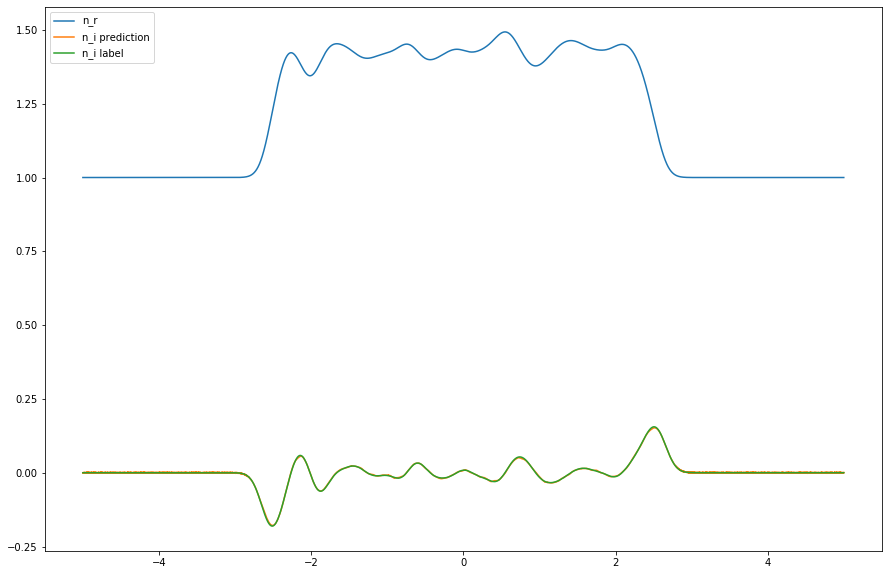

In [53]:
nr, ni, ni_pred, k = plot_prediction(validation_loader,
                                     model,
                                     grid,
                                     nr_mean,
                                     nr_std,
                                     ni_mean,
                                     ni_std,
                                     idx=0,
                                     k=None,
                                    device = device)
plt.savefig(path_plots + which_model + '_Prediction.pdf')

The intensity with the label potential like this...

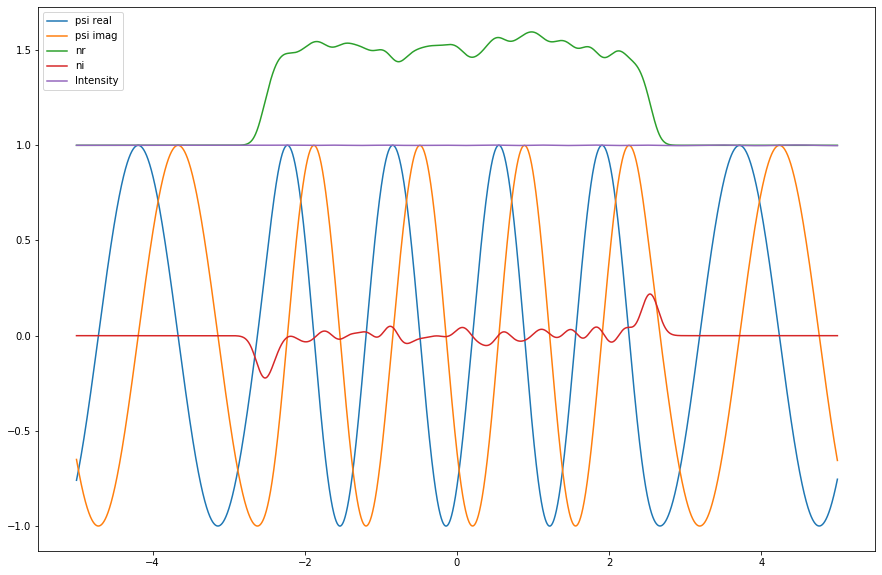

In [23]:
Int = plot_psi(grid, stepsize, n=nr + 1j * ni, Amp=1, k=k)

And the intensity with the predicted potential like this...

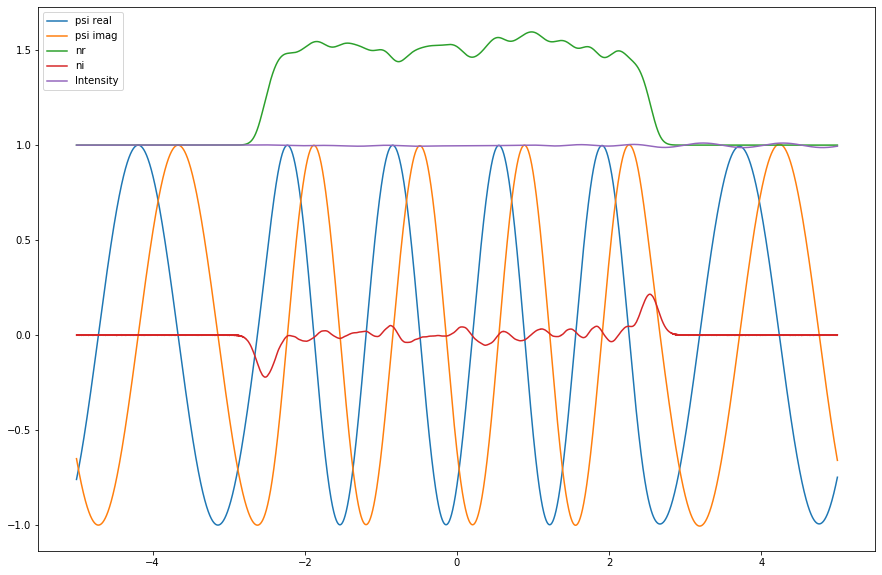

In [24]:
Int_pred = plot_psi(grid, stepsize, n=nr + 1j * ni_pred, Amp=1, k=k)
plt.savefig(path_plots + which_model + '_CI.pdf')

The differences between the predicted potentials and intensities like this...

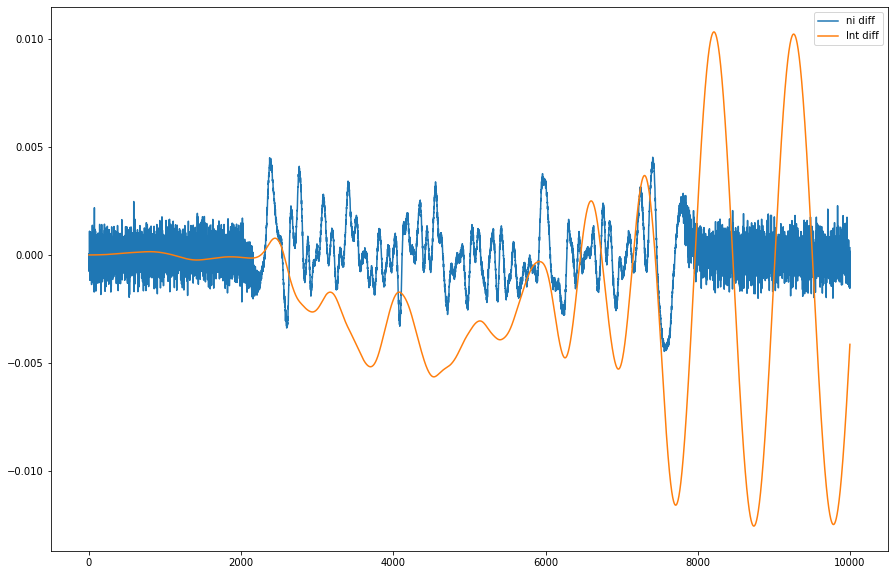

In [25]:
plt.plot(ni_pred - ni, label='ni diff')
plt.plot(Int_pred - Int, label='Int diff')
plt.legend(loc='upper right')
plt.savefig(path_plots + which_model + '_Diff.pdf')

The label intensity vs the predicted

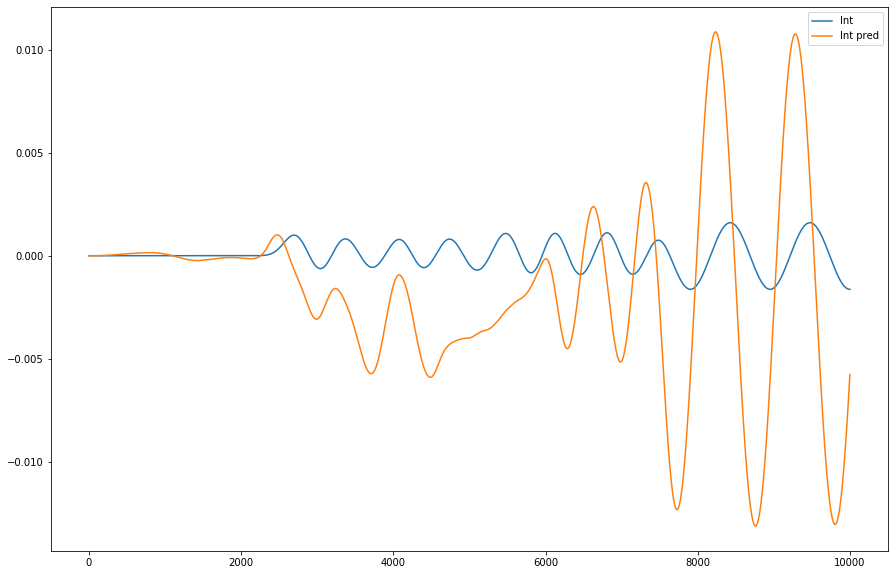

In [26]:
plt.plot(Int - 1, label='Int')
plt.plot(Int_pred - 1, label='Int pred')
plt.legend(loc='upper right')

### Special Cases

In [27]:
plt.rcParams['figure.figsize'] = [15, 10]

knr:  torch.Size([8, 10001])
ni_pred:  torch.Size([10000])
nr:  torch.Size([10001])
6.000000047085833


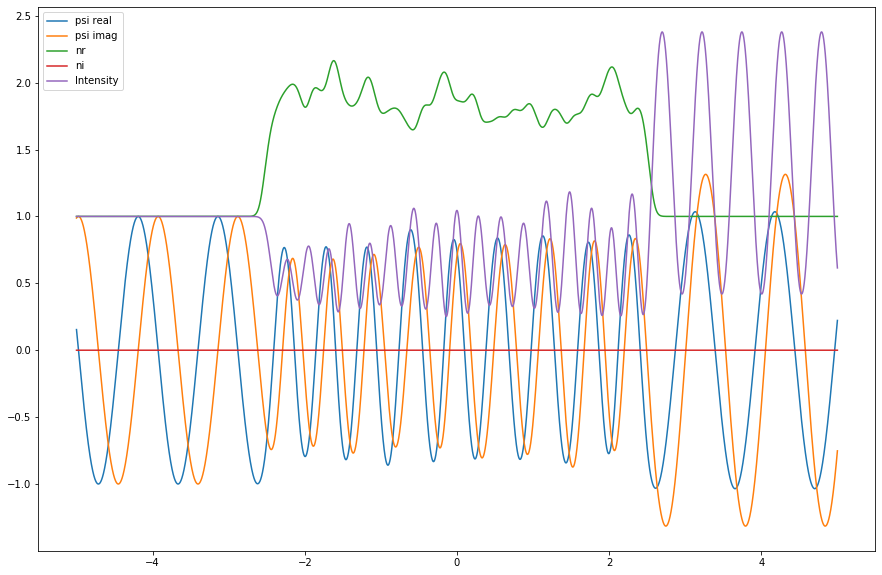

In [28]:
# numerov wave to just nr (what about the intensity? it shouldnt be wave-y)

idx = np.random.randint(8)

item = next(iter(validation_loader))

knr = item['k_n_r'].to(device)
print('knr: ', knr.size())
ni_pred = model(knr)[idx]
print('ni_pred: ', ni_pred.size())

nr = knr[idx]
print('nr: ', nr.size())

k = DeNorm(knr[idx][0].cpu().numpy(), nr_mean, nr_std)
print(k)
n = DeNorm(nr.cpu().numpy(), nr_mean, nr_std)  # + 1j*ni_pred.detach().numpy()
plot_psi(grid, stepsize, n, Amp=1, k=k, plot=True)

plt.savefig(path_plots + '_onlynr.pdf')

### Test

In [29]:
if do_create_test_data:
    generate_init_data_diverse(1000, path=path_test_data, x=grid, dx=stepsize)

In [30]:
nr_mean_test, nr_std_test, ni_mean_test, ni_std_test = calc_mean_std(
    3000, path_test_data)

In [31]:
transform_test = transforms.Compose([
    Normalize((nr_mean_test, ni_mean_test), (nr_std_test, ni_std_test)),
    ToTensor() #device
])

In [32]:
initial_dataset_test = InitialDataset(csv_file=path_test_data + 'k_values.csv',
                                      root_dir=path_test_data,
                                      transform=transform_test)

In [33]:
test_loader, _ = get_dataloaders(initial_dataset_test,
                                 batch_size=6,
                                 validation_split=0,
                                 shuffle_dataset=False,
                                 random_seed=42)

1380
0.008583159185945988


<function matplotlib.pyplot.show(*args, **kw)>

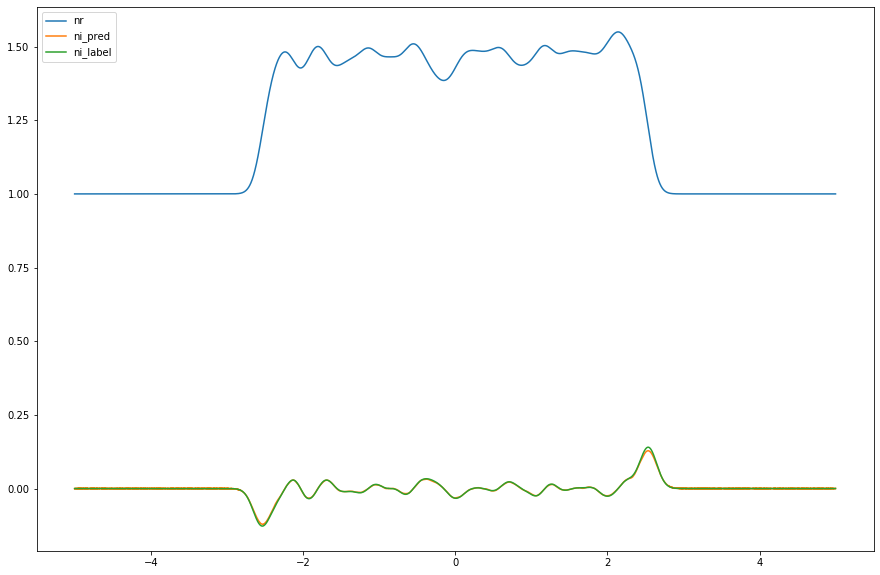

In [34]:
idx = np.random.randint(3000)
print(idx)

data = initial_dataset_test[idx]['k_n_r'].view(1, -1).to(device)
out = model(data)
label = initial_dataset_test[idx]['n_i'].to(device)

criterion = torch.nn.MSELoss()
print(criterion(out[0], label).item() * 8)

plt.plot(grid,
         DeNorm(data[0][1:].detach().cpu().numpy(), nr_mean_test, nr_std_test),
         label='nr')
plt.plot(grid,
         DeNorm(out[0].detach().cpu().numpy(), ni_mean_test, ni_std_test),
         label='ni_pred')
plt.plot(grid,
         DeNorm(label.detach().cpu().numpy(), ni_mean_test, ni_std_test),
         label='ni_label')
plt.legend(loc='upper left')
plt.show

idx:  5
knr:  tensor([[ 5.1978, -1.0156, -1.0156,  ..., -1.0156, -1.0156, -1.0156],
        [26.9444, -1.0156, -1.0156,  ..., -1.0156, -1.0156, -1.0156],
        [20.7311, -1.0156, -1.0156,  ..., -1.0156, -1.0156, -1.0156],
        [14.5178, -1.0156, -1.0156,  ..., -1.0156, -1.0156, -1.0156],
        [17.6244, -1.0156, -1.0156,  ..., -1.0156, -1.0156, -1.0156],
        [14.5178, -1.0156, -1.0156,  ..., -1.0156, -1.0156, -1.0156]],
       device='cuda:0')
real k:  5.99999995770964
new k:  1
knr:  tensor([[-1.0156, -1.0156, -1.0156,  ..., -1.0156, -1.0156, -1.0156],
        [-1.0156, -1.0156, -1.0156,  ..., -1.0156, -1.0156, -1.0156],
        [-1.0156, -1.0156, -1.0156,  ..., -1.0156, -1.0156, -1.0156],
        [-1.0156, -1.0156, -1.0156,  ..., -1.0156, -1.0156, -1.0156],
        [-1.0156, -1.0156, -1.0156,  ..., -1.0156, -1.0156, -1.0156],
        [-1.0156, -1.0156, -1.0156,  ..., -1.0156, -1.0156, -1.0156]],
       device='cuda:0')
max Int:  1.1284171549157564
min Int:  0.9439659377350

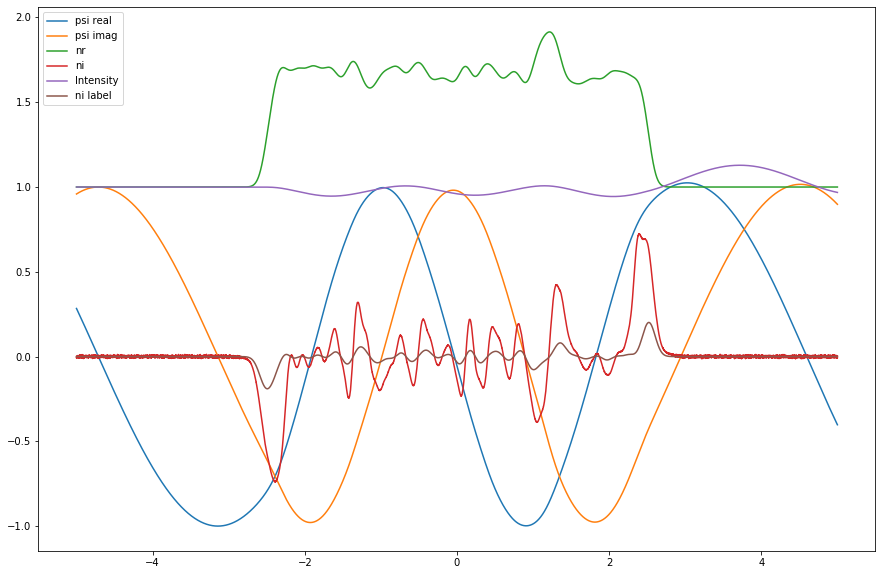

In [35]:
# predict ni for other k - does that work...?

idx = np.random.randint(6)
print('idx: ', idx)

item = next(iter(test_loader))

knr = item['k_n_r'].to(device)
print('knr: ', knr)

ni = DeNorm(item['n_i'][idx].detach().cpu().numpy(), ni_mean_test, ni_std_test)
k_real = DeNorm(knr[idx][0].detach().cpu().numpy(), nr_mean_test, nr_std_test)
print('real k: ', k_real)

k_new = 1  #np.random.randint(1,11) # np.around(k_real)
print('new k: ', k_new)

knr[:, 0] = (k_new - nr_mean_test) / nr_std_test  # normalize
print('knr: ', knr)

ni_pred = model(knr)[idx]
#print('ni_pred: ', ni_pred.size())

#print('new k normalized: ',knr[idx][0].cpu().numpy())
k = knr[idx][0].cpu().numpy()
#print('new k: ', k*nr_std + nr_mean)
nr = DeNorm(knr[idx].cpu().numpy(), nr_mean_test, nr_std_test)[1:]
ni_pred = DeNorm(ni_pred.detach().cpu().numpy(), ni_mean_test, ni_std_test)
n = nr + 1j * ni_pred
Int_pred = plot_psi(grid, stepsize, n, Amp=1, k=k_new, plot=True)
#Int_pred = plot_psi(grid, stepsize, n, Amp=1, k=k_real, plot = True)
#plt.plot(grid, ni_pred, label='ni')
plt.plot(grid, ni, label='ni label')
plt.legend(loc='upper left')

plt.savefig(path_plots + which_model + '_differentk.pdf')

print('max Int: ', np.max(Int_pred))
print('min Int: ', np.min(Int_pred))

### Treshold CI Check

In [36]:
# check for all in testset if CI without ni

Amp = 1
Tresh = [0.5, 0.2, 0.1, 0.05, 0.03]
hermit_over_tresh = np.zeros([len(Tresh), 10])  #tresh, k_real
hermit_how_many_k = np.zeros(10)

for j, batch in enumerate(test_loader):

    knrs = batch['k_n_r'].to(device)
    nis = batch['n_i'].to(device)
    for knr, ni in zip(knrs, nis):
        k = int(
            np.around(
                DeNorm(knr[0].detach().cpu().numpy(), nr_mean_test,
                       nr_std_test)))

        hermit_how_many_k[k - 1] += 1

        nr = DeNorm(knr[1:].detach().cpu().numpy(), nr_mean_test, nr_std_test)

        Int = plot_psi(grid, stepsize, n=nr, Amp=Amp, k=k, plot=False)

        rel_err = np.max((np.abs(Int[-2000:] - Amp) / Amp))

        for i, tr in enumerate(Tresh):
            if rel_err > tr:
                hermit_over_tresh[i, k - 1] += 1
    if j % 10 == 0:
        print('{}/{}, {}:{}, {}:{}, {}:{}, {}:{}, {}:{}'.format(
            j, len(test_loader), np.sum(Tresh[0]),
            np.sum(hermit_over_tresh[0]), np.sum(Tresh[1]),
            np.sum(hermit_over_tresh[1]), np.sum(Tresh[2]),
            np.sum(hermit_over_tresh[2]), np.sum(Tresh[3]),
            np.sum(hermit_over_tresh[3]), np.sum(Tresh[4]),
            np.sum(hermit_over_tresh[4])))

0/500, 0.5:3.0, 0.2:6.0, 0.1:6.0, 0.05:6.0, 0.03:6.0
10/500, 0.5:29.0, 0.2:42.0, 0.1:54.0, 0.05:60.0, 0.03:63.0
20/500, 0.5:51.0, 0.2:80.0, 0.1:102.0, 0.05:111.0, 0.03:116.0
30/500, 0.5:76.0, 0.2:113.0, 0.1:144.0, 0.05:160.0, 0.03:169.0
40/500, 0.5:97.0, 0.2:148.0, 0.1:187.0, 0.05:213.0, 0.03:223.0
50/500, 0.5:125.0, 0.2:185.0, 0.1:232.0, 0.05:261.0, 0.03:276.0
60/500, 0.5:148.0, 0.2:223.0, 0.1:275.0, 0.05:313.0, 0.03:331.0
70/500, 0.5:173.0, 0.2:260.0, 0.1:323.0, 0.05:366.0, 0.03:387.0
80/500, 0.5:189.0, 0.2:291.0, 0.1:365.0, 0.05:417.0, 0.03:439.0
90/500, 0.5:213.0, 0.2:327.0, 0.1:406.0, 0.05:463.0, 0.03:488.0
100/500, 0.5:232.0, 0.2:363.0, 0.1:450.0, 0.05:513.0, 0.03:545.0
110/500, 0.5:250.0, 0.2:397.0, 0.1:490.0, 0.05:561.0, 0.03:595.0
120/500, 0.5:269.0, 0.2:430.0, 0.1:528.0, 0.05:607.0, 0.03:645.0
130/500, 0.5:293.0, 0.2:466.0, 0.1:571.0, 0.05:653.0, 0.03:697.0
140/500, 0.5:312.0, 0.2:498.0, 0.1:611.0, 0.05:701.0, 0.03:752.0
150/500, 0.5:332.0, 0.2:533.0, 0.1:655.0, 0.05:752.0, 0

[0 1 2 3 4 5]
[1103.0, 659.0, 396.0, 293.0, 189.0, 360.0]
['>0.5', '0.2 - 0.5', '0.1 - 0.2', '0.05 - 0.1', '0.03 - 0.05', '<0.03']


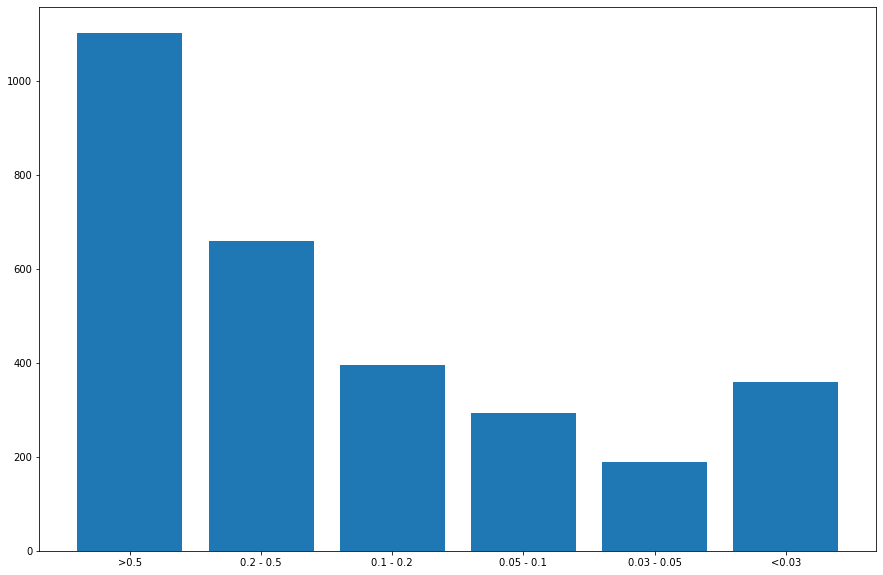

In [37]:
hermit_sum_over_tresh = np.zeros(len(hermit_over_tresh))
for i in range(len(hermit_sum_over_tresh)):
    hermit_sum_over_tresh[i] = int(np.sum(hermit_over_tresh[i]))

plot_intensity_bars(Tresh, hermit_sum_over_tresh,
                    path_plots + 'bars_hermitean.pdf')

0.5 0.38252634854888146
0.2 0.6011665257527595
0.1 0.7316244392139396
0.05 0.8271422154038387
0.03 0.8892028813985291


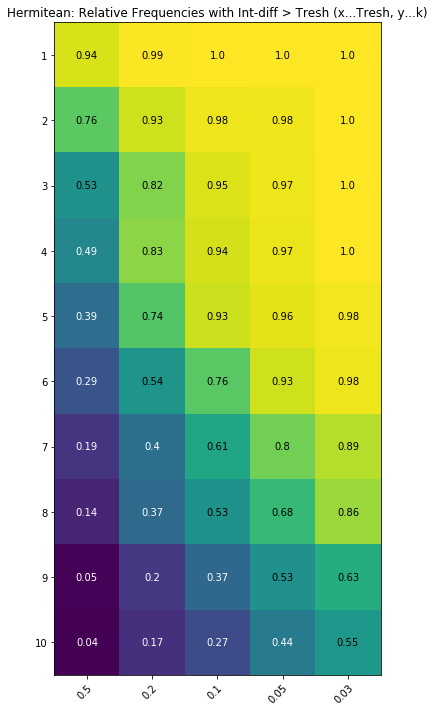

In [38]:
# map for the relative frequencies against the treshhold

k_real = list(range(1, 11))

hermit_rel_freq = np.copy(hermit_over_tresh)

for i in range(len(hermit_rel_freq)):
    hermit_rel_freq[i, :] = hermit_rel_freq[i, :] / hermit_how_many_k
    print(Tresh[i], np.mean(hermit_rel_freq[i, :]))

hermit_rel_freq = np.transpose(hermit_rel_freq)

textcolors = ["black", "white"]
textcolor_tresh = np.max(hermit_rel_freq) / 2

fig, ax = plt.subplots()
im = ax.imshow(hermit_rel_freq)

# We want to show all ticks...
ax.set_xticks(np.arange(len(Tresh)))
ax.set_yticks(np.arange(len(k_real)))
# ... and label them with the respective list entries
ax.set_xticklabels(Tresh)
ax.set_yticklabels(k_real)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(k_real)):
    for j in range(len(Tresh)):
        text = ax.text(
            j,
            i,
            np.around(hermit_rel_freq[i, j], decimals=2),
            ha="center",
            va="center",
            color=textcolors[int(hermit_rel_freq[i, j] < textcolor_tresh)])

ax.set_title(
    "Hermitean: Relative Frequencies with Int-diff > Tresh (x...Tresh, y...k)")
fig.tight_layout()
plt.savefig(path_plots + which_model + '_hermit_RelFreq_gTresh.pdf')
plt.show()

In [39]:
# check for all in testset if CI with ni label

Amp = 1
Tresh = [0.5, 0.2, 0.1, 0.05, 0.03]
nilabel_over_tresh = np.zeros([len(Tresh), 10])  #tresh, k_real
nilabel_how_many_k = np.zeros(10)

for j, batch in enumerate(test_loader):

    knrs = batch['k_n_r'].to(device)
    nis = batch['n_i'].to(device)
    for knr, ni in zip(knrs, nis):
        k = int(
            np.around(
                DeNorm(knr[0].detach().cpu().numpy(), nr_mean_test,
                       nr_std_test)))

        nilabel_how_many_k[k - 1] += 1

        nr = DeNorm(knr[1:].detach().cpu().numpy(), nr_mean_test, nr_std_test)
        ni = DeNorm(ni.cpu().numpy(), ni_mean_test, ni_std_test)

        Int = plot_psi(grid,
                       stepsize,
                       n=nr + 1j * ni,
                       Amp=Amp,
                       k=k,
                       plot=False)

        rel_err = np.max((np.abs(Int - Amp) / Amp))

        for i, tr in enumerate(Tresh):
            if rel_err > tr:
                nilabel_over_tresh[i, k - 1] += 1
    if j % 10 == 0:
        print('{}/{}, {}:{}, {}:{}, {}:{}, {}:{}, {}:{}'.format(
            j, len(test_loader), np.sum(Tresh[0]),
            np.sum(nilabel_over_tresh[0]), np.sum(Tresh[1]),
            np.sum(nilabel_over_tresh[1]), np.sum(Tresh[2]),
            np.sum(nilabel_over_tresh[2]), np.sum(Tresh[3]),
            np.sum(nilabel_over_tresh[3]), np.sum(Tresh[4]),
            np.sum(nilabel_over_tresh[4])))

0/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:0.0
10/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:1.0
20/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:3.0
30/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:3.0
40/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:5.0
50/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:6.0
60/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:6.0
70/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:7.0
80/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:7.0
90/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:7.0
100/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:7.0
110/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:7.0
120/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:7.0
130/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:7.0
140/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:8.0
150/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:8.0
160/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:10.0
170/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:0.0, 0.03:11.0
180/500, 0.5:0.0, 0

[0 1 2 3 4 5]
[0.0, 0.0, 0.0, 8.0, 29.0, 2963.0]
['>0.5', '0.2 - 0.5', '0.1 - 0.2', '0.05 - 0.1', '0.03 - 0.05', '<0.03']


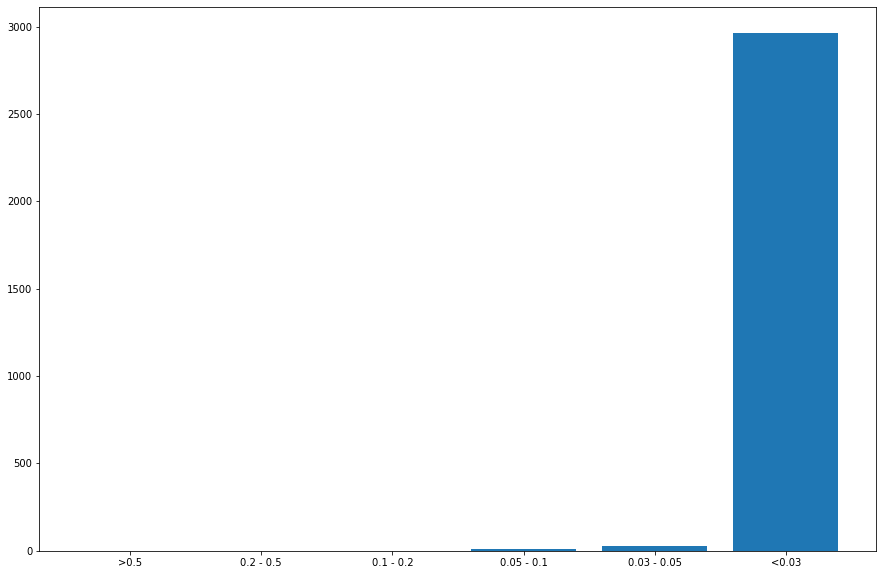

In [40]:
nilabel_sum_over_tresh = np.zeros(len(nilabel_over_tresh))
for i in range(len(nilabel_sum_over_tresh)):
    nilabel_sum_over_tresh[i] = int(np.sum(nilabel_over_tresh[i]))

plot_intensity_bars(Tresh, nilabel_sum_over_tresh,
                    path_plots + 'bars_label.pdf')

0.5 0.0
0.2 0.0
0.1 0.0
0.05 0.0028532608695652174
0.03 0.012263039570756756


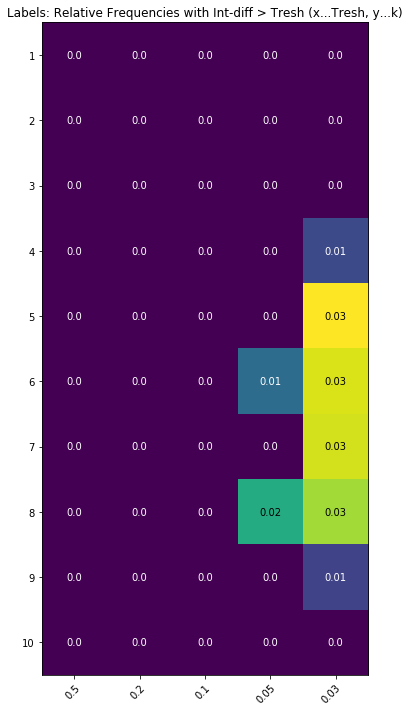

In [41]:
# map for the relative frequencies against the treshhold

k_real = list(range(1, 11))

nilabel_rel_freq = np.copy(nilabel_over_tresh)

for i in range(len(nilabel_rel_freq)):
    nilabel_rel_freq[i, :] = nilabel_rel_freq[i, :] / nilabel_how_many_k
    print(Tresh[i], np.mean(nilabel_rel_freq[i, :]))

nilabel_rel_freq = np.transpose(nilabel_rel_freq)

textcolors = ["black", "white"]
textcolor_tresh = np.max(nilabel_rel_freq) / 2

fig, ax = plt.subplots()
im = ax.imshow(nilabel_rel_freq)

# We want to show all ticks...
ax.set_xticks(np.arange(len(Tresh)))
ax.set_yticks(np.arange(len(k_real)))
# ... and label them with the respective list entries
ax.set_xticklabels(Tresh)
ax.set_yticklabels(k_real)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(k_real)):
    for j in range(len(Tresh)):
        text = ax.text(
            j,
            i,
            np.around(nilabel_rel_freq[i, j], decimals=2),
            ha="center",
            va="center",
            color=textcolors[int(nilabel_rel_freq[i, j] < textcolor_tresh)])

ax.set_title(
    "Labels: Relative Frequencies with Int-diff > Tresh (x...Tresh, y...k)")
fig.tight_layout()
plt.savefig(path_plots + which_model + '_nilabel_RelFreq_gTresh.pdf')
plt.show()

In [42]:
# check for all in testset if CI with ni pred

Amp = 1
Tresh = [0.5, 0.2, 0.1, 0.05, 0.03]
nipred_over_tresh = np.zeros([len(Tresh), 10])  #tresh, k_real
nipred_how_many_k = np.zeros(10)

for j, batch in enumerate(test_loader):

    knrs = batch['k_n_r'].to(device)
    nis = batch['n_i'].to(device)
    for knr, ni in zip(knrs, nis):
        k = int(
            np.around(
                DeNorm(knr[0].detach().cpu().numpy(), nr_mean_test,
                       nr_std_test)))

        nipred_how_many_k[k - 1] += 1

        ni_pred = model(knr.view(1, -1))[0]

        nr = DeNorm(knr[1:].detach().cpu().numpy(), nr_mean_test, nr_std_test)
        ni_pred = DeNorm(ni_pred.detach().cpu().numpy(), ni_mean_test,
                         ni_std_test)

        Int_pred = plot_psi(grid,
                            stepsize,
                            n=nr + 1j * ni_pred,
                            Amp=Amp,
                            k=k,
                            plot=False)

        rel_err = np.max((np.abs(Int_pred - Amp) / Amp))

        for i, tr in enumerate(Tresh):
            if rel_err > tr:
                nipred_over_tresh[i, k - 1] += 1
    if j % 10 == 0:
        print('{}/{}, {}:{}, {}:{}, {}:{}, {}:{}, {}:{}'.format(
            j, len(test_loader), np.sum(Tresh[0]),
            np.sum(nipred_over_tresh[0]), np.sum(Tresh[1]),
            np.sum(nipred_over_tresh[1]), np.sum(Tresh[2]),
            np.sum(nipred_over_tresh[2]), np.sum(Tresh[3]),
            np.sum(nipred_over_tresh[3]), np.sum(Tresh[4]),
            np.sum(nipred_over_tresh[4])))

0/500, 0.5:0.0, 0.2:0.0, 0.1:1.0, 0.05:4.0, 0.03:5.0
10/500, 0.5:0.0, 0.2:0.0, 0.1:5.0, 0.05:22.0, 0.03:50.0
20/500, 0.5:0.0, 0.2:2.0, 0.1:15.0, 0.05:48.0, 0.03:100.0
30/500, 0.5:0.0, 0.2:2.0, 0.1:21.0, 0.05:74.0, 0.03:151.0
40/500, 0.5:0.0, 0.2:2.0, 0.1:26.0, 0.05:97.0, 0.03:201.0
50/500, 0.5:0.0, 0.2:4.0, 0.1:34.0, 0.05:121.0, 0.03:251.0
60/500, 0.5:0.0, 0.2:5.0, 0.1:41.0, 0.05:146.0, 0.03:296.0
70/500, 0.5:0.0, 0.2:7.0, 0.1:48.0, 0.05:167.0, 0.03:350.0
80/500, 0.5:0.0, 0.2:7.0, 0.1:52.0, 0.05:186.0, 0.03:402.0
90/500, 0.5:0.0, 0.2:8.0, 0.1:56.0, 0.05:202.0, 0.03:449.0
100/500, 0.5:0.0, 0.2:9.0, 0.1:59.0, 0.05:222.0, 0.03:499.0
110/500, 0.5:0.0, 0.2:10.0, 0.1:66.0, 0.05:246.0, 0.03:547.0
120/500, 0.5:0.0, 0.2:10.0, 0.1:70.0, 0.05:268.0, 0.03:596.0
130/500, 0.5:0.0, 0.2:10.0, 0.1:74.0, 0.05:290.0, 0.03:646.0
140/500, 0.5:0.0, 0.2:11.0, 0.1:83.0, 0.05:313.0, 0.03:695.0
150/500, 0.5:0.0, 0.2:11.0, 0.1:86.0, 0.05:335.0, 0.03:744.0
160/500, 0.5:0.0, 0.2:12.0, 0.1:91.0, 0.05:351.0, 0.03:78

[0 1 2 3 4 5]
[0.0, 41.0, 233.0, 729.0, 1464.0, 533.0]
['>0.5', '0.2 - 0.5', '0.1 - 0.2', '0.05 - 0.1', '0.03 - 0.05', '<0.03']


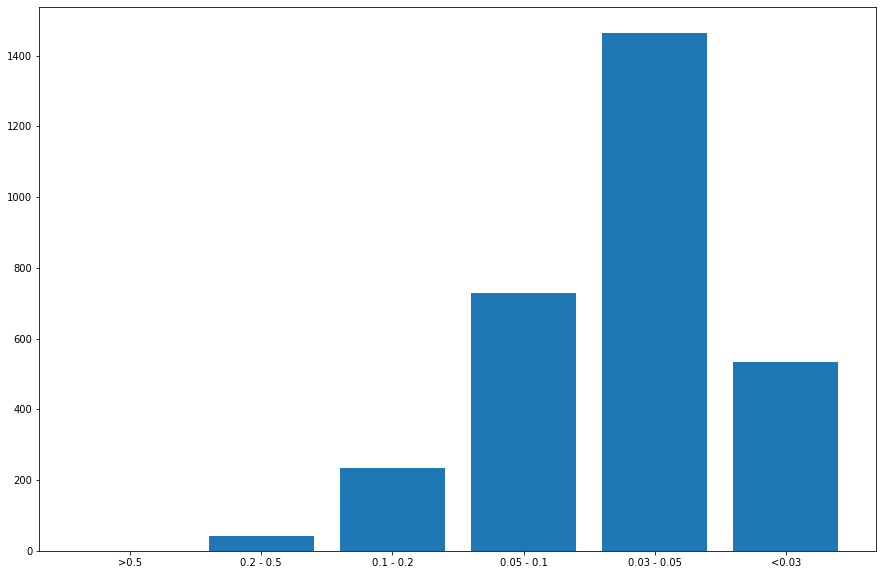

In [43]:
nipred_sum_over_tresh = np.zeros(len(nipred_over_tresh))
for i in range(len(nipred_sum_over_tresh)):
    nipred_sum_over_tresh[i] = int(np.sum(nipred_over_tresh[i]))

plot_intensity_bars(Tresh, nipred_sum_over_tresh,
                    path_plots + which_model + '_bars_prediction.pdf')

0.5 0.0
0.2 0.014001555325113985
0.1 0.0941908399884741
0.05 0.3385399647233151
0.03 0.8247100156916856


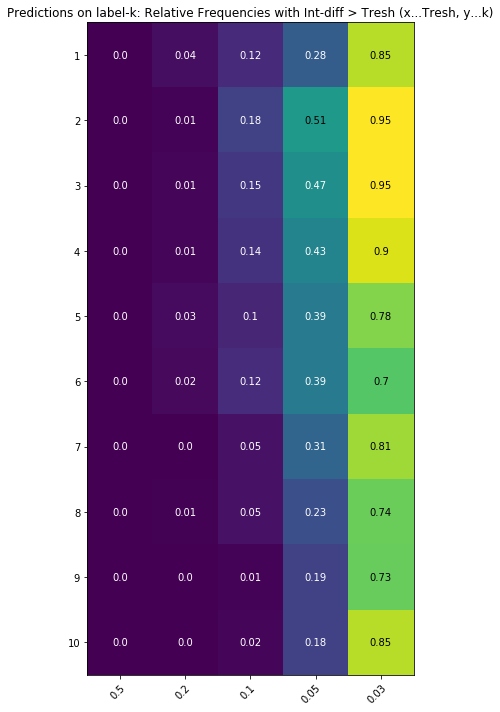

In [44]:
# map for the relative frequencies against the treshhold

k_real = list(range(1, 11))

nipred_rel_freq = np.copy(nipred_over_tresh)

for i in range(len(nipred_rel_freq)):
    nipred_rel_freq[i, :] = nipred_rel_freq[i, :] / nipred_how_many_k
    print(Tresh[i], np.mean(nipred_rel_freq[i, :]))

nipred_rel_freq = np.transpose(nipred_rel_freq)

textcolors = ["black", "white"]
textcolor_tresh = np.max(nipred_rel_freq) / 2

fig, ax = plt.subplots()
im = ax.imshow(nipred_rel_freq)

# We want to show all ticks...
ax.set_xticks(np.arange(len(Tresh)))
ax.set_yticks(np.arange(len(k_real)))
# ... and label them with the respective list entries
ax.set_xticklabels(Tresh)
ax.set_yticklabels(k_real)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(k_real)):
    for j in range(len(Tresh)):
        text = ax.text(
            j,
            i,
            np.around(nipred_rel_freq[i, j], decimals=2),
            ha="center",
            va="center",
            color=textcolors[int(nipred_rel_freq[i, j] < textcolor_tresh)])

ax.set_title(
    "Predictions on label-k: Relative Frequencies with Int-diff > Tresh (x...Tresh, y...k)"
)
fig.tight_layout()
plt.savefig(path_plots + which_model + '_nipred_RelFreq_gTresh.pdf')
plt.show()

In [45]:
# check for all in testset with random k if CI

Amp = 1
Tresh = [0.5, 0.2, 0.1, 0.05, 0.03]
over_tresh = np.zeros([len(Tresh), 10, 10])  #tresh, k_real, k_new
how_many_k = np.zeros([10, 10])  # k_real, k_new

for j, batch in enumerate(test_loader):

    knrs = batch['k_n_r'].to(device)
    nis = batch['n_i'].to(device)
    for knr, ni in zip(knrs, nis):

        k_real = int(
            np.around(
                DeNorm(knr[0].detach().cpu().numpy(), nr_mean_test,
                       nr_std_test)))
        k_new = np.random.randint(1, 11)
        #print(k_real, k_new)

        how_many_k[k_real - 1, k_new - 1] += 1

        knr[0] = (k_new - nr_mean_test) / nr_std_test
        ni_pred = model(knr.view(1, -1))[0]

        nr = DeNorm(knr[1:].detach().cpu().numpy(), nr_mean_test, nr_std_test)
        ni_pred = DeNorm(ni_pred.detach().cpu().numpy(), ni_mean_test,
                         ni_std_test)

        Int_pred = plot_psi(grid,
                            stepsize,
                            n=nr + 1j * ni_pred,
                            Amp=Amp,
                            k=k_new,
                            plot=False)

        rel_err = np.max((np.abs(Int_pred - Amp) / Amp))

        for i, tr in enumerate(Tresh):
            if rel_err > tr:
                over_tresh[i, k_real - 1, k_new - 1] += 1
    if j % 10 == 0:
        print('{}/{}, {}:{}, {}:{}, {}:{}, {}:{}, {}:{}'.format(
            j, len(test_loader), np.sum(Tresh[0]), np.sum(over_tresh[0]),
            np.sum(Tresh[1]), np.sum(over_tresh[1]), np.sum(Tresh[2]),
            np.sum(over_tresh[2]), np.sum(Tresh[3]), np.sum(over_tresh[3]),
            np.sum(Tresh[4]), np.sum(over_tresh[4])))

    #break

0/500, 0.5:0.0, 0.2:0.0, 0.1:0.0, 0.05:2.0, 0.03:5.0
10/500, 0.5:0.0, 0.2:2.0, 0.1:16.0, 0.05:38.0, 0.03:58.0
20/500, 0.5:0.0, 0.2:3.0, 0.1:23.0, 0.05:67.0, 0.03:108.0
30/500, 0.5:0.0, 0.2:7.0, 0.1:35.0, 0.05:93.0, 0.03:159.0
40/500, 0.5:0.0, 0.2:10.0, 0.1:48.0, 0.05:120.0, 0.03:209.0
50/500, 0.5:0.0, 0.2:11.0, 0.1:55.0, 0.05:141.0, 0.03:264.0
60/500, 0.5:1.0, 0.2:14.0, 0.1:66.0, 0.05:172.0, 0.03:318.0
70/500, 0.5:2.0, 0.2:18.0, 0.1:76.0, 0.05:201.0, 0.03:369.0
80/500, 0.5:2.0, 0.2:23.0, 0.1:90.0, 0.05:232.0, 0.03:423.0
90/500, 0.5:3.0, 0.2:29.0, 0.1:103.0, 0.05:264.0, 0.03:475.0
100/500, 0.5:3.0, 0.2:31.0, 0.1:112.0, 0.05:291.0, 0.03:524.0
110/500, 0.5:3.0, 0.2:31.0, 0.1:124.0, 0.05:319.0, 0.03:576.0
120/500, 0.5:4.0, 0.2:32.0, 0.1:131.0, 0.05:346.0, 0.03:629.0
130/500, 0.5:4.0, 0.2:34.0, 0.1:135.0, 0.05:371.0, 0.03:676.0
140/500, 0.5:4.0, 0.2:38.0, 0.1:149.0, 0.05:403.0, 0.03:730.0
150/500, 0.5:4.0, 0.2:38.0, 0.1:152.0, 0.05:425.0, 0.03:782.0
160/500, 0.5:4.0, 0.2:40.0, 0.1:162.0, 0.

[0 1 2 3 4 5]
[23.0, 105.0, 390.0, 872.0, 1208.0, 402.0]
['>0.5', '0.2 - 0.5', '0.1 - 0.2', '0.05 - 0.1', '0.03 - 0.05', '<0.03']


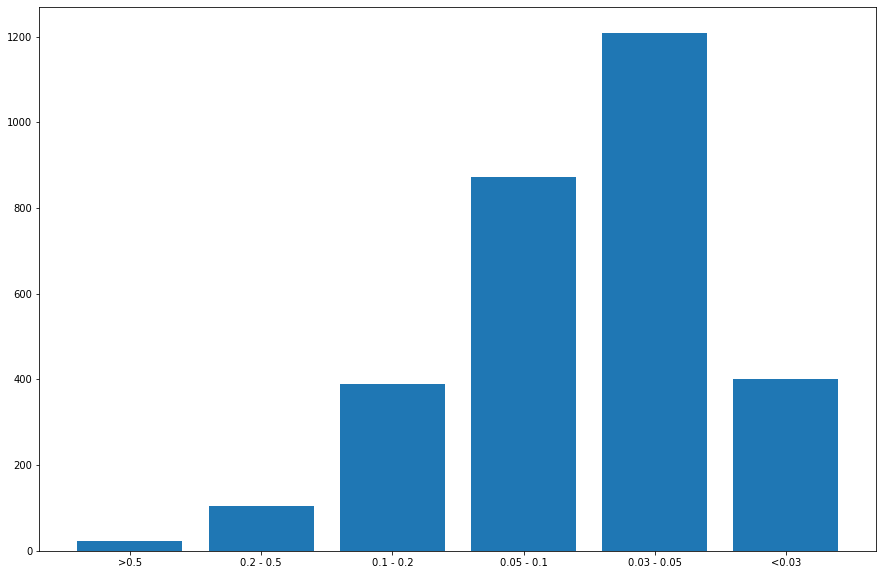

In [46]:
sum_over_tresh = np.zeros(len(over_tresh))
for i in range(len(sum_over_tresh)):
    sum_over_tresh[i] = int(np.sum(over_tresh[i]))

plot_intensity_bars(Tresh, sum_over_tresh,
                    path_plots + which_model + '_bars_differentk.pdf')

2598.0
25.98


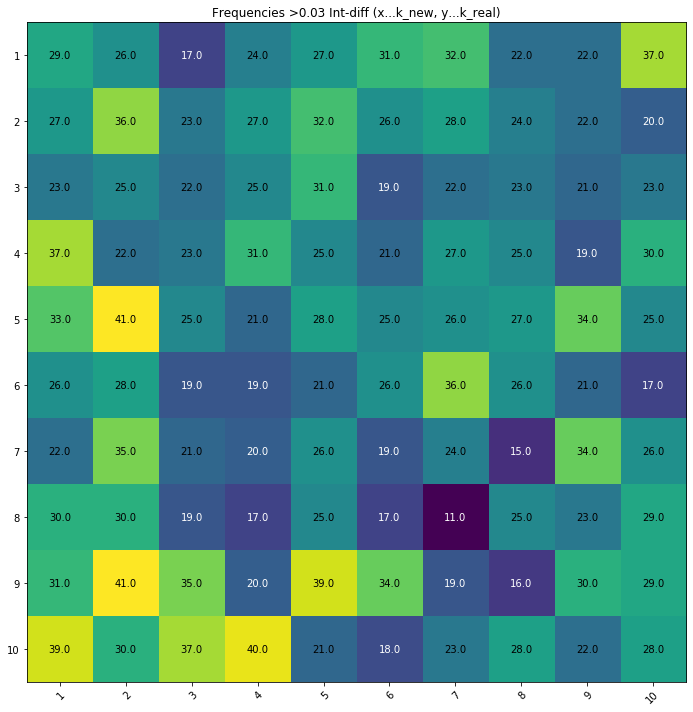

In [47]:
# map for the frequencies

tres_ind = 4

k_real = list(range(1, 11))
k_new = list(range(1, 11))

freq = over_tresh[tres_ind]
print(np.sum(freq))
print(np.mean(freq))

textcolors = ["black", "white"]
textcolor_tresh = np.max(freq) / 2

fig, ax = plt.subplots()
im = ax.imshow(freq)

# We want to show all ticks...
ax.set_xticks(np.arange(len(k_new)))
ax.set_yticks(np.arange(len(k_real)))
# ... and label them with the respective list entries
ax.set_xticklabels(k_new)
ax.set_yticklabels(k_real)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(k_real)):
    for j in range(len(k_new)):
        text = ax.text(j,
                       i,
                       freq[i, j],
                       ha="center",
                       va="center",
                       color=textcolors[int(freq[i, j] < textcolor_tresh)])

ax.set_title("Frequencies >{} Int-diff (x...k_new, y...k_real)".format(
    Tresh[tres_ind]))
fig.tight_layout()
plt.show()

3000.0
30.0


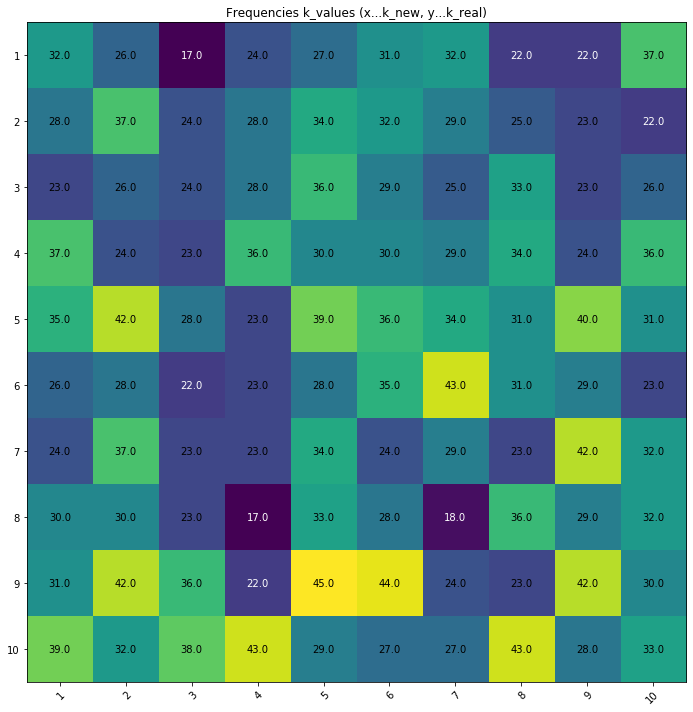

In [48]:
# map for the k values

k_real = list(range(1, 11))
k_new = list(range(1, 11))

freq_k = how_many_k
print(np.sum(freq_k))
print(np.mean(freq_k))

textcolors = ["black", "white"]
textcolor_tresh = np.max(freq_k) / 2

fig, ax = plt.subplots()
im = ax.imshow(freq_k)

# We want to show all ticks...
ax.set_xticks(np.arange(len(k_new)))
ax.set_yticks(np.arange(len(k_real)))
# ... and label them with the respective list entries
ax.set_xticklabels(k_new)
ax.set_yticklabels(k_real)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(k_real)):
    for j in range(len(k_new)):
        text = ax.text(j,
                       i,
                       np.around(freq_k[i, j], decimals=2),
                       ha="center",
                       va="center",
                       color=textcolors[int(freq_k[i, j] < textcolor_tresh)])

ax.set_title("Frequencies k_values (x...k_new, y...k_real)")
fig.tight_layout()
plt.show()

1390.0
0.4699033425355346


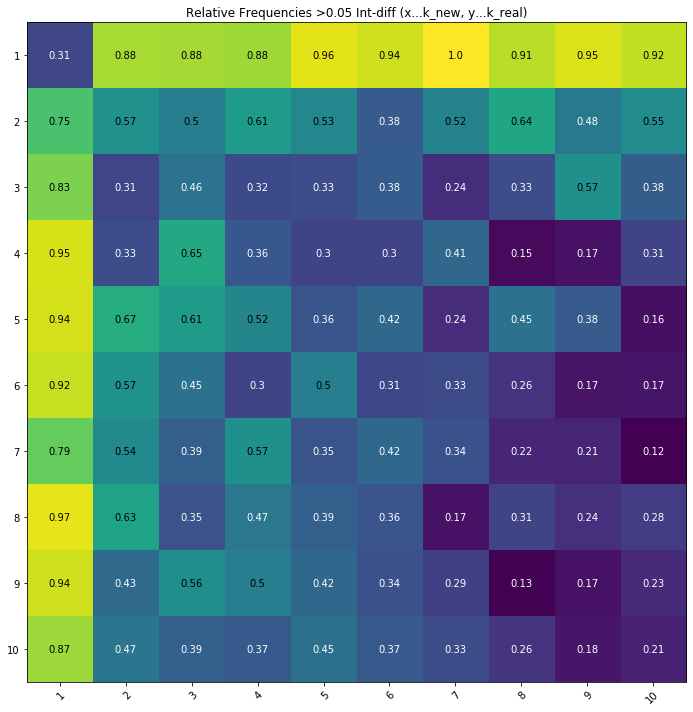

In [49]:
# map for the relative frequencies

tres_ind = 3  # [0.5, 0.2, 0.1, 0.05, 0.03]

k_real = list(range(1, 11))
k_new = list(range(1, 11))

rel_freq = over_tresh[tres_ind] / how_many_k
print(np.sum(over_tresh[tres_ind]))
print(np.mean(rel_freq))

textcolors = ["black", "white"]
textcolor_tresh = np.max(rel_freq) / 2

fig, ax = plt.subplots()
im = ax.imshow(rel_freq)

# We want to show all ticks...
ax.set_xticks(np.arange(len(k_new)))
ax.set_yticks(np.arange(len(k_real)))
# ... and label them with the respective list entries
ax.set_xticklabels(k_new)
ax.set_yticklabels(k_real)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(k_real)):
    for j in range(len(k_new)):
        text = ax.text(j,
                       i,
                       np.around(rel_freq[i, j], decimals=2),
                       ha="center",
                       va="center",
                       color=textcolors[int(rel_freq[i, j] < textcolor_tresh)])

ax.set_title(
    "Relative Frequencies >{} Int-diff (x...k_new, y...k_real)".format(
        Tresh[tres_ind]))
fig.tight_layout()
plt.savefig(path_plots + which_model + '_RelFreq_Int_' + str(Tresh[tres_ind]) +
            '.pdf')
plt.show()